In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dyutidasmahaptra/s-and-p-500-with-financial-news-headlines-20082024")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\namo\.cache\kagglehub\datasets\dyutidasmahaptra\s-and-p-500-with-financial-news-headlines-20082024\versions\1


In [2]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import json
import datetime
from datetime import date, timedelta
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from tqdm import tqdm

# Set visualization style
sns.set(style='whitegrid', palette='muted', color_codes=True)

# Import additional libraries for machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, log_loss, mean_squared_error, r2_score, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import random
random.seed(42)
np.random.seed(42)
RANDOM_STATE = 42

import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

from plot_utils import *

# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=RANDOM_STATE)

In [3]:
# Input file paths from local kagglehub dataset
raw_data_path = os.path.join(path, 'sp500_headlines_2008_2024.csv')

# Load the raw data
def load_raw_data():
    raw_data = pd.read_csv(raw_data_path)
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    return raw_data

sp500_headlines_2008_2024 = load_raw_data()
sp500_headlines_2008_2024

Title       Date       CP
0       JPMorgan Predicts 2008 Will Be "Nothing But Net" 2008-01-02  1447.16
1      Dow Tallies Biggest First-session-of-year Poin... 2008-01-02  1447.16
2                       2008 predictions for the S&P 500 2008-01-02  1447.16
3      U.S. Stocks Higher After Economic Data, Monsan... 2008-01-03  1447.16
4      U.S. Stocks Climb As Hopes Increase For More F... 2008-01-07  1416.18
...                                                  ...        ...      ...
19122          REITs vs. Stocks: What Does the Data Say? 2024-03-04  5130.95
19123  Nasdaq Index, Dow Jones, S&P 500 News: Futures... 2024-03-04  5130.95
19124  Nasdaq 100, Dow Jones, S&P 500 News: Cautious ... 2024-03-04  5130.95
19125  Bank of America boosts S&P 500 target to 5,400... 2024-03-04  5130.95
19126  S&P 500 Gains and Losses Today: Tesla Shares T... 2024-03-04  5130.95

[19127 rows x 3 columns]

In [4]:
sp500_headlines_2008_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19127 entries, 0 to 19126
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Title   19127 non-null  object        
 1   Date    19127 non-null  datetime64[ns]
 2   CP      19127 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 448.4+ KB


In [5]:
sp500_headlines_2008_2024.duplicated().sum()

974

<Axes: >

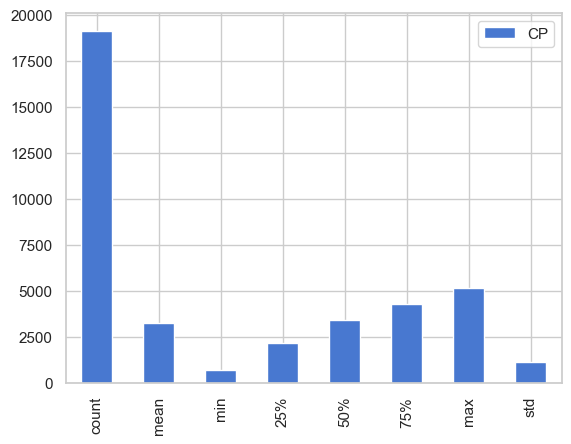

In [6]:
sp500_headlines_2008_2024.describe().plot(kind='bar')

<Axes: xlabel='Date', ylabel='CP'>

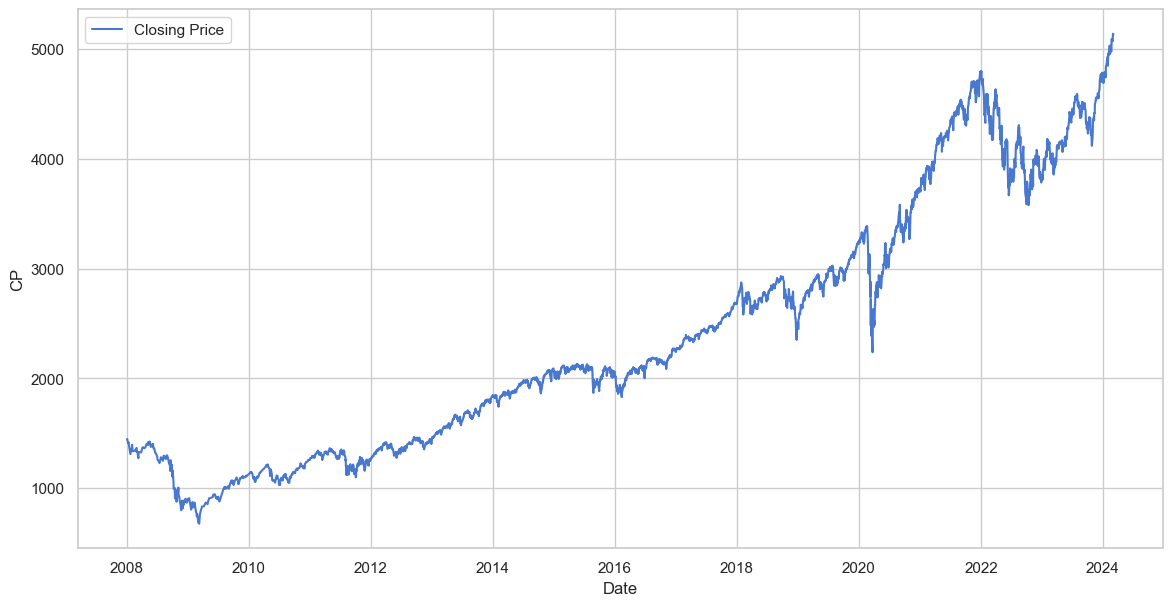

In [7]:
# Plot index prices over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='CP', data=sp500_headlines_2008_2024, label='Closing Price')

Numeric columns: Index(['CP'], dtype='object')


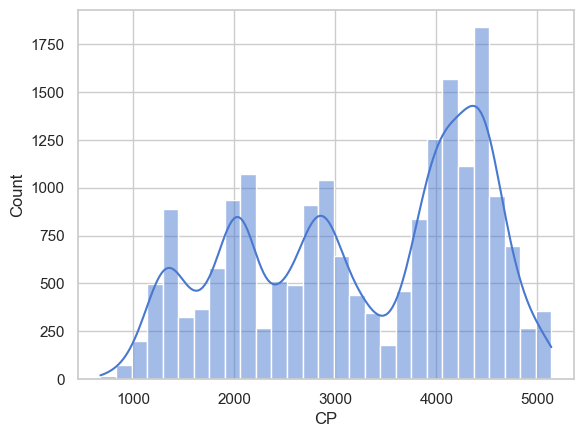

In [8]:
numeric_cols = sp500_headlines_2008_2024.select_dtypes(include=['number']).columns
print("Numeric columns:", numeric_cols)

for col in numeric_cols:
    sns.histplot(x=col, data=sp500_headlines_2008_2024, kde=True)
    plt.show()

## Prepare sentiment data

In [9]:
# Limit the dataset by number of rows for testing
max_rows = len(sp500_headlines_2008_2024)

In [10]:
# Load FinBERT (pre-trained for financial sentiment)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Custom score: Positive = +1, Neutral = 0, Negative = -1
    score = (probs[0][2] - probs[0][0]).item()
    return score

# Generate sentiment scores
# For testing purposes, we can limit the number of rows processed
sp500_headlines_2008_2024_test = sp500_headlines_2008_2024.head(max_rows)
tqdm.pandas()
sp500_headlines_2008_2024_test['sentiment_score_finbert'] = sp500_headlines_2008_2024_test['Title'].progress_apply(get_sentiment_score)

print(sp500_headlines_2008_2024_test[['Date', 'Title', 'sentiment_score_finbert']].head())

100%|██████████| 19127/19127 [13:44<00:00, 23.19it/s]

        Date                                              Title  \
0 2008-01-02   JPMorgan Predicts 2008 Will Be "Nothing But Net"   
1 2008-01-02  Dow Tallies Biggest First-session-of-year Poin...   
2 2008-01-02                   2008 predictions for the S&P 500   
3 2008-01-03  U.S. Stocks Higher After Economic Data, Monsan...   
4 2008-01-07  U.S. Stocks Climb As Hopes Increase For More F...   

   sentiment_score_finbert  
0                 0.019026  
1                 0.014999  
2                 0.771308  
3                -0.787446  
4                -0.338189  


In [11]:
tt = sp500_headlines_2008_2024.head(1)

inputs = tokenizer(tt['Title'][0], return_tensors="pt", truncation=True)
outputs = model(**inputs)
probs = torch.nn.functional.softmax(outputs.logits, dim=-1)

print(probs)

# Custom score: Positive = +1, Neutral = 0, Negative = -1
score = (probs[0][2] - probs[0][0]).item()

print(score)

tensor([[0.1884, 0.6042, 0.2074]], grad_fn=<SoftmaxBackward0>)
0.0190257728099823


In [12]:
# Define volatility period
volatility_period = [5, 22, 66, 132]  # 5 days, 22 days (1 month), 66 days (3 months), 132 days (6 months)

# Compute avg daily sentiment (you already do this)
daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Compute cross-sectional sentiment dispersion (std dev of headline sentiment per day)
cross_sectional_dispersion = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].std().reset_index()
cross_sectional_dispersion.rename(columns={'sentiment_score_finbert': 'cross_sectional_sentiment_dispersion'}, inplace=True)
cross_sectional_dispersion['cross_sectional_sentiment_dispersion'].fillna(0, inplace=True)

daily_sentiment = daily_sentiment.merge(cross_sectional_dispersion, on='Date', how='left')

# # Daily average sentiment
# daily_sentiment = sp500_headlines_2008_2024_test.groupby('Date')['sentiment_score_finbert'].mean().reset_index()
# daily_sentiment.rename(columns={'sentiment_score_finbert': 'avg_sentiment_score_a_day'}, inplace=True)

# Calculate rolling n-day sentiment volatility (std deviation)
# a week, a month, a quarter, and half a year
for n in volatility_period:
    daily_sentiment[f'{n}_day_sentiment_volatility'] = daily_sentiment['avg_sentiment_score_a_day'].rolling(window=n).std()
    daily_sentiment[f'{n}_day_dispersion_volatility'] = daily_sentiment['cross_sectional_sentiment_dispersion'].rolling(window=n).std()


print(daily_sentiment)

           Date  avg_sentiment_score_a_day  \
0    2008-01-02                   0.268444   
1    2008-01-03                  -0.787446   
2    2008-01-07                  -0.338189   
3    2008-01-09                   0.464082   
4    2008-01-10                  -0.367122   
...         ...                        ...   
3502 2024-02-27                   0.151627   
3503 2024-02-28                   0.247577   
3504 2024-02-29                   0.054997   
3505 2024-03-01                  -0.280157   
3506 2024-03-04                   0.069991   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.435497                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.503006                         NaN   
4                                 0.000000                    0.510163   
...

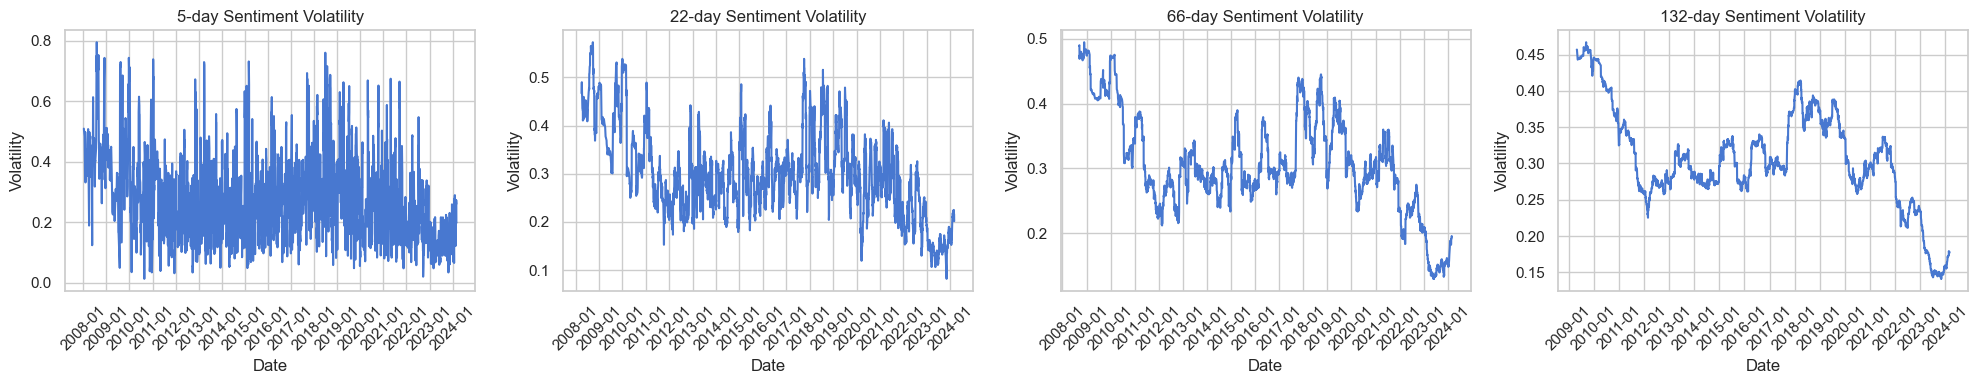

In [13]:
n_cols = 4
n_rows = int(np.ceil(len(volatility_period) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, n in enumerate(volatility_period):
    sns.lineplot(x='Date', y=f'{n}_day_sentiment_volatility', data=daily_sentiment, ax=axes[i])
    axes[i].set_title(f'{n}-day Sentiment Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


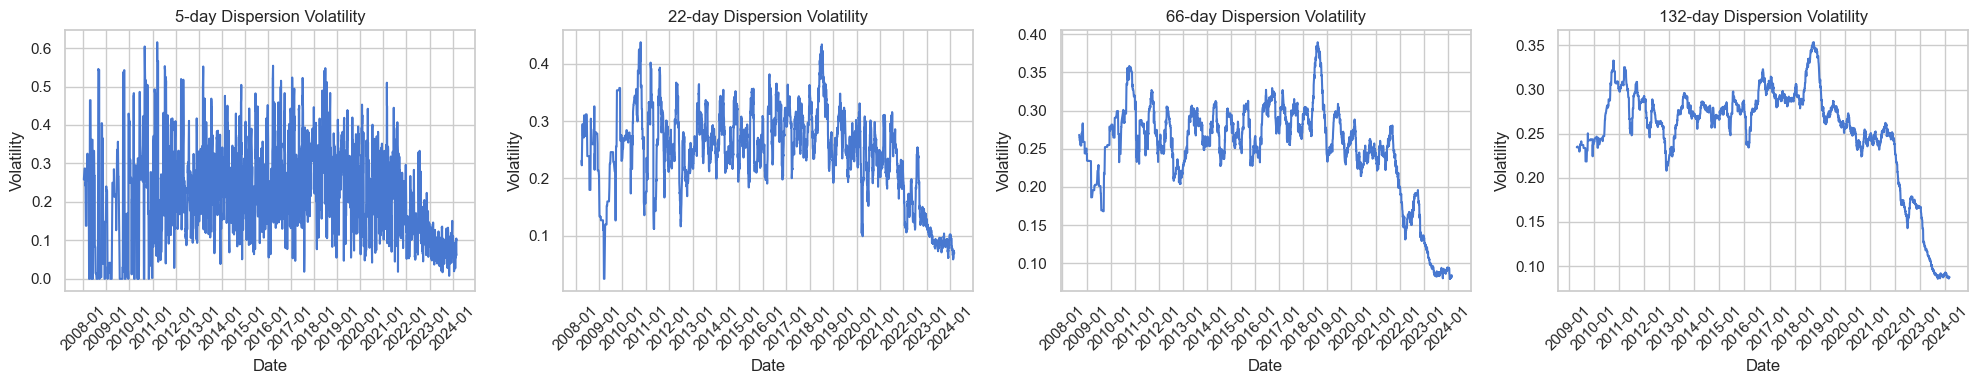

In [14]:
n_cols = 4
n_rows = int(np.ceil(len(volatility_period) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, n in enumerate(volatility_period):
    sns.lineplot(x='Date', y=f'{n}_day_dispersion_volatility', data=daily_sentiment, ax=axes[i])
    axes[i].set_title(f'{n}-day Dispersion Volatility')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Volatility')
    axes[i].xaxis.set_major_locator(mdates.YearLocator())
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [15]:
# Percentages of each sentiment group by >0, <0, and ==0
def sentiment_percentage(df, column):
    total = len(df)
    positive = len(df[df[column] > 0])
    negative = len(df[df[column] < 0])
    neutral = len(df[df[column] == 0])
    
    return {
        'positive': positive / total * 100,
        'negative': negative / total * 100,
        'neutral': neutral / total * 100
    }

sentiment_stats = sentiment_percentage(daily_sentiment, 'avg_sentiment_score_a_day')
print("Sentiment Statistics:", sentiment_stats)

Sentiment Statistics: {'positive': 90.64727687482178, 'negative': 9.352723125178215, 'neutral': 0.0}


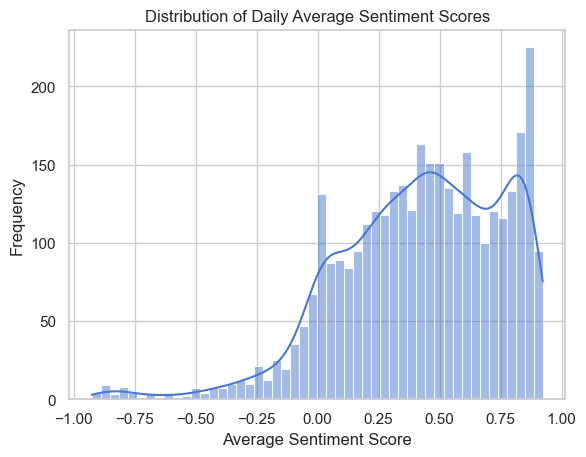

In [16]:
# Plot sentiment distribution
sns.histplot(daily_sentiment['avg_sentiment_score_a_day'], bins=50, kde=True)
plt.title('Distribution of Daily Average Sentiment Scores')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Frequency')
plt.show()

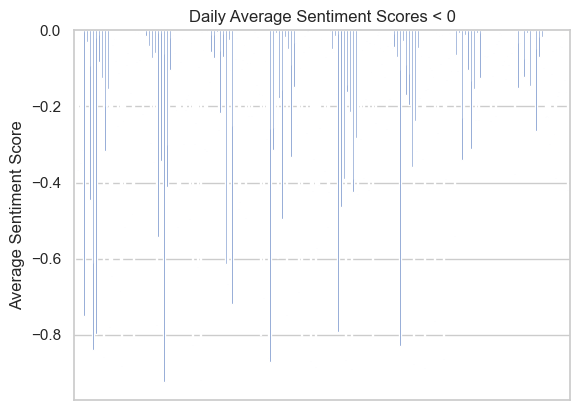

In [17]:
# Plot bar of sentiment which is <0 over time and set X axes to show year only
ax = sns.barplot(x='Date', y='avg_sentiment_score_a_day', data=daily_sentiment[daily_sentiment['avg_sentiment_score_a_day'] < 0])
ax.get_xaxis().set_visible(False)
plt.title('Daily Average Sentiment Scores < 0')
plt.ylabel('Average Sentiment Score')
plt.show()

## Prepare market data

In [18]:
# Drop the 'Title' column
df = sp500_headlines_2008_2024_test.drop(columns=['Title', 'sentiment_score_finbert'])

# Group by 'Date' and aggregate numeric columns
daily_data = df.groupby('Date', as_index=False).mean()
merged_data = pd.merge(daily_sentiment, daily_data[['Date', 'CP']], on='Date', how='left')

# Download daily OHLCV for S&P 500 (^GSPC) from yfinance
ohlcv = yf.download("^GSPC", start=merged_data['Date'].min(), end=merged_data['Date'].max())

# Flatten 
ohlcv = ohlcv.reset_index()
ohlcv.columns = [col[0] if isinstance(col, tuple) else col for col in ohlcv.columns]
ohlcv['Date'] = pd.to_datetime(ohlcv['Date'])
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Merge OHLCV into merged_data
merged_data = pd.merge(merged_data, ohlcv[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']],
                       on='Date', how='left')

# Drop CP column as it is redundant with Close
merged_data.drop(columns=['CP'], inplace=True)

print(merged_data.columns)

[*********************100%***********************]  1 of 1 completed

Index(['Date', 'avg_sentiment_score_a_day',
       'cross_sectional_sentiment_dispersion', '5_day_sentiment_volatility',
       '5_day_dispersion_volatility', '22_day_sentiment_volatility',
       '22_day_dispersion_volatility', '66_day_sentiment_volatility',
       '66_day_dispersion_volatility', '132_day_sentiment_volatility',
       '132_day_dispersion_volatility', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')


In [19]:
# Function to label future crash events based on future close prices
def add_future_crash_label(df, look_ahead_days=252, drop_threshold=0.9, close_col="Close"):
    df = df.copy()
    df["future_close"] = df[close_col].shift(-look_ahead_days)
    df["future_crash"] = (df["future_close"] < df[close_col] * drop_threshold).astype(int)
    return df

# Define look-ahead days and drop threshold
look_ahead_days = 132

# Future close price from today is less than drop_threshold% of the current close price
drop_threshold = 0.9

sp500_headlines_2008_2024_label_added = add_future_crash_label(merged_data, look_ahead_days, drop_threshold)
sp500_headlines_2008_2024_label_added

Date  avg_sentiment_score_a_day  \
0    2008-01-02                   0.268444   
1    2008-01-03                  -0.787446   
2    2008-01-07                  -0.338189   
3    2008-01-09                   0.464082   
4    2008-01-10                  -0.367122   
...         ...                        ...   
3502 2024-02-27                   0.151627   
3503 2024-02-28                   0.247577   
3504 2024-02-29                   0.054997   
3505 2024-03-01                  -0.280157   
3506 2024-03-04                   0.069991   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.435497                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.503006                         NaN   
4                                 0.000000                    0.510163   
...                                    ...                         ...   
3502                              0.589718                    0.273903   
3503                              0.636283                    0.273043   
3504                              0.654469                    0.260560   
3505                              0.502805                    0.201183   
3506                              0.552757                    0.199239   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.258126                          NaN   
...                           ...                          ...   
3502                     0.099828                     0.218901   
3503                     0.101783                     0.223571   
3504                     0.104841                     0.208376   
3505                     0.067400                     0.216625   
3506                     0.061744                     0.201547   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.073851                     0.191277   
3503                      0.073954                     0.192873   
3504                      0.070524                     0.191889   
3505                      0.071571                     0.195444   
3506                      0.069439                     0.194642   

      66_day_dispersion_volatility  132_day_sentiment_volatility  \
0                              NaN                           NaN   
1                              NaN                           NaN   
2                              NaN                           NaN   
3                              NaN                           NaN   
4                              NaN                           NaN   
...                            ...                           ...   
3502                      0.083935                      0.176086   
3503                      0.084268                      0.176693   
3504                      0.084142                      0.176523   
3505                      0.082938                      0.178177   
3506                      0.082252                      0.178143   

      132_day_dispersion_volatility         Open         High          Low  \
0                               NaN  1467.969971  1471.770020  1442.069946  

In [20]:
# Count future crash
crashed = sp500_headlines_2008_2024_label_added['future_crash'].value_counts()[1]
not_crashed = sp500_headlines_2008_2024_label_added['future_crash'].value_counts()[0]
print(crashed, not_crashed)

print(f'Ratio of crashed: {round(crashed/(crashed + not_crashed) * 100, 2)} %')

206 3301
Ratio of crashed: 5.87 %


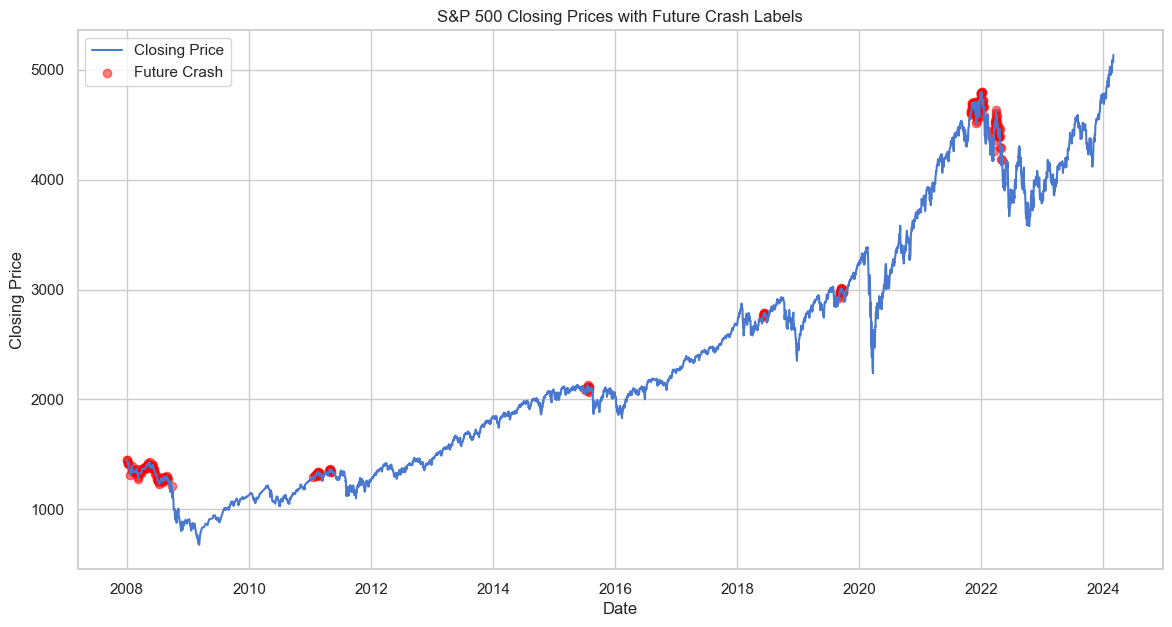

In [21]:
# Plot close prices and future crash labels
plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=sp500_headlines_2008_2024_label_added, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Close'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

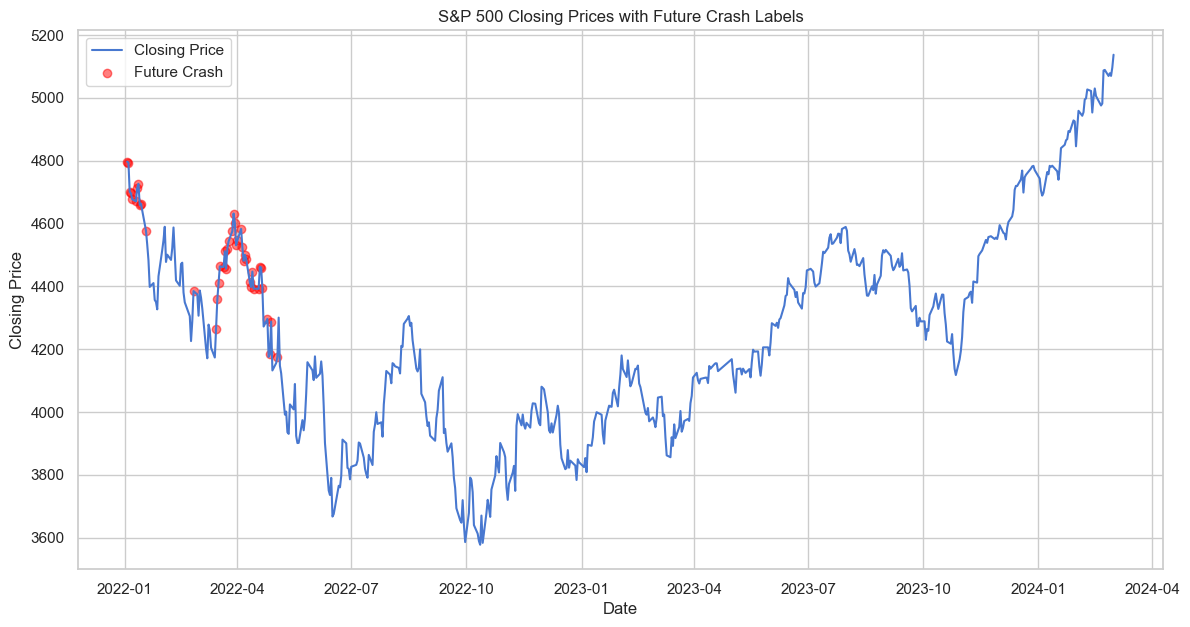

In [22]:
# Plot close prices and future crash labels
# Plot after 2022
sp500_headlines_2008_2024_label_added_after_2022 = sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01']

plt.figure(figsize=(14, 7))
sns.lineplot(x='Date', y='Close', data=sp500_headlines_2008_2024_label_added_after_2022, label='Closing Price')
plt.scatter(sp500_headlines_2008_2024_label_added_after_2022[sp500_headlines_2008_2024_label_added_after_2022['future_crash'] == 1]['Date'],
            sp500_headlines_2008_2024_label_added_after_2022[sp500_headlines_2008_2024_label_added_after_2022['future_crash'] == 1]['Close'],
            color='red', label='Future Crash',alpha=0.5)
plt.title('S&P 500 Closing Prices with Future Crash Labels')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [23]:
# Count total data points per year
total_per_year = sp500_headlines_2008_2024_label_added['Date'].dt.year.value_counts().sort_index()

# Count crashed data points per year
crashed_per_year = (
    sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['future_crash'] == 1]['Date']
    .dt.year.value_counts()
    .sort_index()
)

# Combine into a DataFrame
yearly_stats = pd.DataFrame({
    'Total Data Points': total_per_year,
    'Crashed Data Points': crashed_per_year
})

# Fill missing years with 0 crashes
yearly_stats['Crashed Data Points'] = yearly_stats['Crashed Data Points'].fillna(0).astype(int)

print(yearly_stats)

      Total Data Points  Crashed Data Points
Date                                        
2008                106                   64
2009                 90                    0
2010                132                    0
2011                216                   20
2012                241                    0
2013                241                    0
2014                242                    0
2015                243                   10
2016                240                    0
2017                228                    0
2018                243                    7
2019                248                   18
2020                249                    0
2021                250                   44
2022                251                   43
2023                244                    0
2024                 43                    0


In [24]:
# Ratio of data points before and after 2022
before_2022 = len(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01'])
after_2022 = len(sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01'])
print(f"Data points before 2022: {before_2022}, after 2022: {after_2022}") 
print(f"Ratio of data points before 2022: {before_2022 / (before_2022 + after_2022) * 100:.2f}%")

# Ratio of crash data before and after 2022
crashed_before_2022 = len(sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)])
crashed_after_2022 = len(sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)])
print(f"Crashes before 2022: {crashed_before_2022}, after 2022: {crashed_after_2022}")
print(f"Ratio of crashes before 2022: {crashed_before_2022 / (crashed_before_2022 + crashed_after_2022) * 100:.2f}%")

# Ratio of total crashes among all
total_crashes = crashed_before_2022 + crashed_after_2022
print(f"Total crashes: {total_crashes}")
print(f"Ratio of total crashes: {total_crashes / (before_2022 + after_2022) * 100:.2f}%")

Data points before 2022: 2969, after 2022: 538
Ratio of data points before 2022: 84.66%
Crashes before 2022: 163, after 2022: 43
Ratio of crashes before 2022: 79.13%
Total crashes: 206
Ratio of total crashes: 5.87%


In [25]:
# From the info above, it seems to be good if we split the data into 2008-2021, 2022-somewhere in the middle of 2022 for validating, and the rest for testing.
# Explore this hypothesis
train_data = sp500_headlines_2008_2024_label_added[sp500_headlines_2008_2024_label_added['Date'] < '2022-01-01']

# Summarize crash date from the rest of the data (exclude training data)
crash_in_rest_data = sp500_headlines_2008_2024_label_added[(sp500_headlines_2008_2024_label_added['Date'] >= '2022-01-01') & (sp500_headlines_2008_2024_label_added['future_crash'] == 1)]
print(crash_in_rest_data['Date'].describe())

count                               43
mean     2022-03-13 11:43:15.348837120
min                2022-01-03 00:00:00
25%                2022-02-06 00:00:00
50%                2022-03-28 00:00:00
75%                2022-04-11 12:00:00
max                2022-05-03 00:00:00
Name: Date, dtype: object


In [26]:
# Calculate daily returns
sp500_headlines_2008_2024_label_added['daily_return'] = sp500_headlines_2008_2024_label_added['Close'].pct_change() * 100  # Convert to percentage

# Prepare market data
market_sentiment_data = sp500_headlines_2008_2024_label_added.copy()
market_sentiment_data['Date'] = pd.to_datetime(market_sentiment_data['Date'])

market_sentiment_data

Date  avg_sentiment_score_a_day  \
0    2008-01-02                   0.268444   
1    2008-01-03                  -0.787446   
2    2008-01-07                  -0.338189   
3    2008-01-09                   0.464082   
4    2008-01-10                  -0.367122   
...         ...                        ...   
3502 2024-02-27                   0.151627   
3503 2024-02-28                   0.247577   
3504 2024-02-29                   0.054997   
3505 2024-03-01                  -0.280157   
3506 2024-03-04                   0.069991   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.435497                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.503006                         NaN   
4                                 0.000000                    0.510163   
...                                    ...                         ...   
3502                              0.589718                    0.273903   
3503                              0.636283                    0.273043   
3504                              0.654469                    0.260560   
3505                              0.502805                    0.201183   
3506                              0.552757                    0.199239   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.258126                          NaN   
...                           ...                          ...   
3502                     0.099828                     0.218901   
3503                     0.101783                     0.223571   
3504                     0.104841                     0.208376   
3505                     0.067400                     0.216625   
3506                     0.061744                     0.201547   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.073851                     0.191277   
3503                      0.073954                     0.192873   
3504                      0.070524                     0.191889   
3505                      0.071571                     0.195444   
3506                      0.069439                     0.194642   

      66_day_dispersion_volatility  132_day_sentiment_volatility  \
0                              NaN                           NaN   
1                              NaN                           NaN   
2                              NaN                           NaN   
3                              NaN                           NaN   
4                              NaN                           NaN   
...                            ...                           ...   
3502                      0.083935                      0.176086   
3503                      0.084268                      0.176693   
3504                      0.084142                      0.176523   
3505                      0.082938                      0.178177   
3506                      0.082252                      0.178143   

      132_day_dispersion_volatility         Open         High          Low  \
0                               NaN  1467.969971  1471.770020  1442.069946  

In [27]:
# Calculate n-day returns
def calculate_n_day_returns(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_return'] = data['Close'].pct_change(periods=n) * 100  # Convert to percentage
    return data

market_sentiment_data = calculate_n_day_returns(market_sentiment_data, volatility_period)
market_sentiment_data

Date  avg_sentiment_score_a_day  \
0    2008-01-02                   0.268444   
1    2008-01-03                  -0.787446   
2    2008-01-07                  -0.338189   
3    2008-01-09                   0.464082   
4    2008-01-10                  -0.367122   
...         ...                        ...   
3502 2024-02-27                   0.151627   
3503 2024-02-28                   0.247577   
3504 2024-02-29                   0.054997   
3505 2024-03-01                  -0.280157   
3506 2024-03-04                   0.069991   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.435497                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.503006                         NaN   
4                                 0.000000                    0.510163   
...                                    ...                         ...   
3502                              0.589718                    0.273903   
3503                              0.636283                    0.273043   
3504                              0.654469                    0.260560   
3505                              0.502805                    0.201183   
3506                              0.552757                    0.199239   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.258126                          NaN   
...                           ...                          ...   
3502                     0.099828                     0.218901   
3503                     0.101783                     0.223571   
3504                     0.104841                     0.208376   
3505                     0.067400                     0.216625   
3506                     0.061744                     0.201547   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.073851                     0.191277   
3503                      0.073954                     0.192873   
3504                      0.070524                     0.191889   
3505                      0.071571                     0.195444   
3506                      0.069439                     0.194642   

      66_day_dispersion_volatility  132_day_sentiment_volatility  ...  \
0                              NaN                           NaN  ...   
1                              NaN                           NaN  ...   
2                              NaN                           NaN  ...   
3                              NaN                           NaN  ...   
4                              NaN                           NaN  ...   
...                            ...                           ...  ...   
3502                      0.083935                      0.176086  ...   
3503                      0.084268                      0.176693  ...   
3504                      0.084142                      0.176523  ...   
3505                      0.082938                      0.178177  ...   
3506                      0.082252                      0.178143  ...   

              Low        Close        Volume  future_close  future_crash  \
0     1442.069946 

In [28]:
# Calculate n-day volatility
def calculate_n_day_volatility(data, volatility_period):
    for n in volatility_period:
        data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std() * np.sqrt(252)  # Standard deviation of closing prices
        # data[f'{n}_day_market_volatility'] = data['daily_return'].rolling(window=n).std()

        # # Parkinson Volatility
        # data['parkinson_vol'] = np.sqrt((1 / (4 * np.log(2))) * (np.log(data['High'] / data['Low']) ** 2))

        # # Garman-Klass Volatility
        # data['garman_klass_vol'] = np.sqrt(
        #     0.5 * (np.log(data['High'] / data['Low']) ** 2) -
        #     (2 * np.log(2) - 1) * (np.log(data['Close'] / data['Open']) ** 2)
        # )
        
        # # Rogers-Satchell Volatility
        # data['rogers_satchell_vol'] = np.sqrt(
        #     (np.log(data['High'] / data['Close']) * np.log(data['High'] / data['Open']) +
        #     np.log(data['Low'] / data['Close']) * np.log(data['Low'] / data['Open']))
        # )

    return data

market_sentiment_data = calculate_n_day_volatility(market_sentiment_data, volatility_period)
market_sentiment_data

Date  avg_sentiment_score_a_day  \
0    2008-01-02                   0.268444   
1    2008-01-03                  -0.787446   
2    2008-01-07                  -0.338189   
3    2008-01-09                   0.464082   
4    2008-01-10                  -0.367122   
...         ...                        ...   
3502 2024-02-27                   0.151627   
3503 2024-02-28                   0.247577   
3504 2024-02-29                   0.054997   
3505 2024-03-01                  -0.280157   
3506 2024-03-04                   0.069991   

      cross_sectional_sentiment_dispersion  5_day_sentiment_volatility  \
0                                 0.435497                         NaN   
1                                 0.000000                         NaN   
2                                 0.000000                         NaN   
3                                 0.503006                         NaN   
4                                 0.000000                    0.510163   
...                                    ...                         ...   
3502                              0.589718                    0.273903   
3503                              0.636283                    0.273043   
3504                              0.654469                    0.260560   
3505                              0.502805                    0.201183   
3506                              0.552757                    0.199239   

      5_day_dispersion_volatility  22_day_sentiment_volatility  \
0                             NaN                          NaN   
1                             NaN                          NaN   
2                             NaN                          NaN   
3                             NaN                          NaN   
4                        0.258126                          NaN   
...                           ...                          ...   
3502                     0.099828                     0.218901   
3503                     0.101783                     0.223571   
3504                     0.104841                     0.208376   
3505                     0.067400                     0.216625   
3506                     0.061744                     0.201547   

      22_day_dispersion_volatility  66_day_sentiment_volatility  \
0                              NaN                          NaN   
1                              NaN                          NaN   
2                              NaN                          NaN   
3                              NaN                          NaN   
4                              NaN                          NaN   
...                            ...                          ...   
3502                      0.073851                     0.191277   
3503                      0.073954                     0.192873   
3504                      0.070524                     0.191889   
3505                      0.071571                     0.195444   
3506                      0.069439                     0.194642   

      66_day_dispersion_volatility  132_day_sentiment_volatility  ...  \
0                              NaN                           NaN  ...   
1                              NaN                           NaN  ...   
2                              NaN                           NaN  ...   
3                              NaN                           NaN  ...   
4                              NaN                           NaN  ...   
...                            ...                           ...  ...   
3502                      0.083935                      0.176086  ...   
3503                      0.084268                      0.176693  ...   
3504                      0.084142                      0.176523  ...   
3505                      0.082938                      0.178177  ...   
3506                      0.082252                      0.178143  ...   

      future_crash  daily_return  5_day_market_return  22_day_market_return  \
0              

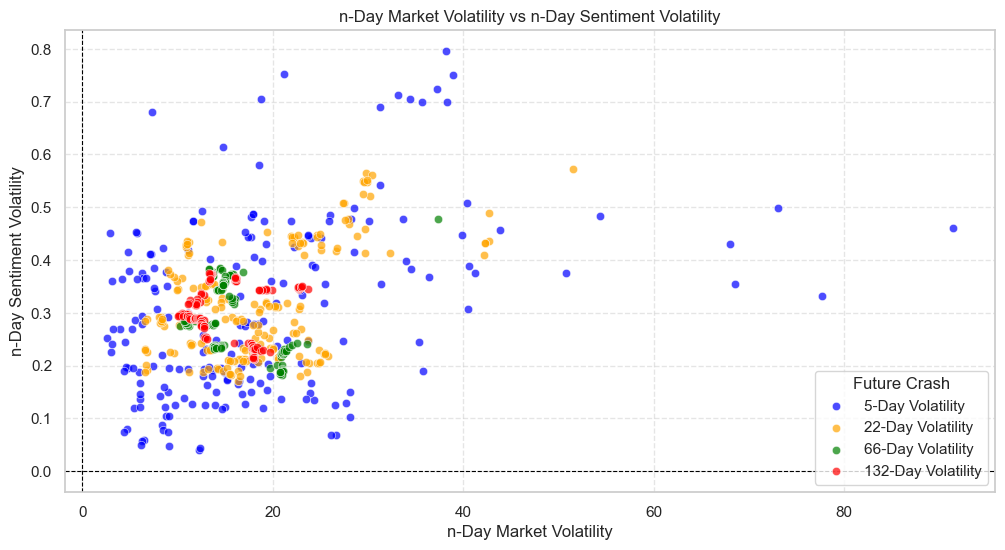

In [29]:
# Plot relationship between future crash and n-day market volatility combined with sentiment volatility
# Plot for 5 day, 22 day, 66 day, and 126 day volatility
crash_data = market_sentiment_data[market_sentiment_data['future_crash'] == 1]

# Scale the market volatility and sentiment volatility for better visualization
def scale_to_0_1(series):
    return (series - series.min()) / (series.max() - series.min())

scale_crash_data = crash_data.copy()

# for n in volatility_period:
#     scale_crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(crash_data[f'{n}_day_market_volatility'])
#     scale_crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(crash_data[f'{n}_day_sentiment_volatility'])

plt.figure(figsize=(12, 6))
sns.scatterplot(x='5_day_market_volatility', y='5_day_sentiment_volatility', data=scale_crash_data, label='5-Day Volatility', alpha=0.7, color='blue')
sns.scatterplot(x='22_day_market_volatility', y='22_day_sentiment_volatility', data=scale_crash_data, label='22-Day Volatility', alpha=0.7, color='orange')
sns.scatterplot(x='66_day_market_volatility', y='66_day_sentiment_volatility', data=scale_crash_data, label='66-Day Volatility', alpha=0.7, color='green')
sns.scatterplot(x='132_day_market_volatility', y='132_day_sentiment_volatility', data=scale_crash_data, label='132-Day Volatility', alpha=0.7, color='red')
# sns.scatterplot(x='252_day_market_volatility', y='252_day_sentiment_volatility', data=scale_crash_data, label='252-Day Volatility', alpha=0.7, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('n-Day Market Volatility vs n-Day Sentiment Volatility')
plt.xlabel('n-Day Market Volatility')
plt.ylabel('n-Day Sentiment Volatility')
plt.legend(title='Future Crash', loc='lower right')
plt.show()

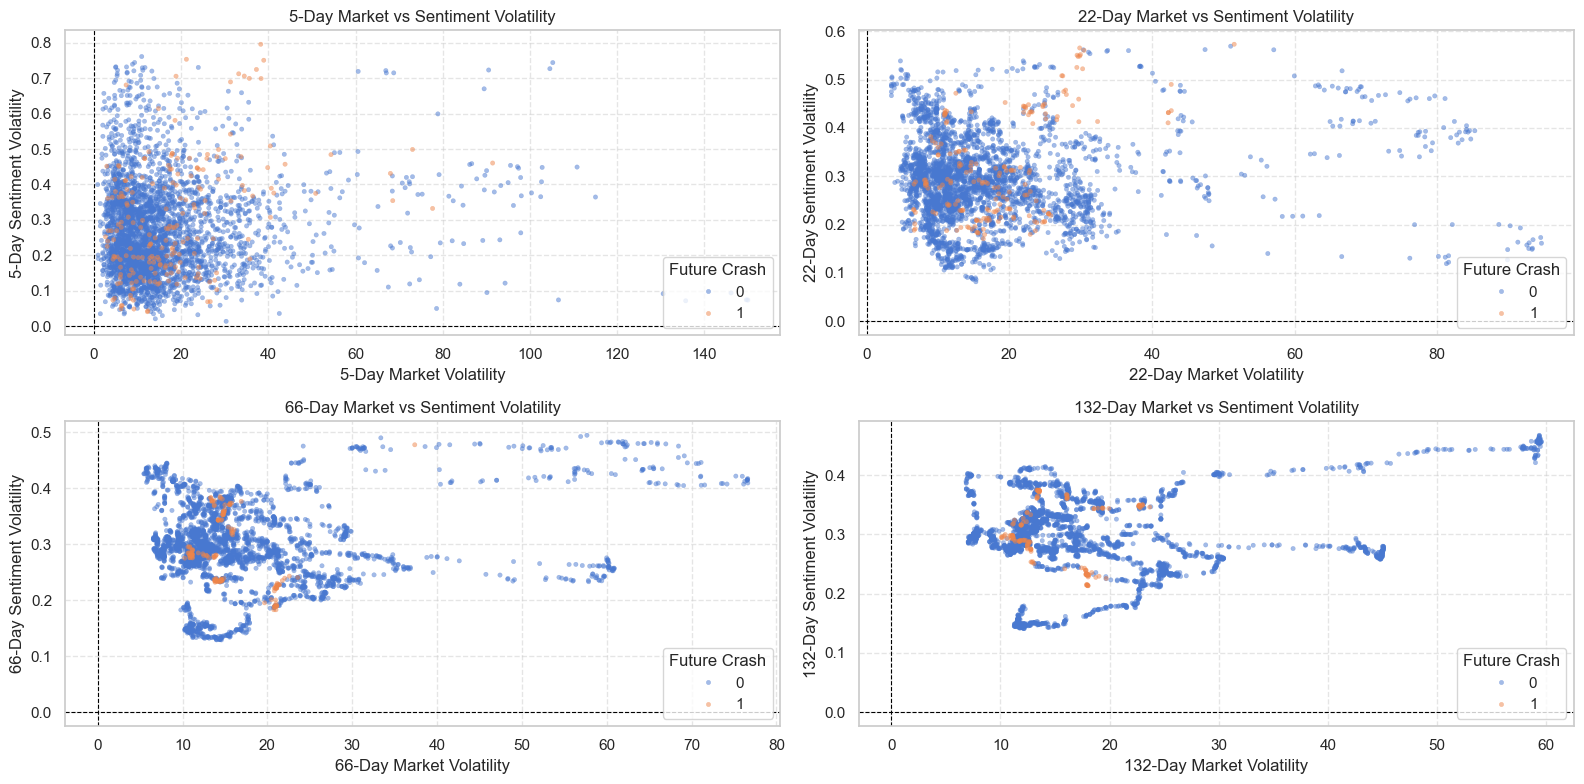

In [30]:
# Plot relationship between n-day market volatility and n-day sentiment volatility for each volatility period
n_cols = 2
n_rows = (len(volatility_period) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

scale_crash_data = market_sentiment_data.copy()
# for n in volatility_period:
#     scale_crash_data[f'{n}_day_market_volatility'] = scale_to_0_1(market_sentiment_data[f'{n}_day_market_volatility'])
#     scale_crash_data[f'{n}_day_sentiment_volatility'] = scale_to_0_1(market_sentiment_data[f'{n}_day_sentiment_volatility'])
df_sorted = scale_crash_data.sort_values('future_crash')

for idx, n in enumerate(volatility_period):
    ax = axes[idx]
    x_col = f'{n}_day_market_volatility'
    y_col = f'{n}_day_sentiment_volatility'

    # Drop NA values for clean plot
    df_plot = df_sorted.dropna(subset=[x_col, y_col, 'future_crash'])

    sns.scatterplot(
        x=x_col, y=y_col, hue='future_crash', data=df_plot, alpha=0.5, ax=ax, edgecolor=None, s=10
    )
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8)
    ax.set_title(f'{n}-Day Market vs Sentiment Volatility')
    ax.set_xlabel(f'{n}-Day Market Volatility')
    ax.set_ylabel(f'{n}-Day Sentiment Volatility')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Future Crash', loc='lower right')

# Remove unused subplots
for j in range(len(volatility_period), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.legend(title='Future Crash', loc='lower right')
plt.show()

## Modelling

### Add VaR and ES features

In [31]:
def add_var_es_features(df, return_col='daily_return', windows=volatility_period, confidence=0.05):
    df = df.copy()
    z_score = abs(stats.norm.ppf(confidence))
    
    for w in windows:
        # Rolling mean and std of returns
        rolling_mu = df[return_col].rolling(window=w).mean()
        rolling_sigma = df[return_col].rolling(window=w).std()

        # Parametric Gaussian VaR (1-day, % return)
        df[f'VaR_{w}'] = - (rolling_mu + z_score * rolling_sigma)

        # Expected Shortfall (ES) assuming normal distribution
        pdf_factor = np.exp(-0.5 * z_score**2) / (np.sqrt(2 * np.pi))
        cdf_factor = confidence
        df[f'ES_{w}'] = - (rolling_mu + (rolling_sigma * pdf_factor / cdf_factor))
    
    return df

market_sentiment_data = add_var_es_features(market_sentiment_data, return_col='daily_return', confidence=0.05)

In [32]:
market_sentiment_data.columns

Index(['Date', 'avg_sentiment_score_a_day',
       'cross_sectional_sentiment_dispersion', '5_day_sentiment_volatility',
       '5_day_dispersion_volatility', '22_day_sentiment_volatility',
       '22_day_dispersion_volatility', '66_day_sentiment_volatility',
       '66_day_dispersion_volatility', '132_day_sentiment_volatility',
       '132_day_dispersion_volatility', 'Open', 'High', 'Low', 'Close',
       'Volume', 'future_close', 'future_crash', 'daily_return',
       '5_day_market_return', '22_day_market_return', '66_day_market_return',
       '132_day_market_return', '5_day_market_volatility',
       '22_day_market_volatility', '66_day_market_volatility',
       '132_day_market_volatility', 'VaR_5', 'ES_5', 'VaR_22', 'ES_22',
       'VaR_66', 'ES_66', 'VaR_132', 'ES_132'],
      dtype='object')

In [33]:
train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
test_data = market_sentiment_data[market_sentiment_data['Date'] >= '2022-01-01']
target_col = 'future_crash'

print(train_data.shape, test_data.shape)

(2969, 35) (538, 35)


## Static Logit Regression

In [34]:
all_results = []

In [35]:
def static_logit_regression(n, feature_cols, market_sentiment_data, static_logit, X_test_dict, y_test_dict):
    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    
    # Apply SMOTE or any resampling to the training set only
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train, y_train  # For simplicity, using original training data without resampling

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit Logistic Regression
    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)

    # Predict on training set
    y_pred_train = logit.predict(X_resampled)
    y_proba_train = logit.predict_proba(X_resampled)[:, 1]

    y_proba_test = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba_test)
    y_pred_test = (y_proba_test >= best_thresh).astype(int)

    # Log loss (cross-entropy)
    train_loss = log_loss(y_resampled, y_proba_train)

    # Save results
    auc_test = roc_auc_score(y_test, y_proba_test)
    report_test = classification_report(y_test, y_pred_test, output_dict=True)
    conf = confusion_matrix(y_test, y_pred_test)
    date_seq = test_data['Date'].reset_index(drop=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    static_logit[n] = {
        'model': logit,
        'auc_score': auc_test,
        'train_log_loss': train_loss,
        'report': report_test,
        'coefficients': coefficients,
        'y_test': y_test,
        'y_prob': y_proba_test,
        'confusion': conf,
        'date_seq': date_seq,
    }

    # Save test set for plotting or later comparison
    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    # Print summary
    print(f"\n=== {n}-Day Static Logit Model ===")
    print(f"Test AUC: {auc_test:.3f}")
    print("Classification Report (Test):")
    print(classification_report(y_test, y_pred_test))

### Static Logit Regression (Market)

In [36]:
static_logit_market = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_market, X_test_dict, y_test_dict)

all_results.append(static_logit_market)

Best threshold: 0.47, F1: 0.17

=== 5-Day Static Logit Model ===
Test AUC: 0.535
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.96      0.29      0.44       495
           1       0.10      0.86      0.17        43

    accuracy                           0.33       538
   macro avg       0.53      0.57      0.31       538
weighted avg       0.89      0.33      0.42       538

Best threshold: 0.50, F1: 0.23

=== 22-Day Static Logit Model ===
Test AUC: 0.684
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       495
           1       0.14      0.63      0.23        43

    accuracy                           0.66       538
   macro avg       0.55      0.64      0.50       538
weighted avg       0.89      0.66      0.74       538

Best threshold: 0.27, F1: 0.19

=== 66-Day Static Logit Model ===
Test AUC: 0.416
Classification Report (Test):
           

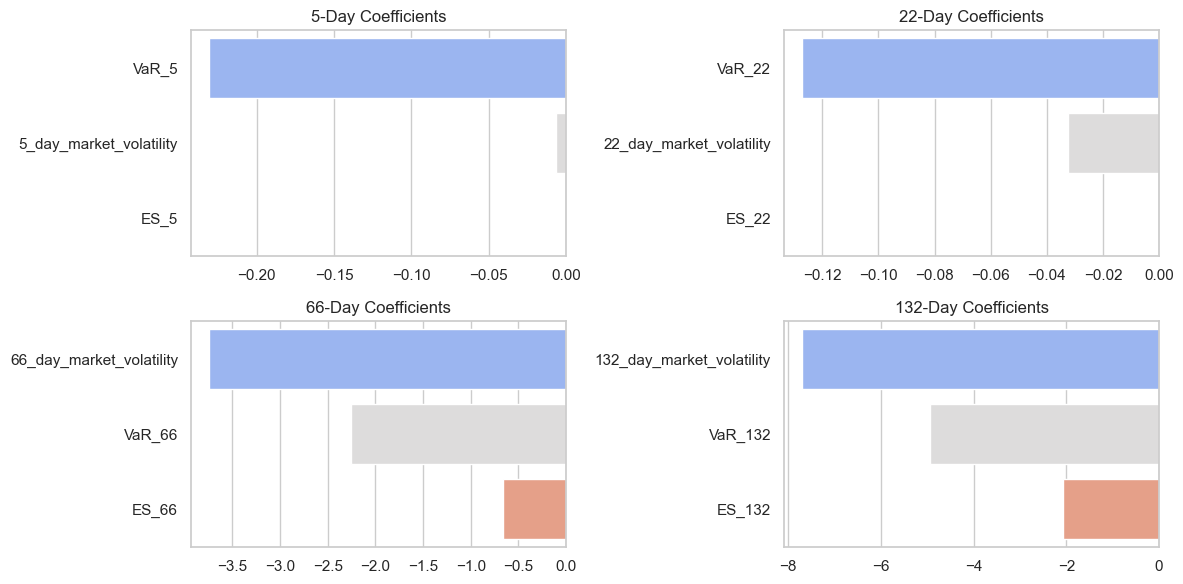

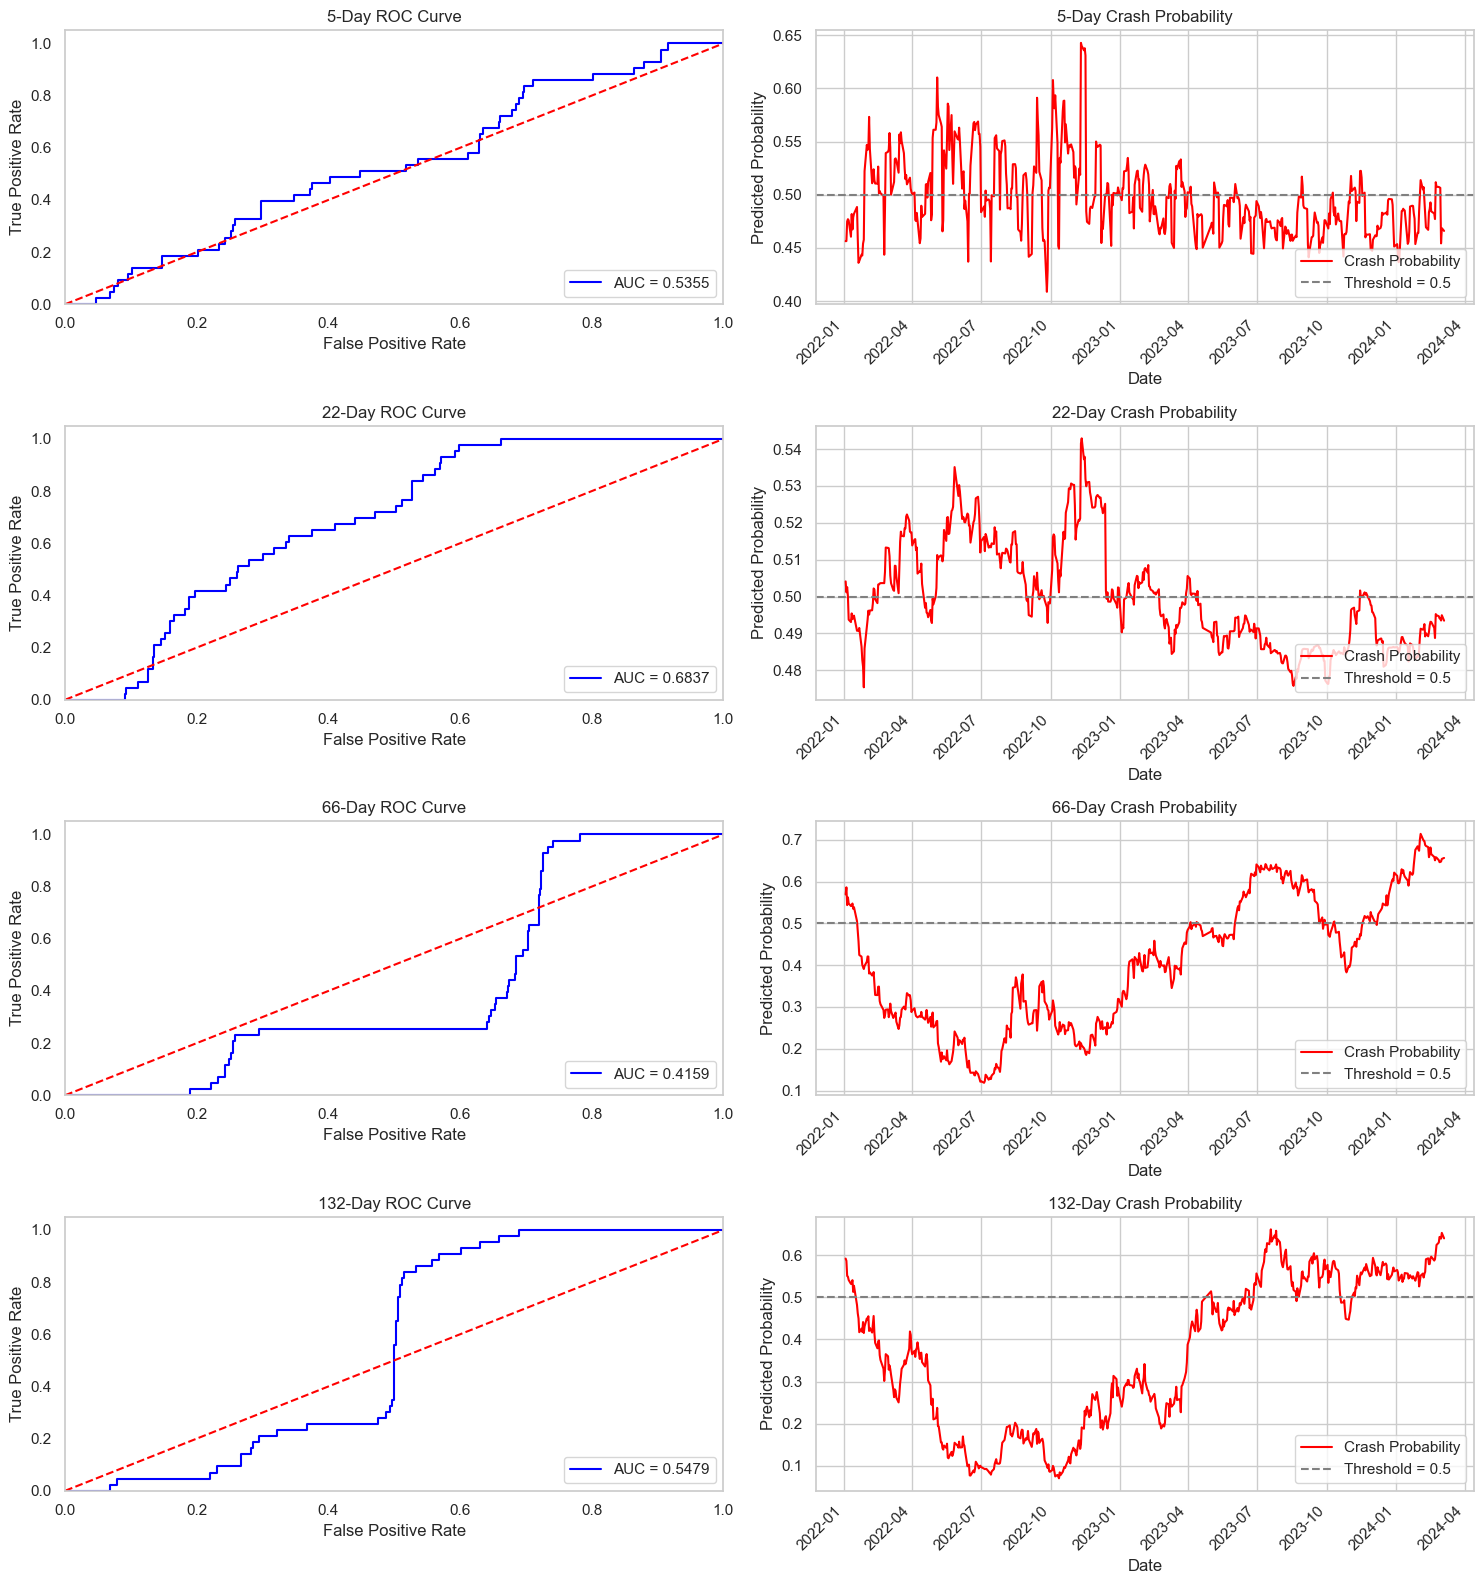

In [37]:
plot_logit_coefficients_grid(static_logit_market)
plot_roc_and_crash_probabilities_grid(static_logit_market, X_test_dict, y_test_dict)

### Static Logit Regression (Sentiment)

In [38]:
static_logit_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_sentiment, X_test_dict, y_test_dict)

all_results.append(static_logit_sentiment)


Best threshold: 0.49, F1: 0.23

=== 5-Day Static Logit Model ===
Test AUC: 0.602
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       495
           1       0.21      0.26      0.23        43

    accuracy                           0.86       538
   macro avg       0.57      0.59      0.58       538
weighted avg       0.88      0.86      0.87       538

Best threshold: 0.43, F1: 0.33

=== 22-Day Static Logit Model ===
Test AUC: 0.814
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       495
           1       0.27      0.44      0.33        43

    accuracy                           0.86       538
   macro avg       0.61      0.67      0.63       538
weighted avg       0.89      0.86      0.87       538

Best threshold: 0.54, F1: 0.16

=== 66-Day Static Logit Model ===
Test AUC: 0.293
Classification Report (Test):
           

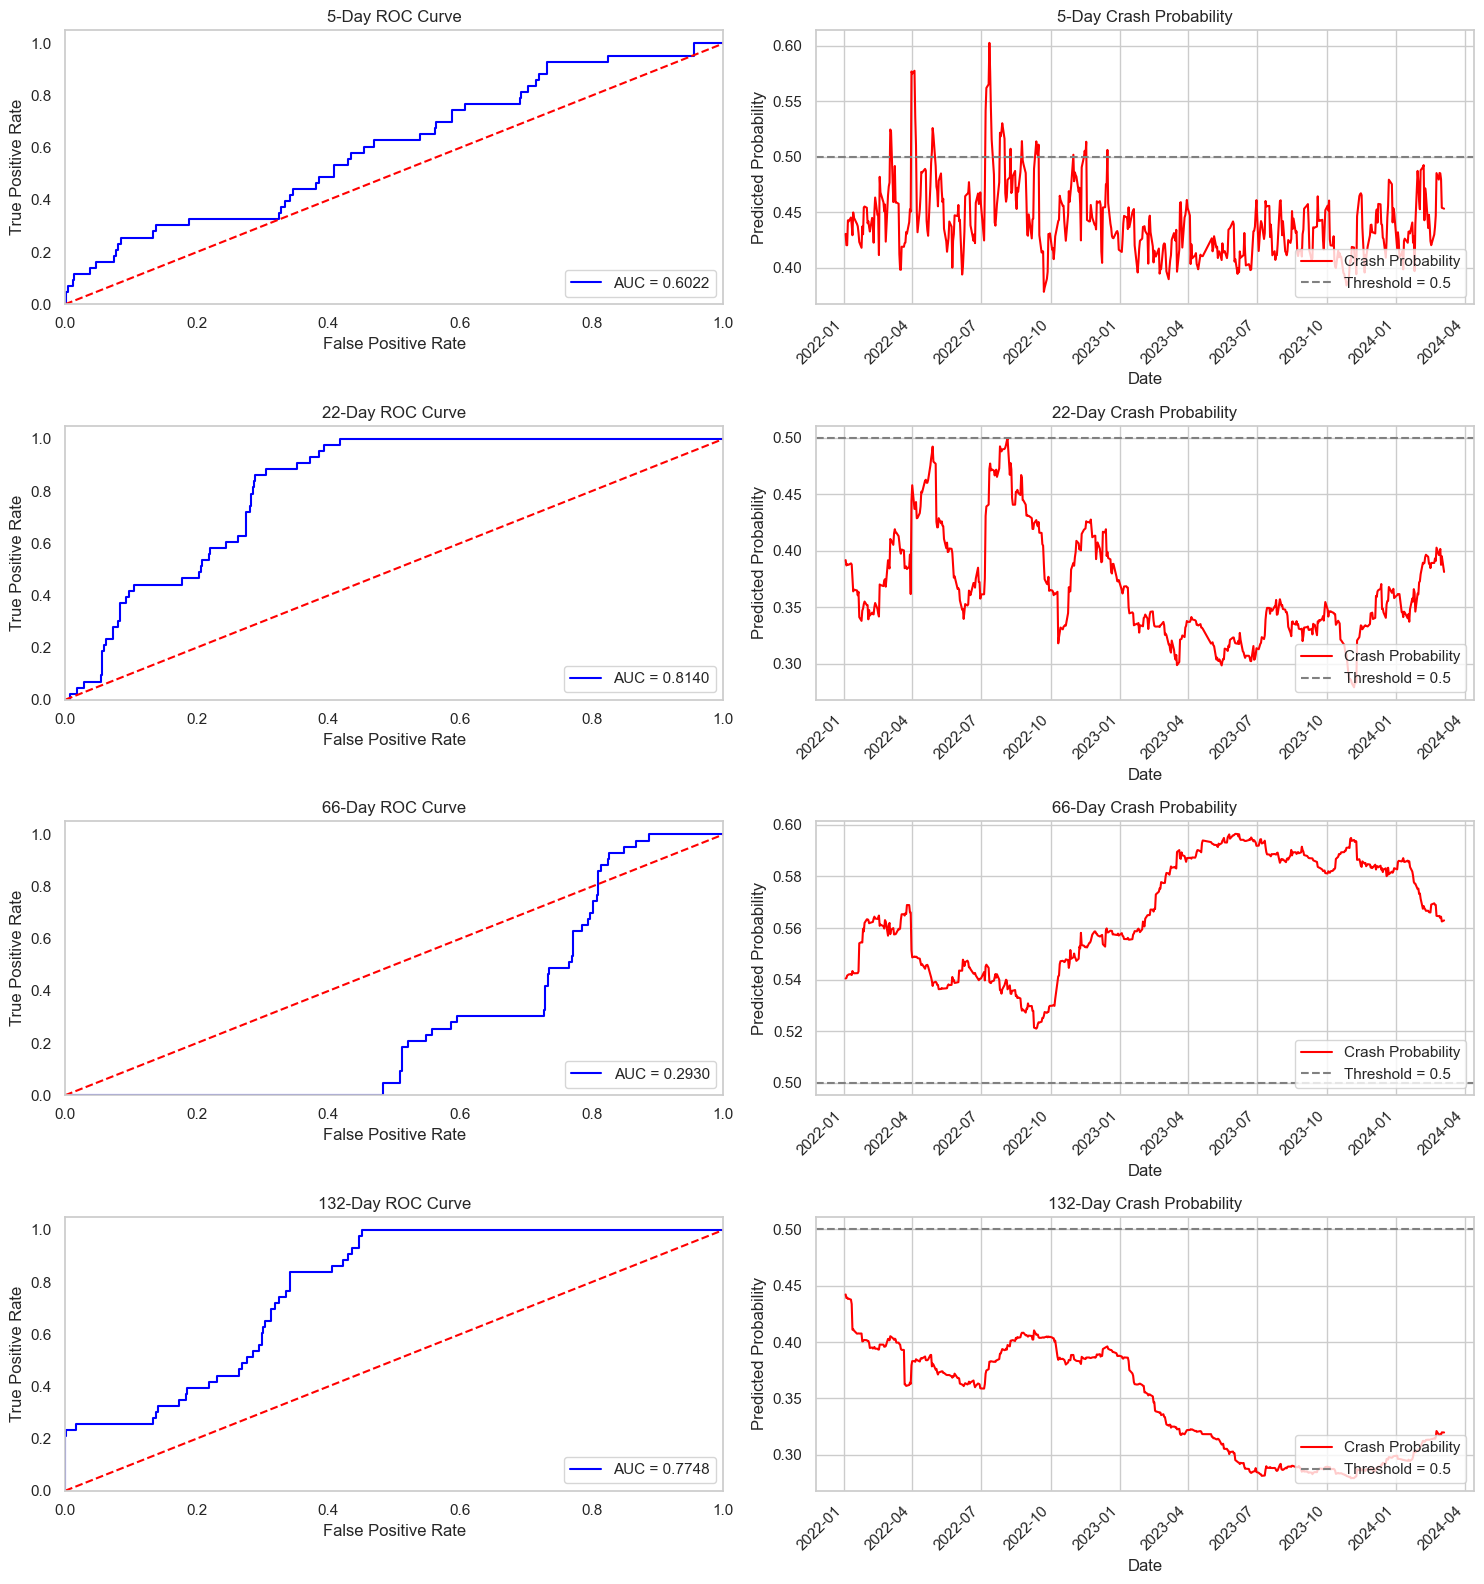

In [39]:
plot_roc_and_crash_probabilities_grid(static_logit_sentiment, X_test_dict, y_test_dict)

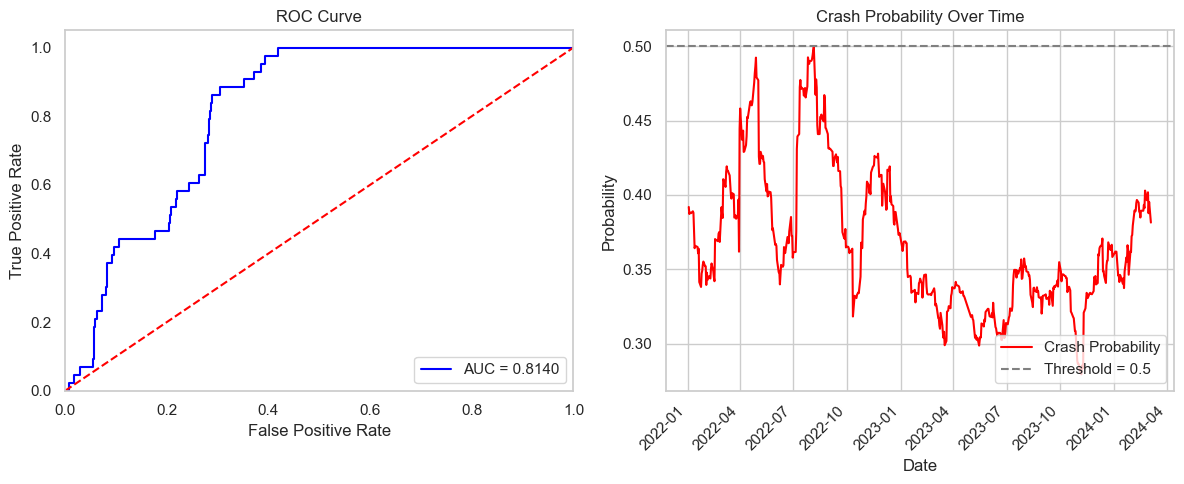

In [40]:
plot_logit_roc_and_crash_prob_for_one(static_logit_sentiment[22], X_test_dict[22], y_test_dict[22])

### Static Logit Regression (Market + Sentiment)

In [41]:
static_logit_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'{n}_day_sentiment_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    static_logit_regression(n, feature_cols, market_sentiment_data, static_logit_combined, X_test_dict, y_test_dict)

all_results.append(static_logit_combined)

Best threshold: 0.43, F1: 0.21

=== 5-Day Static Logit Model ===
Test AUC: 0.623
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.46      0.62       495
           1       0.12      0.84      0.21        43

    accuracy                           0.49       538
   macro avg       0.54      0.65      0.42       538
weighted avg       0.90      0.49      0.59       538

Best threshold: 0.38, F1: 0.35

=== 22-Day Static Logit Model ===
Test AUC: 0.828
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.74      0.84       495
           1       0.22      0.86      0.35        43

    accuracy                           0.75       538
   macro avg       0.60      0.80      0.60       538
weighted avg       0.92      0.75      0.80       538

Best threshold: 0.29, F1: 0.19

=== 66-Day Static Logit Model ===
Test AUC: 0.405
Classification Report (Test):
           

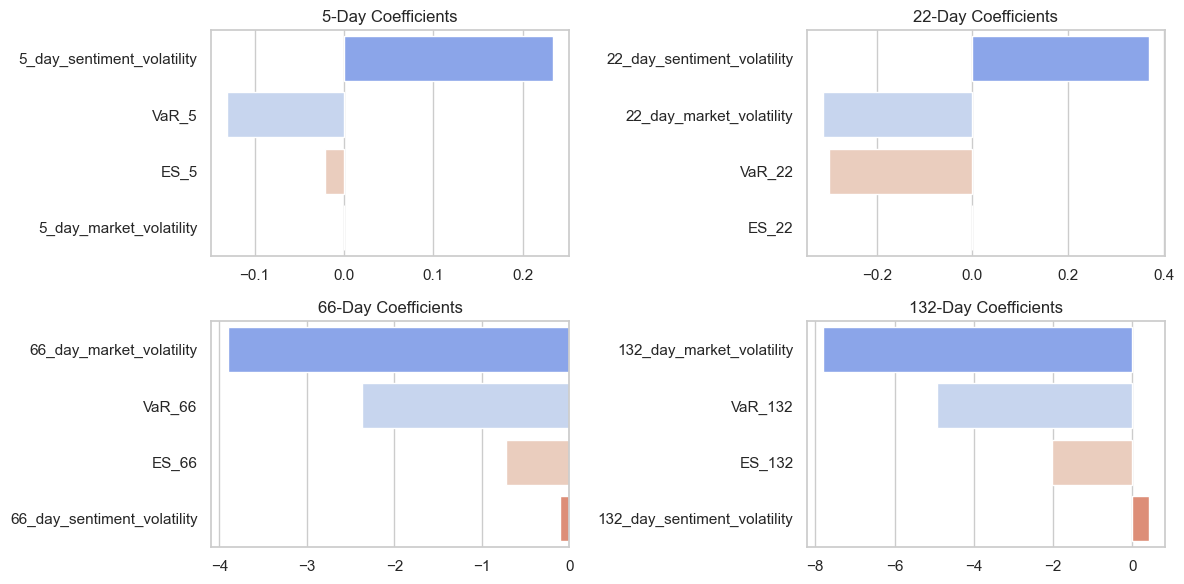

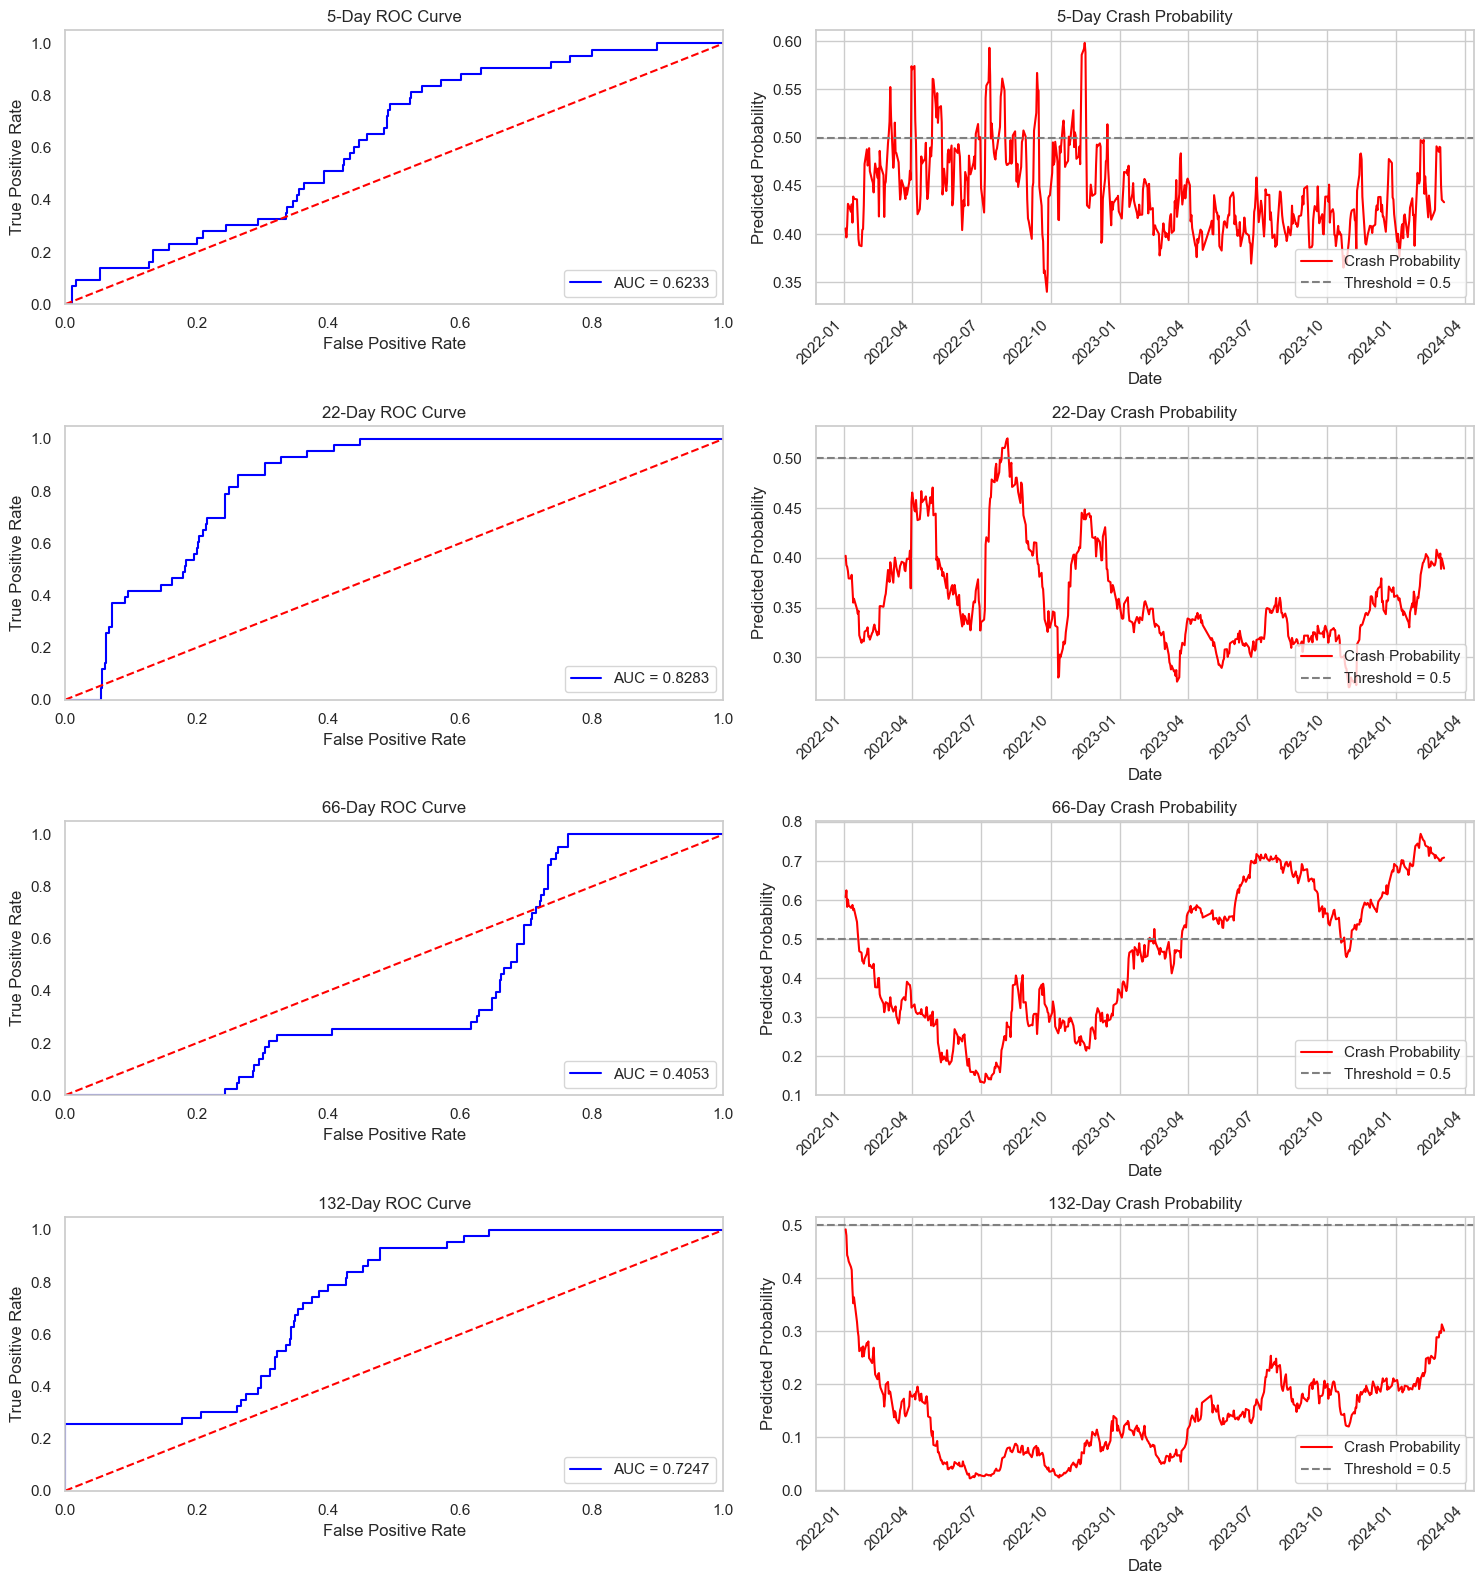

In [42]:
plot_logit_coefficients_grid(static_logit_combined)
plot_roc_and_crash_probabilities_grid(static_logit_combined, X_test_dict, y_test_dict)

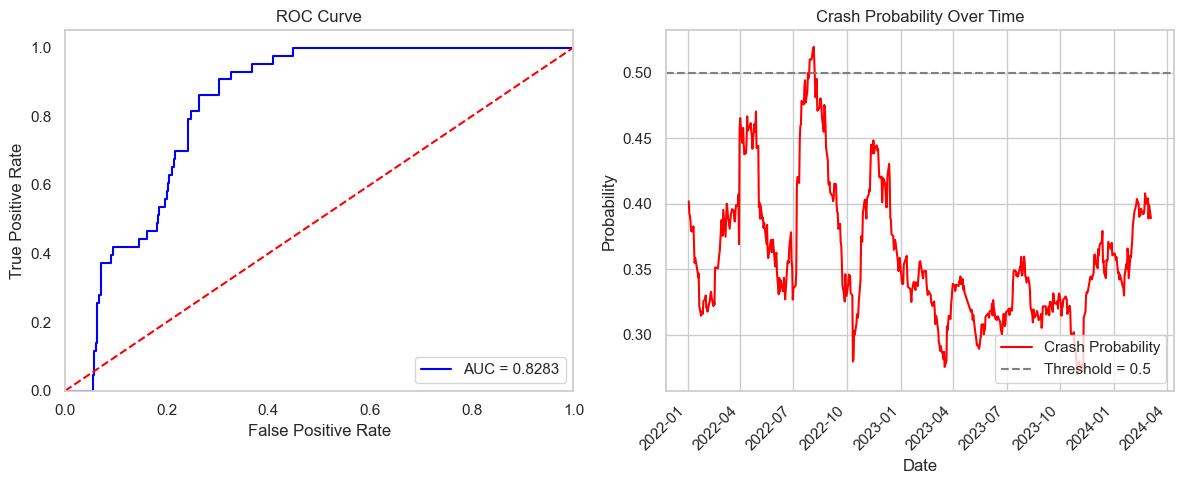

In [43]:
plot_logit_roc_and_crash_prob_for_one(static_logit_combined[22], X_test_dict[22], y_test_dict[22])

## Dynamic Logit Regression

In [44]:
def dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit, X_test_dict, y_test_dict, lag=10):
    market_sentiment_data_with_lags = market_sentiment_data.copy()

    # Add lagged features
    for feat in feature_cols:
        market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

    feature_cols_lag = feature_cols + [f'{f}_lag{lag}' for f in feature_cols]

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols_lag+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols_lag+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols_lag].fillna(train_df[feature_cols_lag].mean())
    y_train = train_df['future_crash']

    X_test = test_df[feature_cols_lag].fillna(train_df[feature_cols_lag].mean())
    y_test = test_df['future_crash']
    
    # Oversample
    sm = SMOTE(random_state=RANDOM_STATE)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
    # X_resampled, y_resampled = X_train.copy(), y_train.copy()

    scaler = StandardScaler()
    X_resampled = scaler.fit_transform(X_resampled)
    X_test = scaler.transform(X_test)

    # Fit Logistic Regression
    logit = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=1000, 
        class_weight='balanced',
        C=1.0,
        l1_ratio=0.5)
    logit.fit(X_resampled, y_resampled)
    # Predict
    y_proba = logit.predict_proba(X_test)[:, 1]
    best_thresh = dynamic_threshold_calculate(y_test, y_proba)
    y_pred = (y_proba >= best_thresh).astype(int)
    # y_pred = logit.predict(X_test)
    
    # Save results
    auc_score = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred)
    date_seq = test_data['Date'].reset_index(drop=True)

    coefficients = pd.DataFrame({
        'Feature': feature_cols_lag,
        'Coefficient': logit.coef_[0]
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    dynamic_logit[n] = {
        'model': logit,
        'auc_score': auc_score,
        'report': report,
        'coefficients': coefficients,
        'confusion': conf,
        'date_seq': date_seq,
        'y_test': y_test,
        'y_prob': y_proba,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day Logit Model with Lag {lag} ===")
    print(f"AUC: {auc_score:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

### Dynamic Logit Regression (Market)

In [45]:
dynamic_logit_market = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_market, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_market)

Best threshold: 0.52, F1: 0.18

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.538
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       495
           1       0.13      0.28      0.18        43

    accuracy                           0.79       538
   macro avg       0.53      0.56      0.53       538
weighted avg       0.87      0.79      0.82       538

Best threshold: 0.48, F1: 0.18

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.501
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       495
           1       0.10      1.00      0.18        43

    accuracy                           0.28       538
   macro avg       0.55      0.61      0.27       538
weighted avg       0.93      0.28      0.34       538

Best threshold: 0.20, F1: 0.18

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.416
Classification Report:
              precision    recal

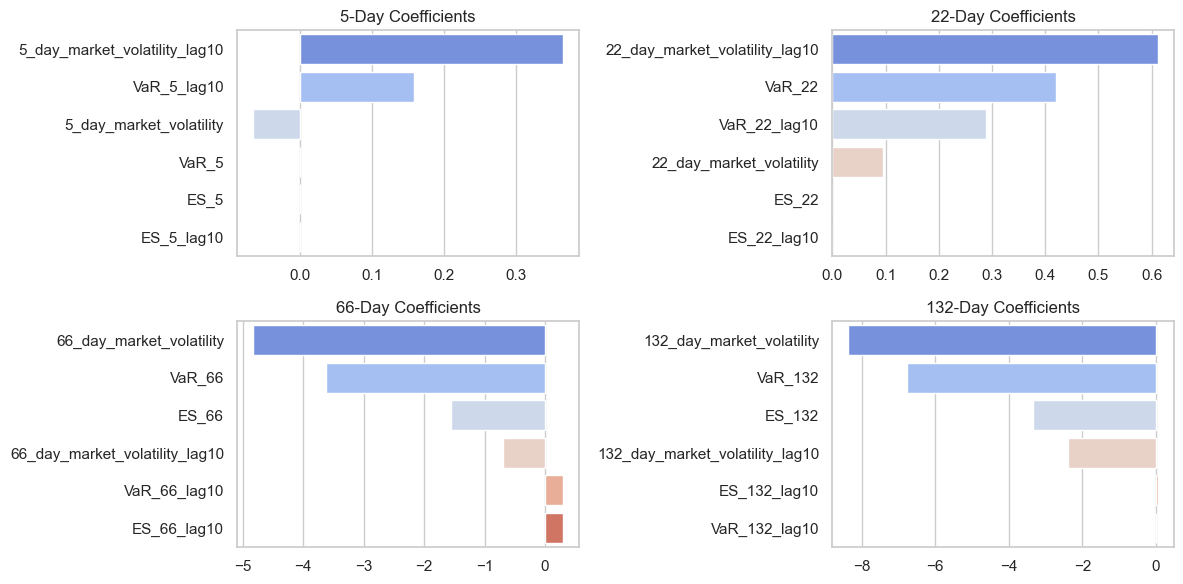

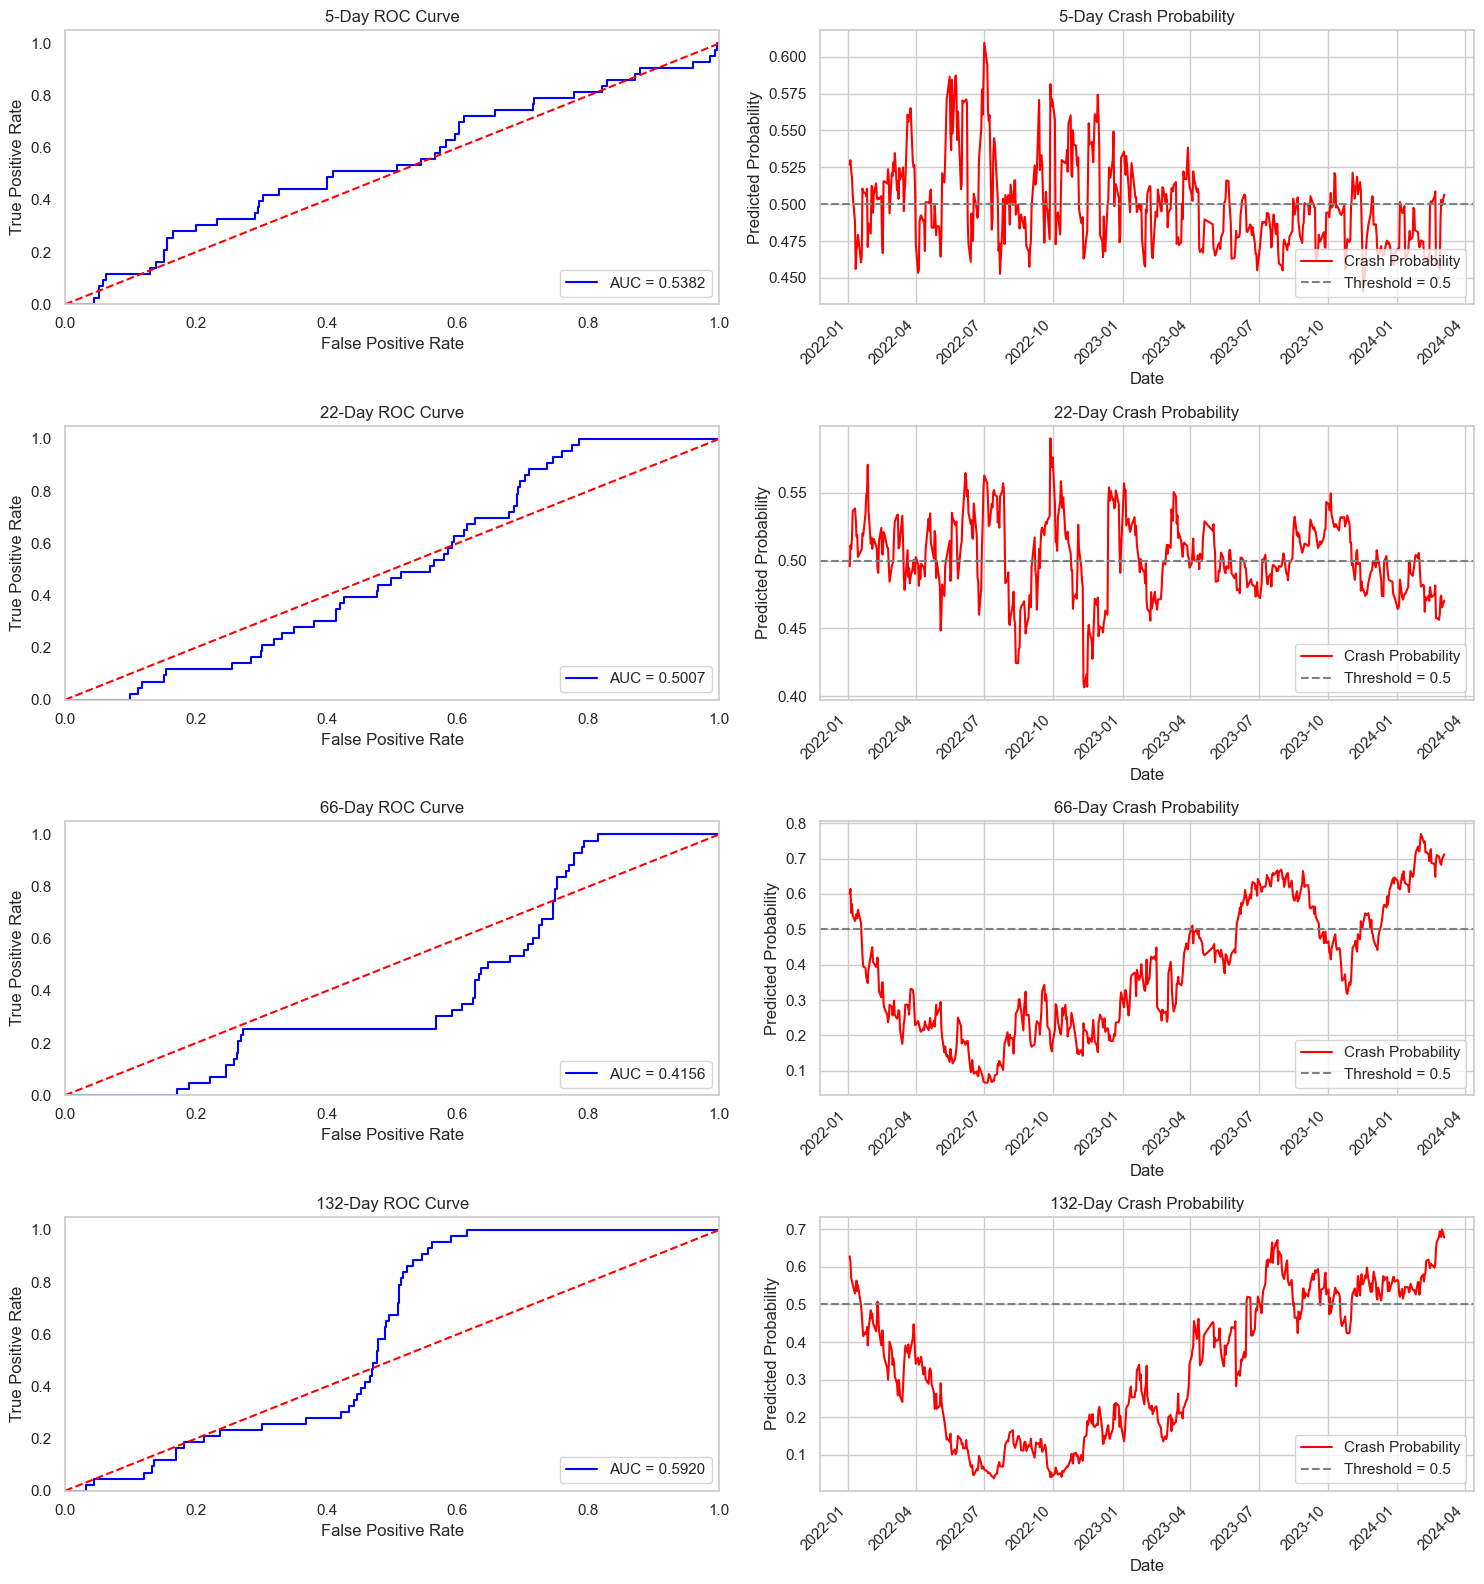

In [46]:
plot_logit_coefficients_grid(dynamic_logit_market)
plot_roc_and_crash_probabilities_grid(dynamic_logit_market, X_test_dict, y_test_dict)

### Dynamic Logit Regression (Sentiment)

In [47]:
dynamic_logit_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_sentiment, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_sentiment)

Best threshold: 0.43, F1: 0.25

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.719
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77       495
           1       0.15      0.72      0.25        43

    accuracy                           0.65       538
   macro avg       0.56      0.68      0.51       538
weighted avg       0.90      0.65      0.73       538

Best threshold: 0.45, F1: 0.35

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.811
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       495
           1       0.30      0.42      0.35        43

    accuracy                           0.88       538
   macro avg       0.62      0.67      0.64       538
weighted avg       0.90      0.88      0.88       538

Best threshold: 0.39, F1: 0.15

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.334
Classification Report:
              precision    recal

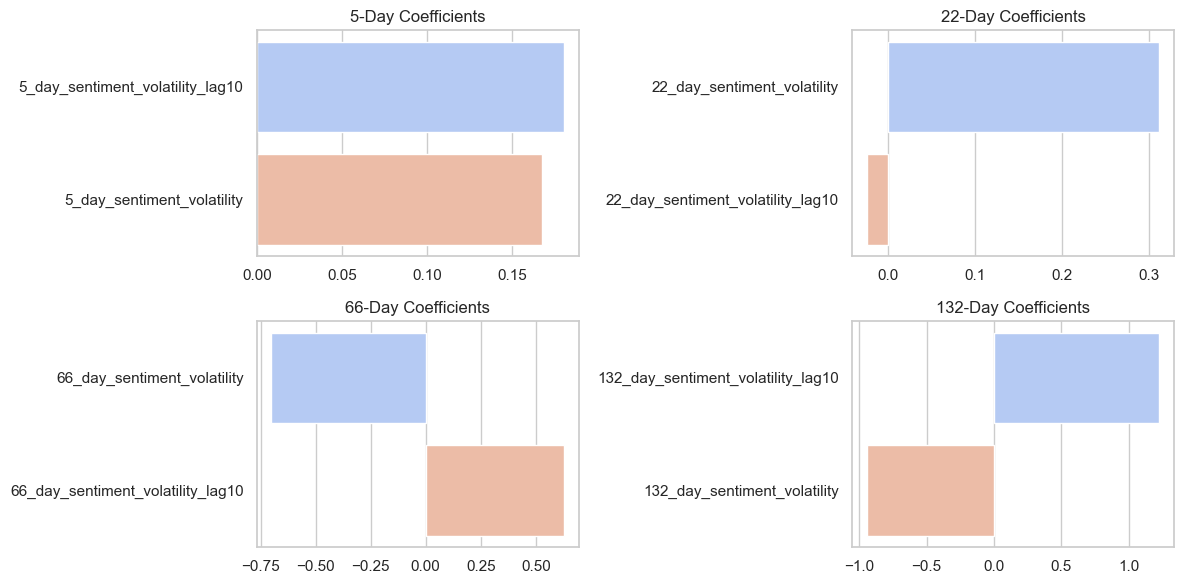

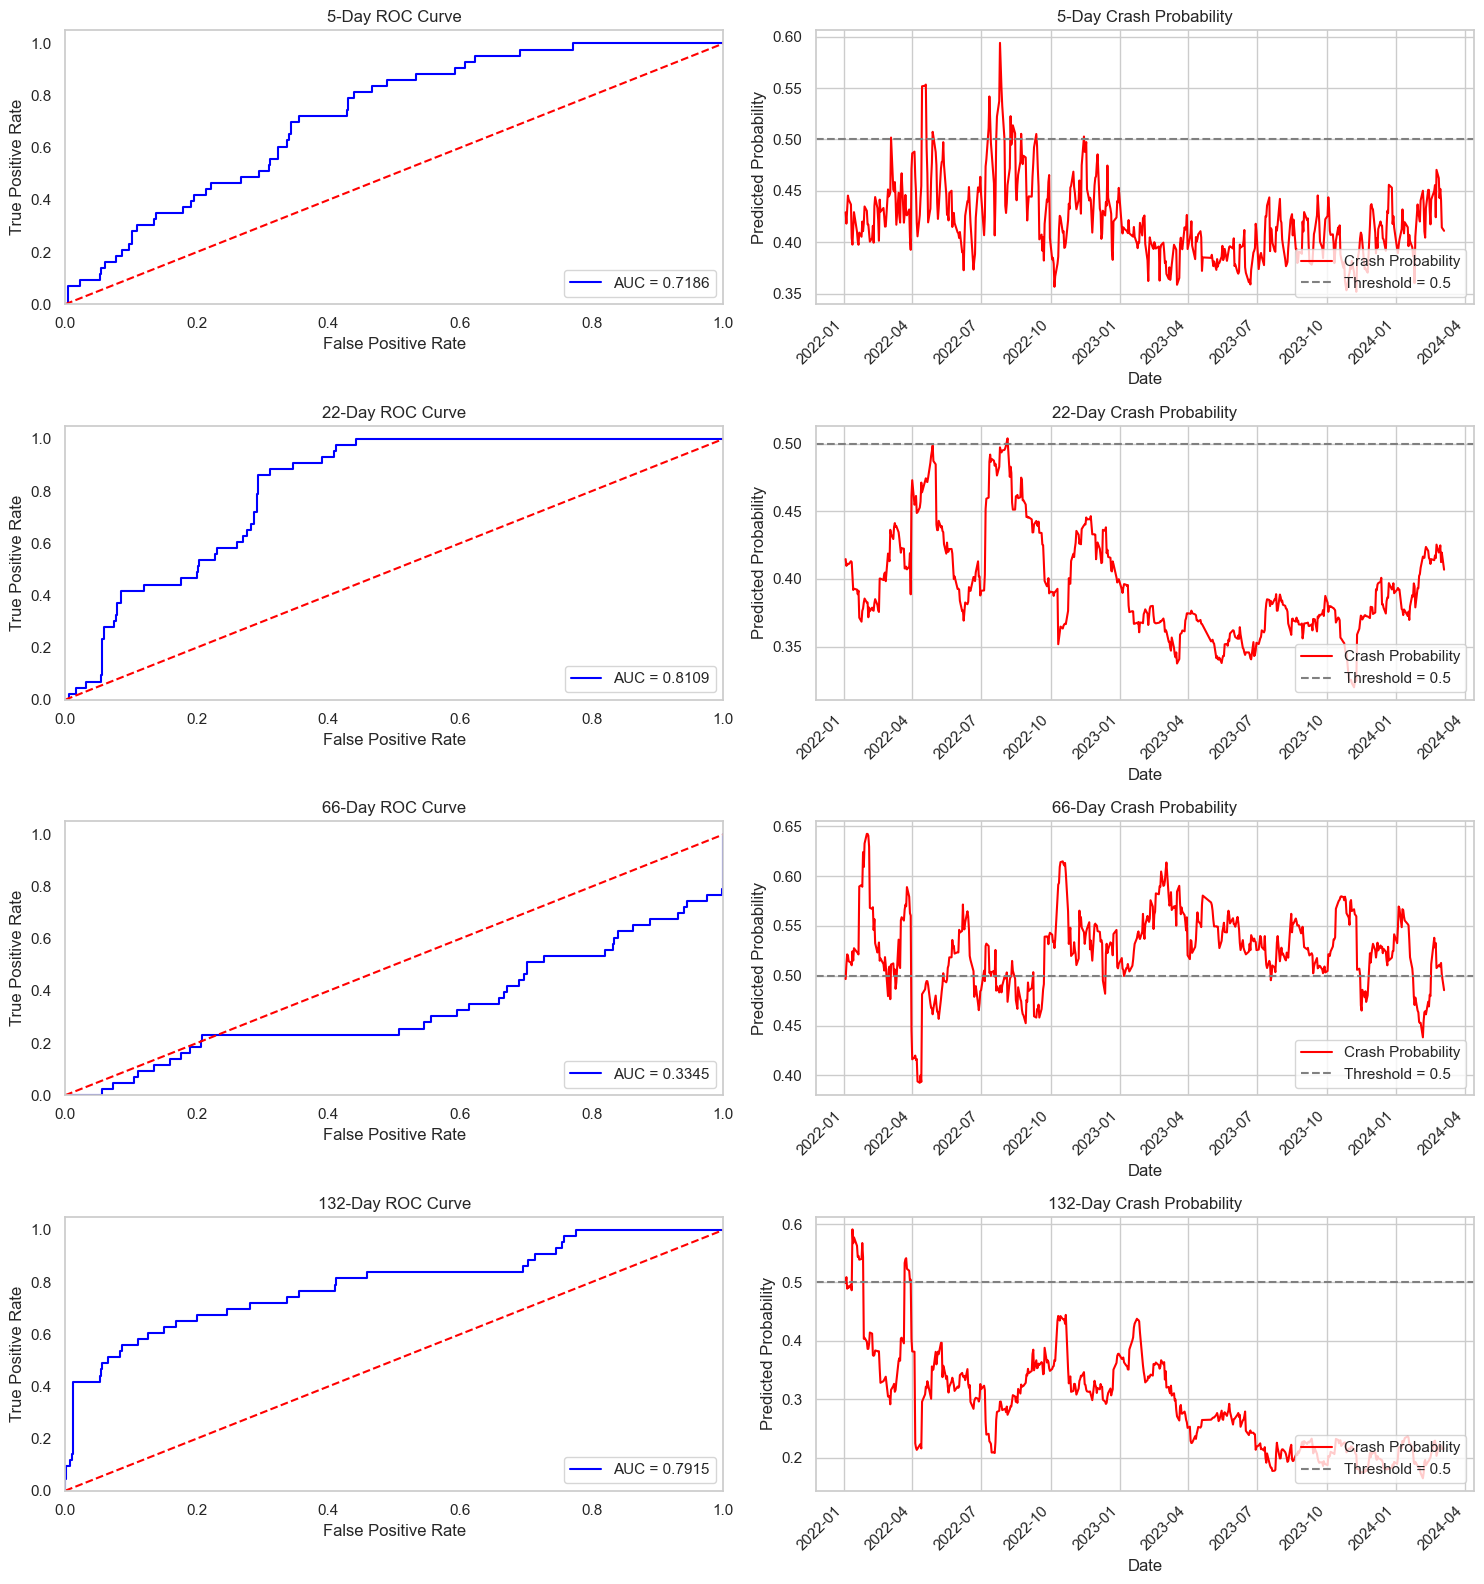

In [48]:
plot_logit_coefficients_grid(dynamic_logit_sentiment)
plot_roc_and_crash_probabilities_grid(dynamic_logit_sentiment, X_test_dict, y_test_dict)

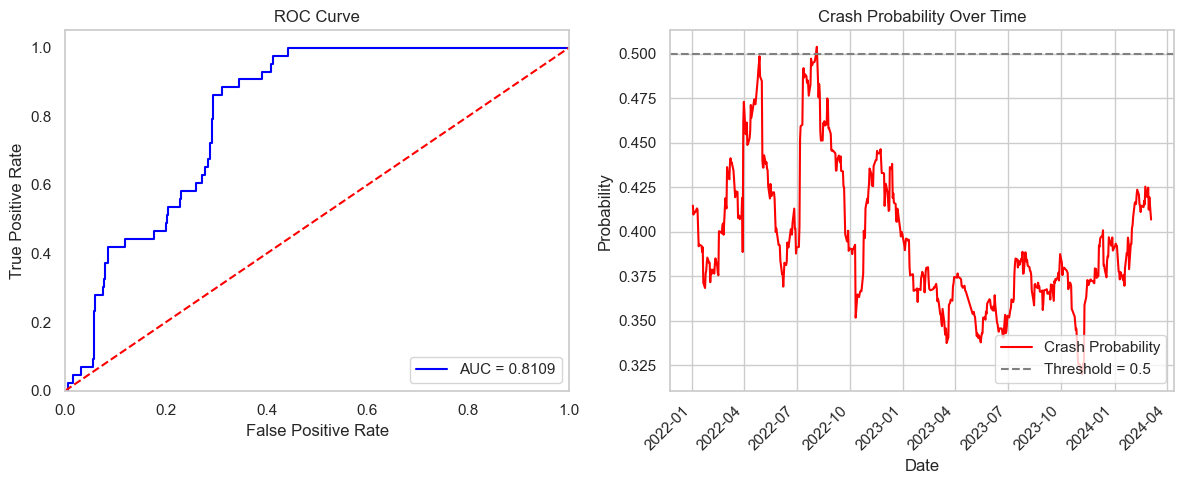

In [49]:
plot_logit_roc_and_crash_prob_for_one(dynamic_logit_sentiment[22], X_test_dict[22], y_test_dict[22])

### Dynamic Logit Regression (Market + Sentiment)

In [113]:
dynamic_logit_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    dynamic_logit_regression(n, feature_cols, market_sentiment_data, dynamic_logit_combined, X_test_dict, y_test_dict, lag=10)

all_results.append(dynamic_logit_combined)

Best threshold: 0.45, F1: 0.25

=== 5-Day Logit Model with Lag 10 ===
AUC: 0.702
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       495
           1       0.17      0.51      0.25        43

    accuracy                           0.76       538
   macro avg       0.56      0.65      0.56       538
weighted avg       0.89      0.76      0.81       538

Best threshold: 0.42, F1: 0.42

=== 22-Day Logit Model with Lag 10 ===
AUC: 0.834
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.32      0.63      0.42        43

    accuracy                           0.86       538
   macro avg       0.64      0.76      0.67       538
weighted avg       0.91      0.86      0.88       538

Best threshold: 0.12, F1: 0.16

=== 66-Day Logit Model with Lag 10 ===
AUC: 0.365
Classification Report:
              precision    recal

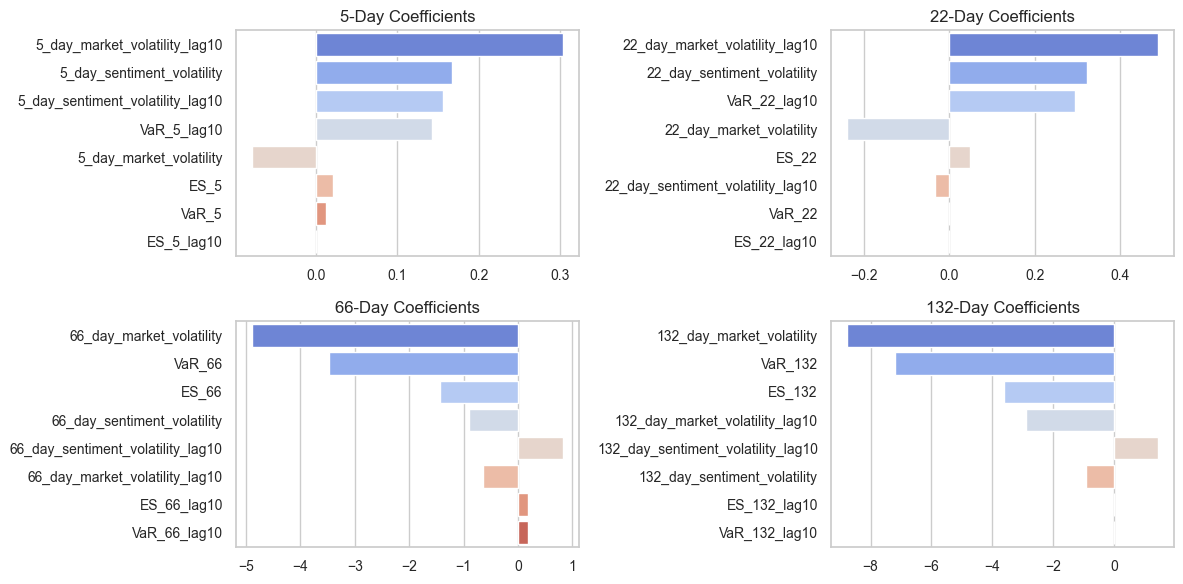

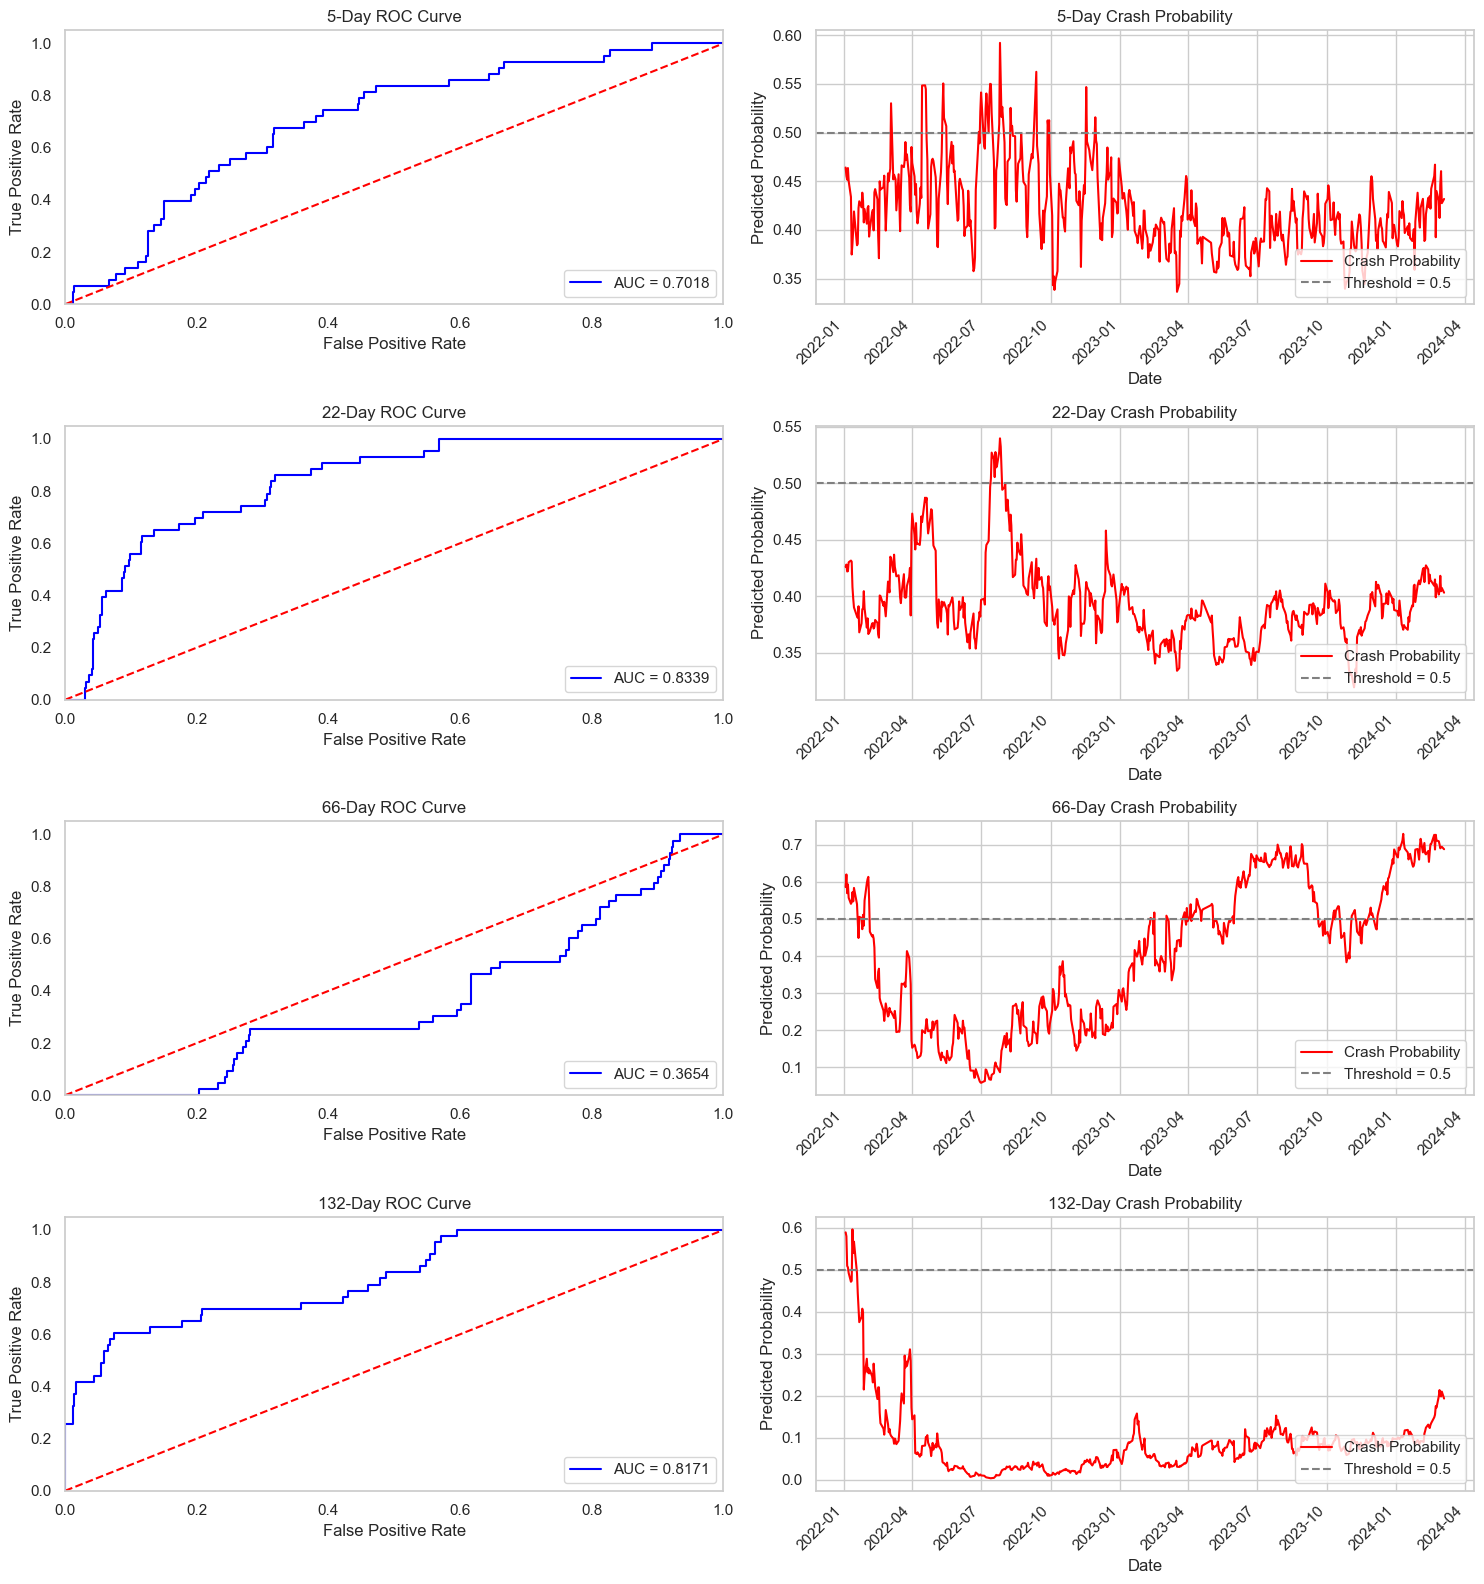

In [ ]:
def plot_logit_coefficients_grid(results):
    num_models = len(results)
    cols = 2
    rows = int(np.ceil(num_models / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))
    axes = axes.flatten()

    for idx, (n, result) in enumerate(sorted(results.items())):
        coefs_df = result['coefficients']

        sns.barplot(
            x='Coefficient',
            y='Feature',
            data=coefs_df,
            ax=axes[idx],
            palette='coolwarm'
        )
        axes[idx].set_title(f'{n}-Day Coefficients')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('')
        axes[idx].tick_params(axis='x', labelsize=10)
        axes[idx].tick_params(axis='y', labelsize=10)

    # Remove unused subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    
plot_logit_coefficients_grid(dynamic_logit_combined)
plot_roc_and_crash_probabilities_grid(dynamic_logit_combined, X_test_dict, y_test_dict)

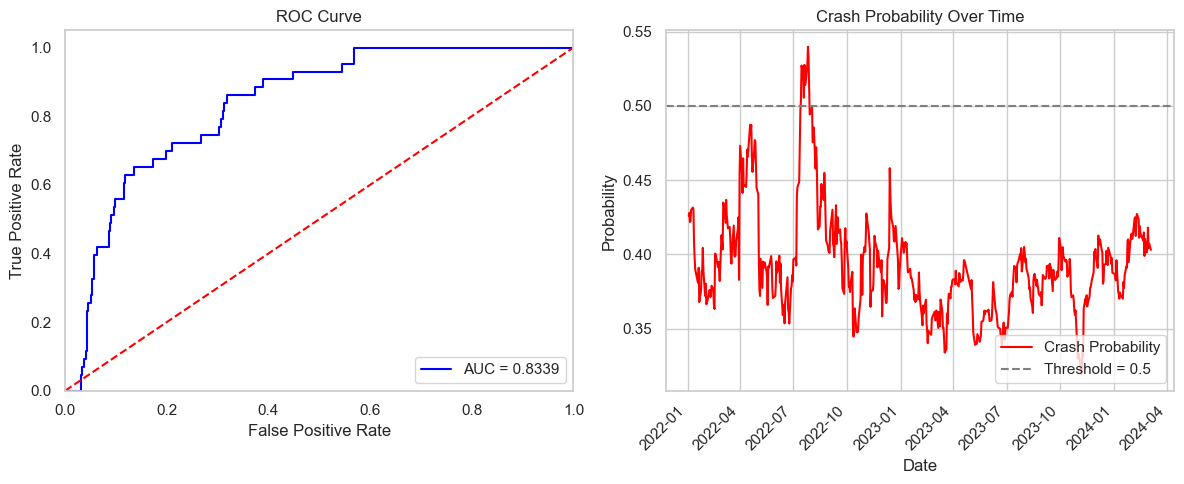

In [52]:
plot_logit_roc_and_crash_prob_for_one(dynamic_logit_combined[22], X_test_dict[22], y_test_dict[22])

## CNN

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.utils import class_weight

def cnn_model(n, feature_cols, market_sentiment_data, cnn_results, X_test_dict, y_test_dict, lag=10, window_size=10):
    market_sentiment_data_with_lags = market_sentiment_data.copy()

    # # Add lagged features
    # for feat in feature_cols:
    #     market_sentiment_data_with_lags[f'{feat}_lag{lag}'] = market_sentiment_data[feat].shift(lag)

    # feature_cols = feature_cols + [f'{f}_lag{lag}' for f in feature_cols]    

    train_data = market_sentiment_data_with_lags[market_sentiment_data_with_lags['Date'] < '2022-01-01']
    test_data = market_sentiment_data_with_lags[(market_sentiment_data_with_lags['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train_seq, y_train_seq, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test_seq, y_test_seq, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)

    # Define CNN model
    cnn_model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    class_weights_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_seq),
        y=y_train_seq
    )
    class_weight_dict = dict(enumerate(class_weights_array))

    # Train
    cnn_model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=0, 
                class_weight=class_weight_dict)

    y_prob = cnn_model.predict(X_test_seq).flatten()
    best_threshold = dynamic_threshold_calculate(y_test_seq, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc_score = roc_auc_score(y_test_seq, y_prob)
    report = classification_report(y_test_seq, y_pred, output_dict=True)
    conf = confusion_matrix(y_test_seq, y_pred)
    date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)
    
    # Save model and results
    cnn_results[n] = {
        'model': cnn_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test_seq,
        'y_prob': y_prob,
        'features': feature_cols,
        'confusion': conf,
        'date_seq': date_seq,
    }

    X_test_dict[n] = X_test_seq
    y_test_dict[n] = y_test_seq

    print(f"\n=== {n}-Day CNN Model ===")
    print(f"AUC: {auc_score:.3f}")
    print(classification_report(y_test_seq, y_pred))

### CNN (Market)

In [54]:
cnn_market = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_market, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_market)    

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.34, F1: 0.16

=== 5-Day CNN Model ===
AUC: 0.564
              precision    recall  f1-score   support

           0       0.99      0.32      0.49       495
           1       0.08      0.94      0.16        33

    accuracy                           0.36       528
   macro avg       0.54      0.63      0.32       528
weighted avg       0.93      0.36      0.47       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.53, F1: 0.23

=== 22-Day CNN Model ===
AUC: 0.711
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       495
           1       0.14      0.48      0.22        33

    accuracy                           0.78       528
   macro avg       0.55      0.64      0.54       528
weighted avg       0.91      0.78      0.83       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.01, F1: 0.17

=== 66-Day CNN Model ===
AUC: 0.409
              precision   

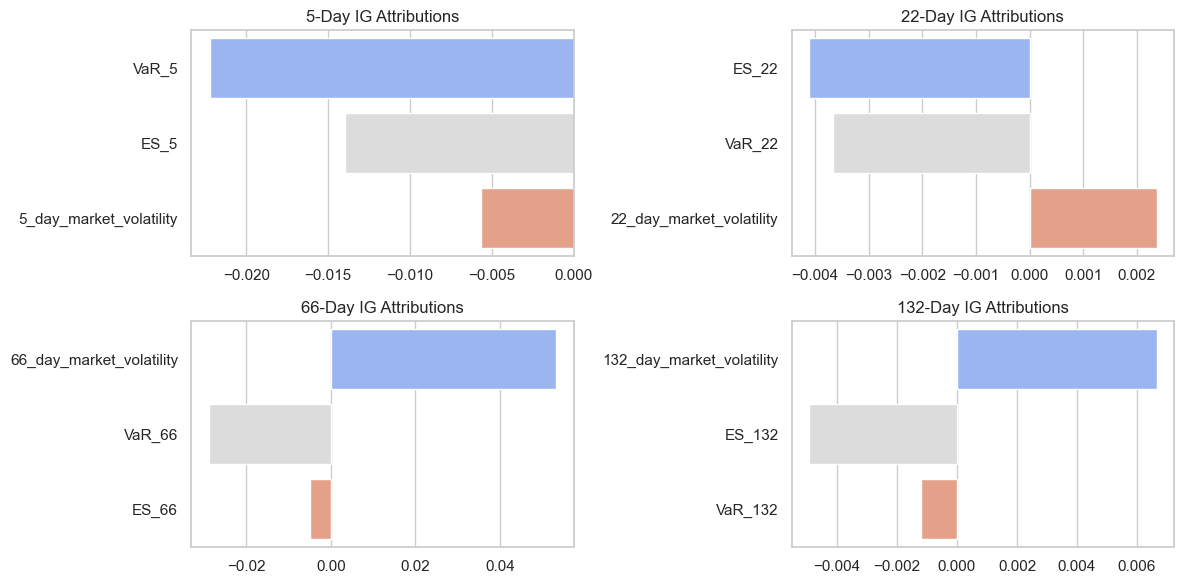

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


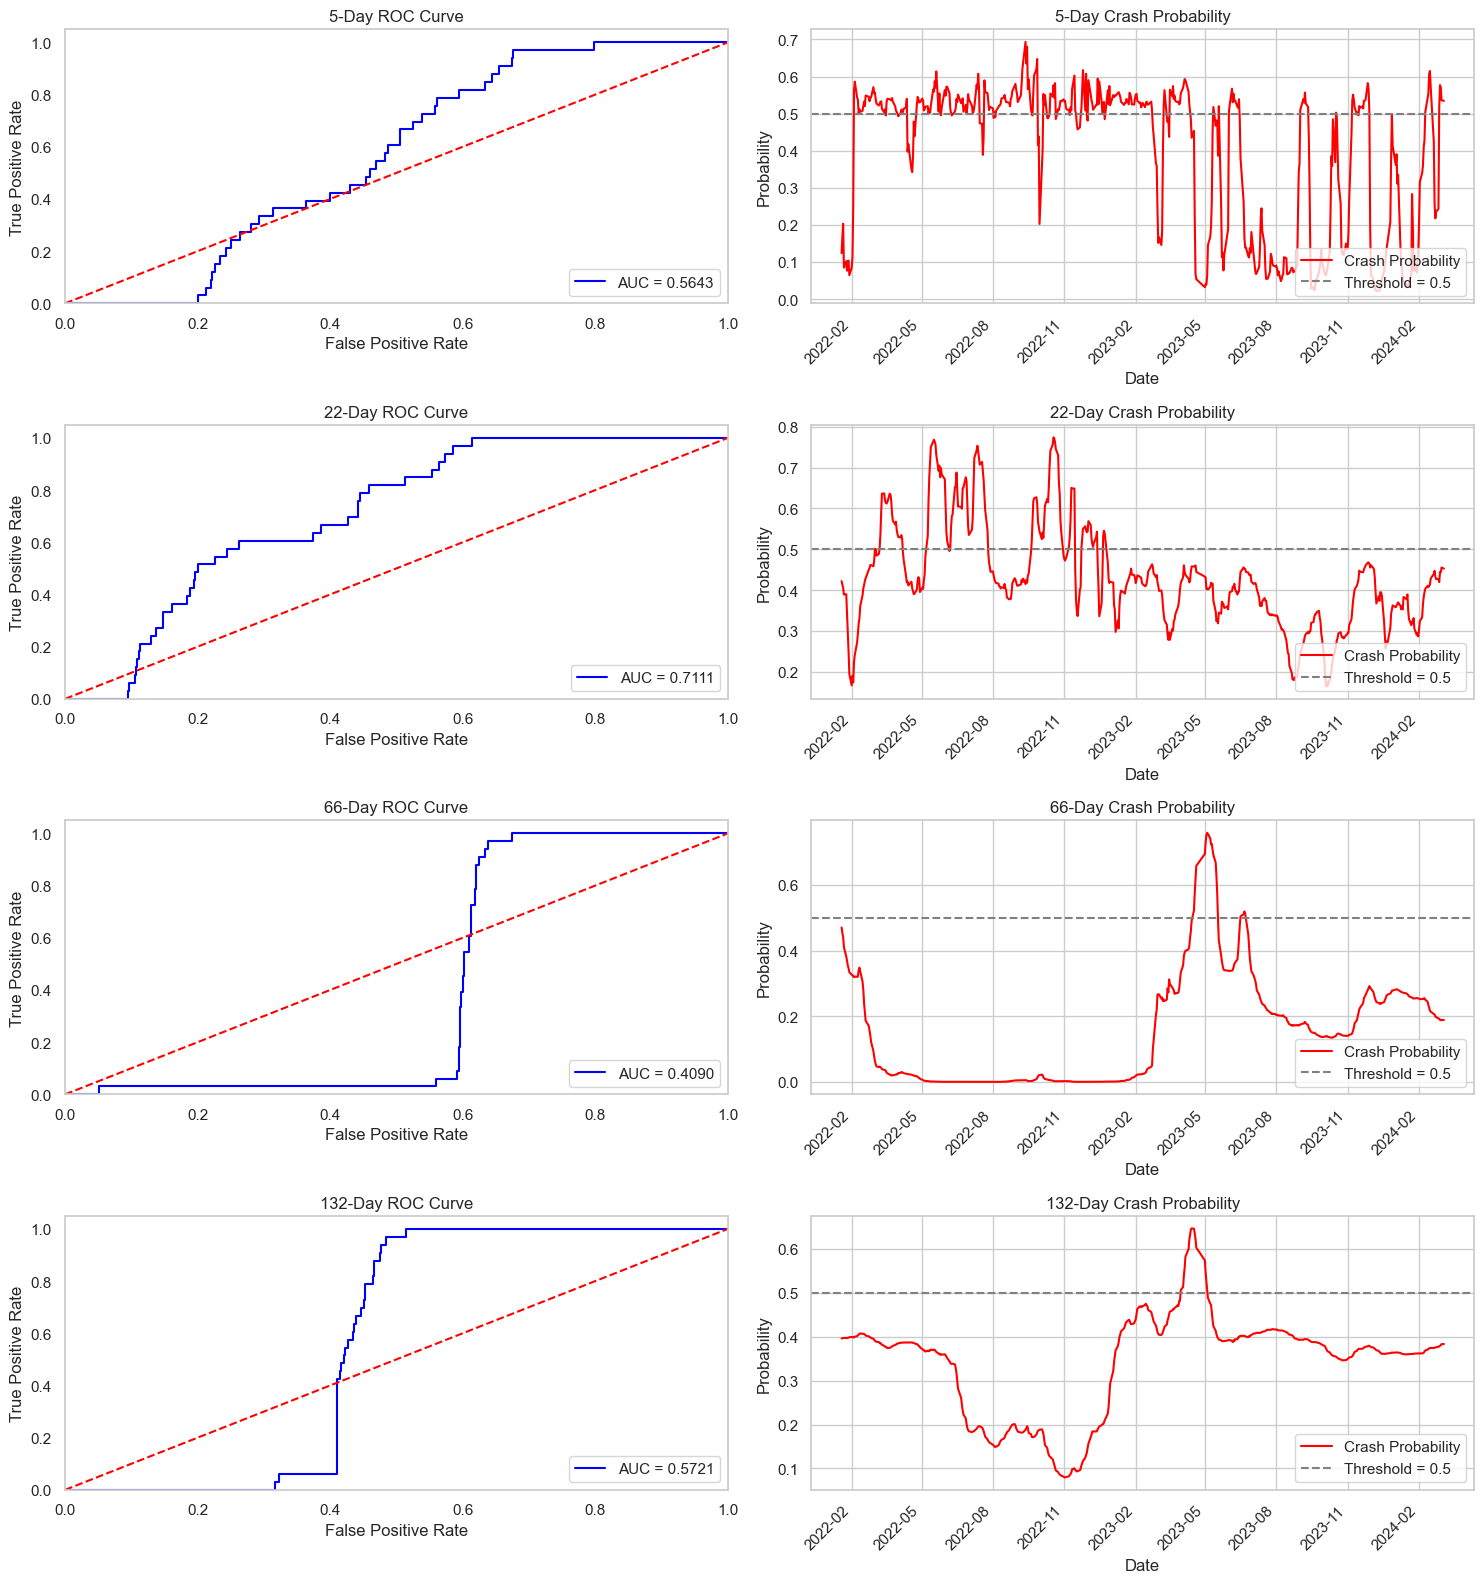

In [55]:
plot_ig_feature_attributions_grid(cnn_market, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(cnn_market, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


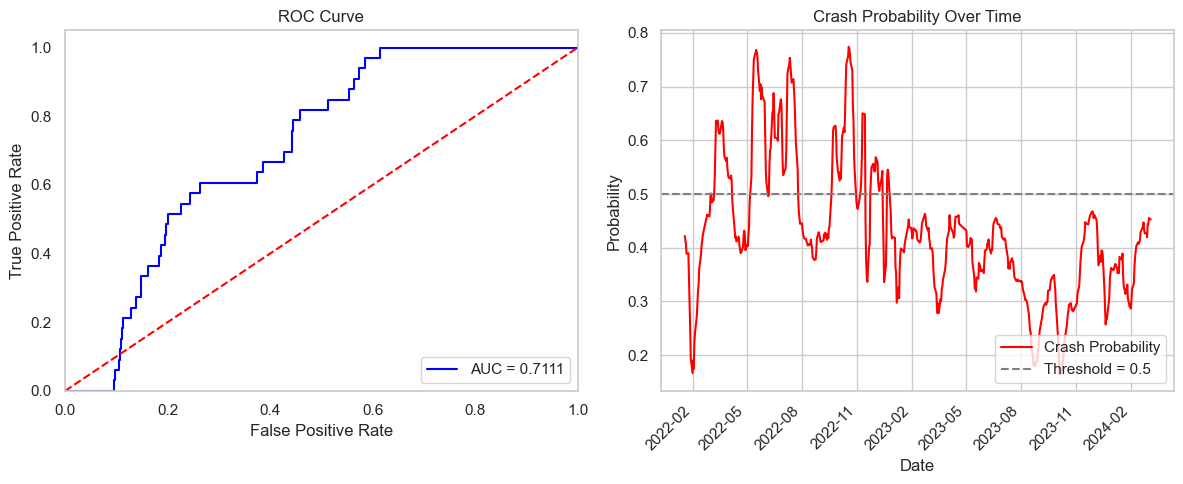

In [56]:
plot_CNN_roc_and_crash_prob_for_one(cnn_market[22], X_test_dict[22], y_test_dict[22])

### CNN (Sentiment)

In [57]:
cnn_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_sentiment, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_sentiment)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.02, F1: 0.24

=== 5-Day CNN Model ===
AUC: 0.662
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       495
           1       0.15      0.52      0.23        33

    accuracy                           0.79       528
   macro avg       0.56      0.66      0.55       528
weighted avg       0.91      0.79      0.84       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.04, F1: 0.32

=== 22-Day CNN Model ===
AUC: 0.836
              precision    recall  f1-score   support

           0       0.99      0.73      0.84       495
           1       0.19      0.94      0.31        33

    accuracy                           0.74       528
   macro avg       0.59      0.83      0.58       528
weighted avg       0.94      0.74      0.81       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.03, F1: 0.21

=== 66-Day CNN Model ===
AUC: 0.649
              precision   

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


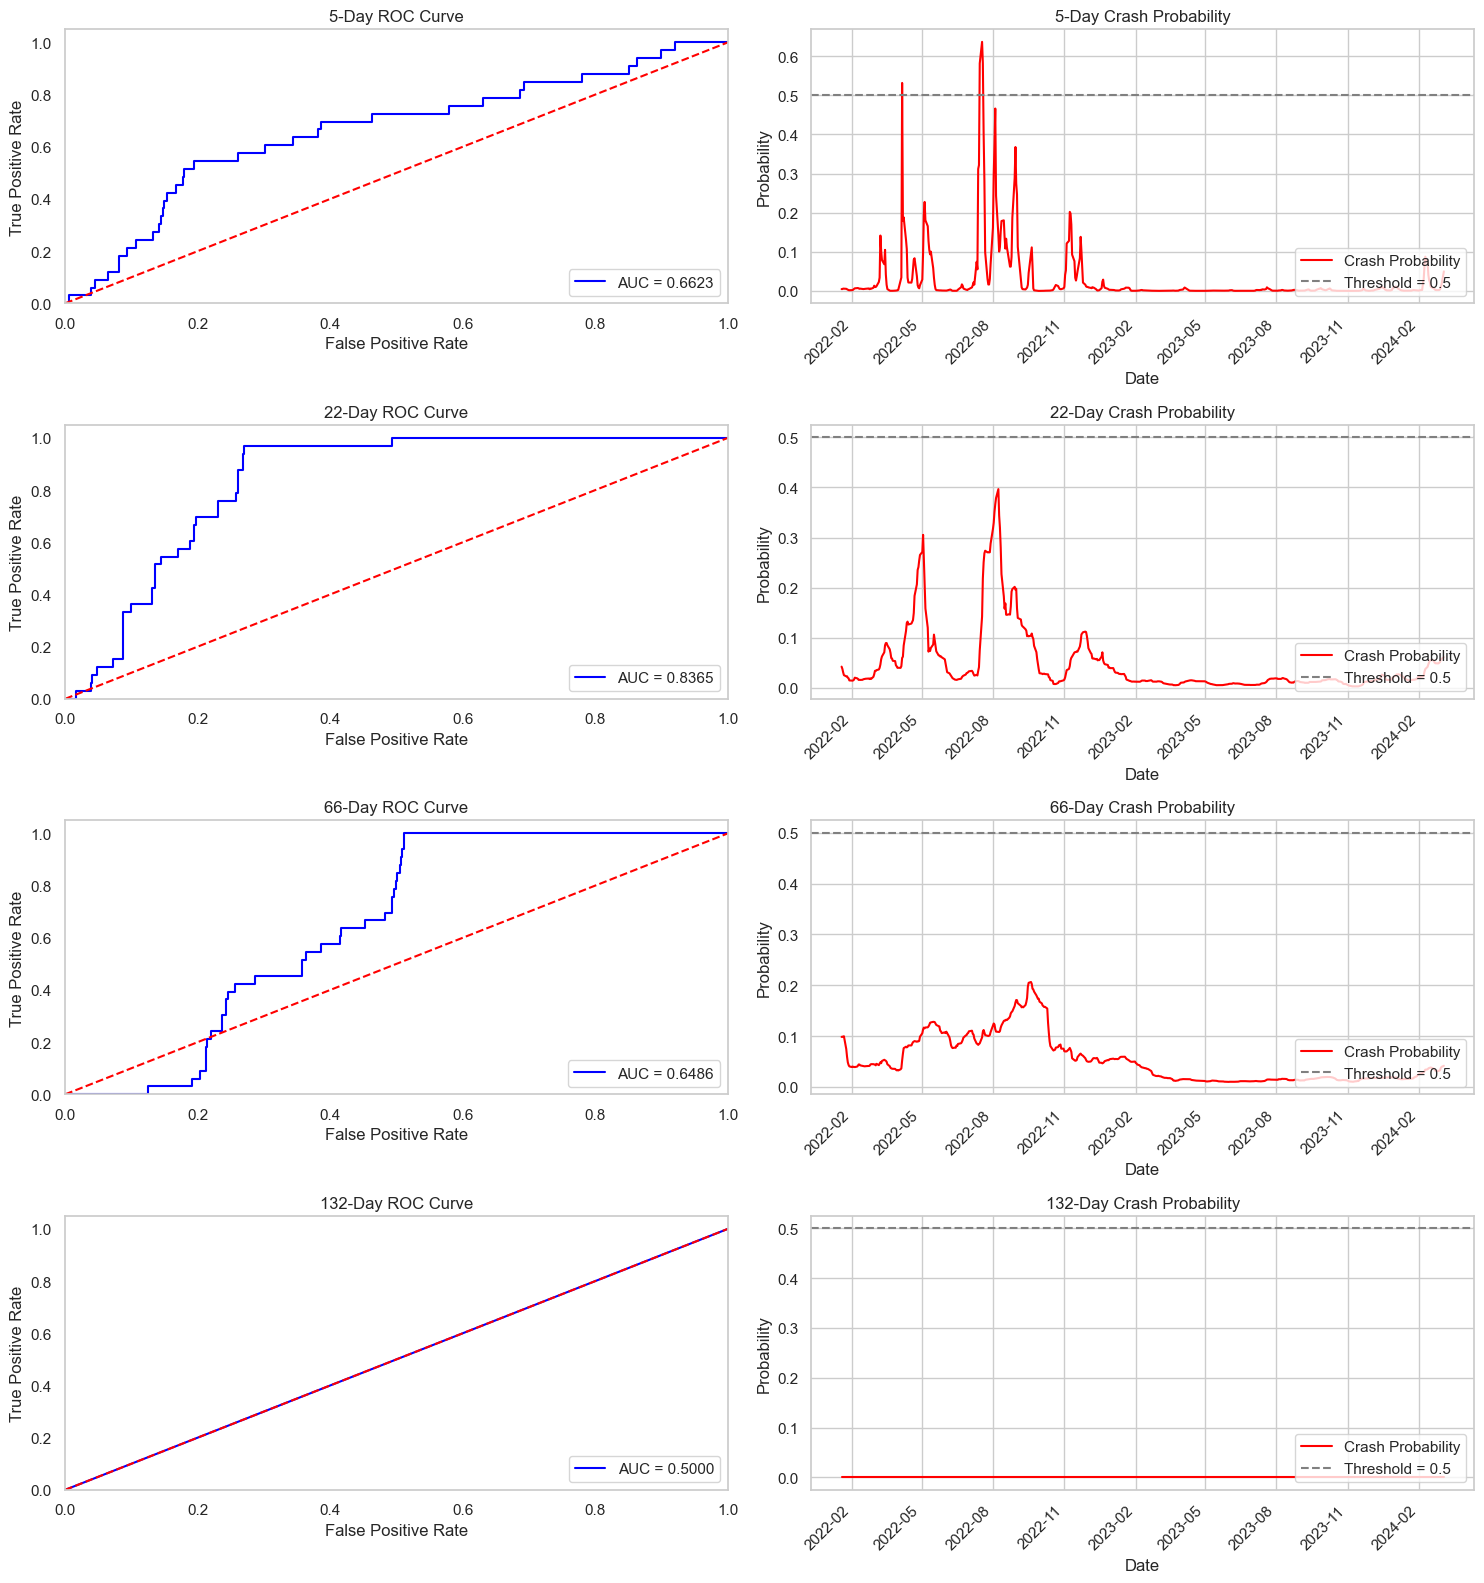

In [58]:
plot_CNN_roc_and_crash_probabilities(cnn_sentiment, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


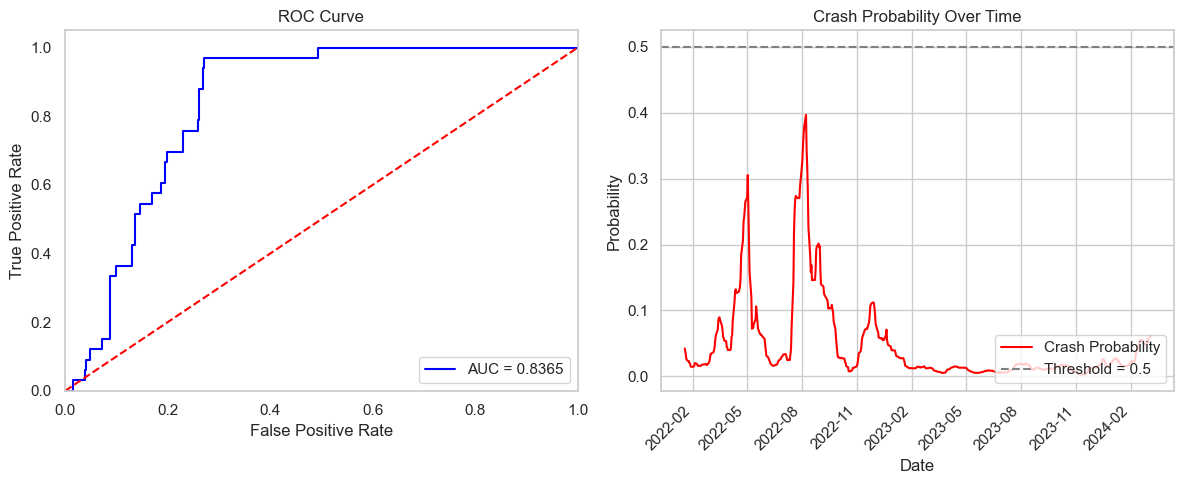

In [59]:
plot_CNN_roc_and_crash_prob_for_one(cnn_sentiment[22], X_test_dict[22], y_test_dict[22])

### CNN (Market + Sentiment)

In [91]:
cnn_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_combined, X_test_dict, y_test_dict, lag=10, window_size=window_size)

all_results.append(cnn_combined)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.01, F1: 0.30

=== 5-Day CNN Model ===
AUC: 0.647
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       495
           1       0.22      0.42      0.29        33

    accuracy                           0.87       528
   macro avg       0.59      0.66      0.61       528
weighted avg       0.91      0.87      0.89       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best threshold: 0.00, F1: 0.21

=== 22-Day CNN Model ===
AUC: 0.678
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       495
           1       0.13      0.33      0.19        33

    accuracy                           0.82       528
   macro avg       0.54      0.59      0.55       528
weighted avg       0.90      0.82      0.86       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best threshold: 0.00, F1: 0.17

=== 66-Day CNN Model ===
AUC: 0.589
              precision   

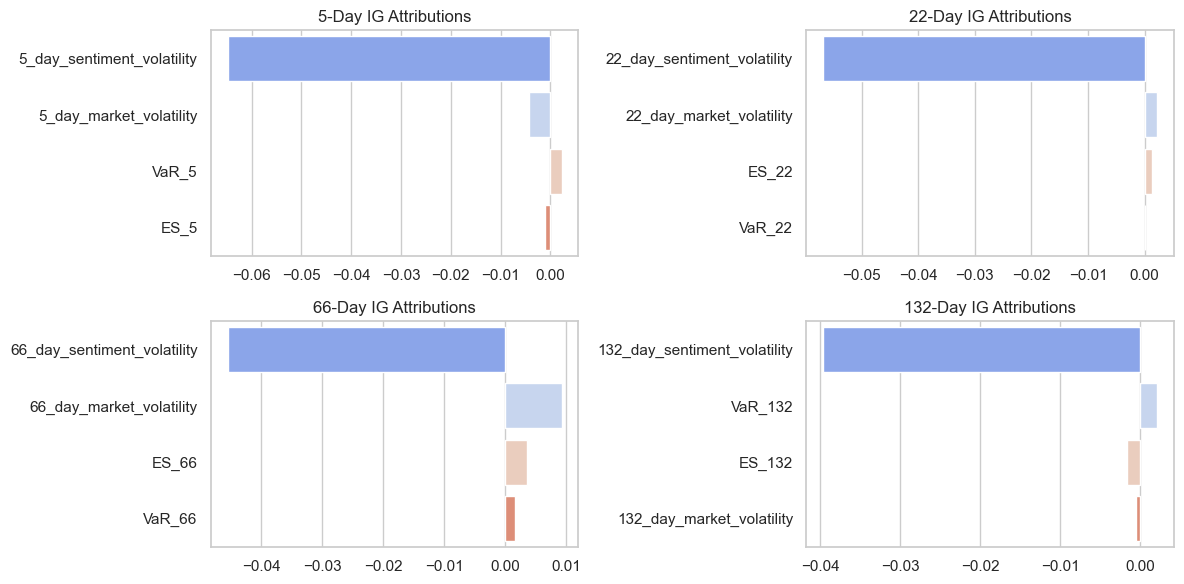

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


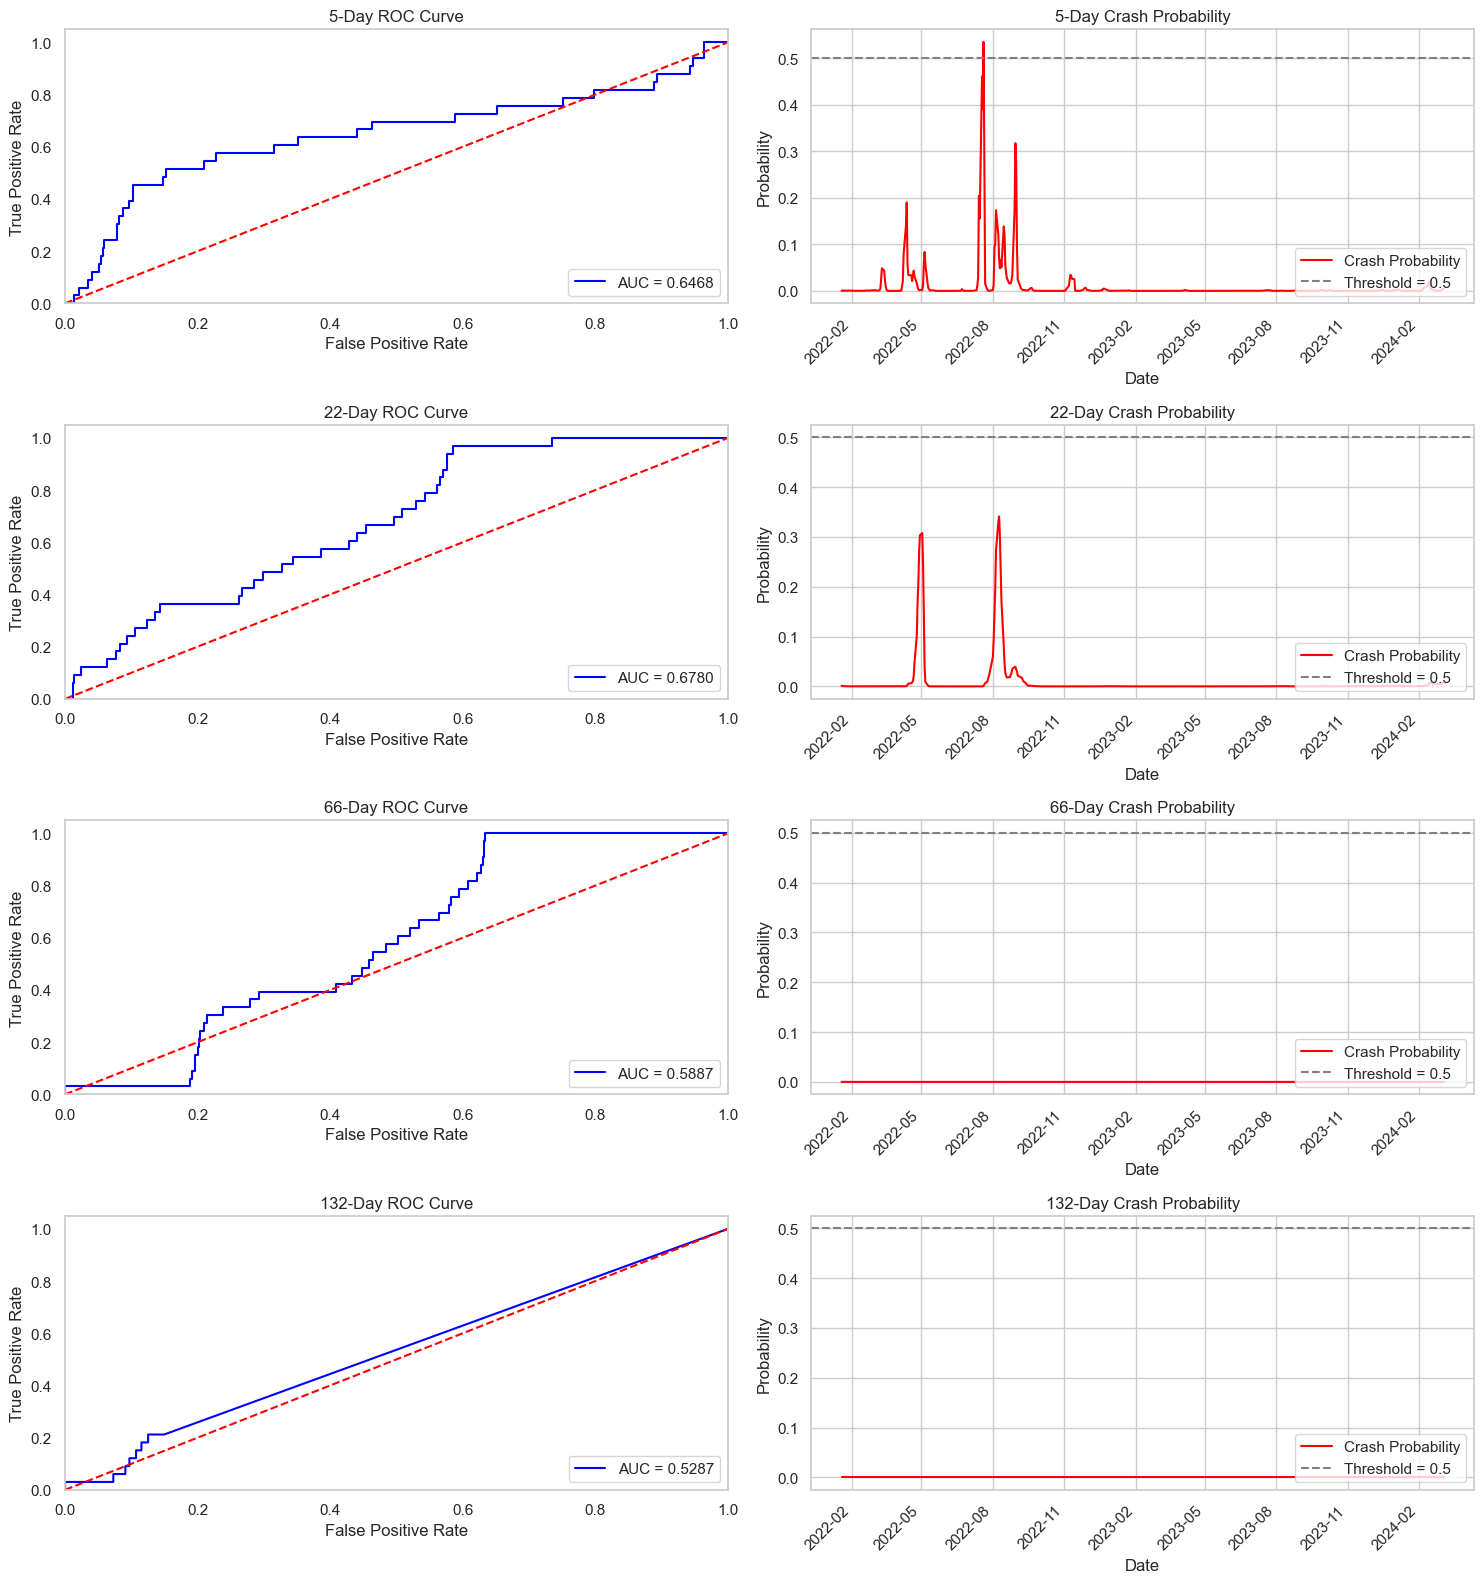

In [92]:
plot_ig_feature_attributions_grid(cnn_combined, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(cnn_combined, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


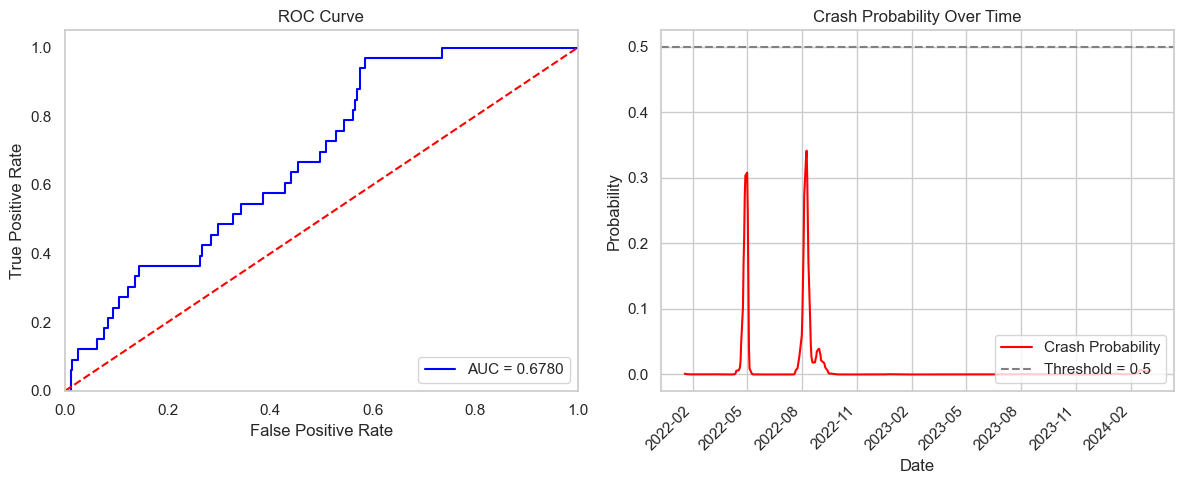

In [93]:
plot_CNN_roc_and_crash_prob_for_one(cnn_combined[22], X_test_dict[22], y_test_dict[22])

## LSTM

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def lstm_model(n, feature_cols, market_sentiment_data, lstm_results, X_test_dict, y_test_dict):
    train_data = market_sentiment_data[market_sentiment_data['Date'] < '2022-01-01']
    test_data = market_sentiment_data[(market_sentiment_data['Date'] >= '2022-01-01')]
    train_df = train_data.dropna(subset=feature_cols+['future_crash']).copy()
    test_df = test_data.dropna(subset=feature_cols+['future_crash']).copy()

    # Prepare feature matrices and target vectors
    X_train = train_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_train = train_df['future_crash']
    X_train_raw = X_train.values
    y_train_raw = y_train.values

    X_test = test_df[feature_cols].fillna(train_df[feature_cols].mean())
    y_test = test_df['future_crash']
    X_test_raw = X_test.values
    y_test_raw = y_test.values

    # X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
    X_train_resampled, y_train_resampled = X_train_raw, y_train_raw  # For simplicity, using original training data without resampling

    # Convert to DataFrame for convenience
    X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
    y_train_resampled = pd.Series(y_train_resampled)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test_raw)

    X_train, y_train, _ = create_sequences(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train_resampled, window=window_size)
    X_test, y_test, _ = create_sequences(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_raw), window=window_size)


    lstm_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, X_train.shape[2])),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['AUC'])

    lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Predict
    y_prob = lstm_model.predict(X_test).flatten()
    best_threshold = dynamic_threshold_calculate(y_test, y_prob)
    y_pred = (y_prob > best_threshold).astype(int)

    # Evaluate
    auc_score = roc_auc_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf = confusion_matrix(y_test, y_pred)
    date_seq = test_df['Date'].iloc[window_size:].reset_index(drop=True)

    # Save model and results
    lstm_results[n] = {
        'model': lstm_model,
        'auc_score': auc_score,
        'report': report,
        'y_test': y_test,
        'y_prob': y_prob,
        'features': feature_cols,
        'confusion': conf,
        'date_seq': date_seq,
    }

    X_test_dict[n] = X_test
    y_test_dict[n] = y_test

    print(f"\n=== {n}-Day LSTM Model ===")
    print(f"AUC: {auc_score:.3f}")
    print(report)

### LSTM (Market)

In [64]:
lstm_market = {}
X_test_dict = {}
y_test_dict = {}
window_size = 10  # Default window size 

for n in volatility_period:
    feature_cols = [
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_market, X_test_dict, y_test_dict)

all_results.append(lstm_market)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.5425 - loss: 0.4701 - val_AUC: 0.5202 - val_loss: 0.3839
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6389 - loss: 0.1548 - val_AUC: 0.4947 - val_loss: 0.4162
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6811 - loss: 0.1516 - val_AUC: 0.4578 - val_loss: 0.4103
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6594 - loss: 0.1502 - val_AUC: 0.4704 - val_loss: 0.4131
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6310 - loss: 0.1620 - val_AUC: 0.4650 - val_loss: 0.4518
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.7228 - loss: 0.1503 - val_AUC: 0.4711 - val_loss: 0.4223
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6658 - loss: 0.1659 - val_AUC: 0.4582 - val_loss: 0.4384
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6852 - loss: 0.1675 - val_AUC: 0.4645 - val_loss: 0.4147
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6861 - loss: 

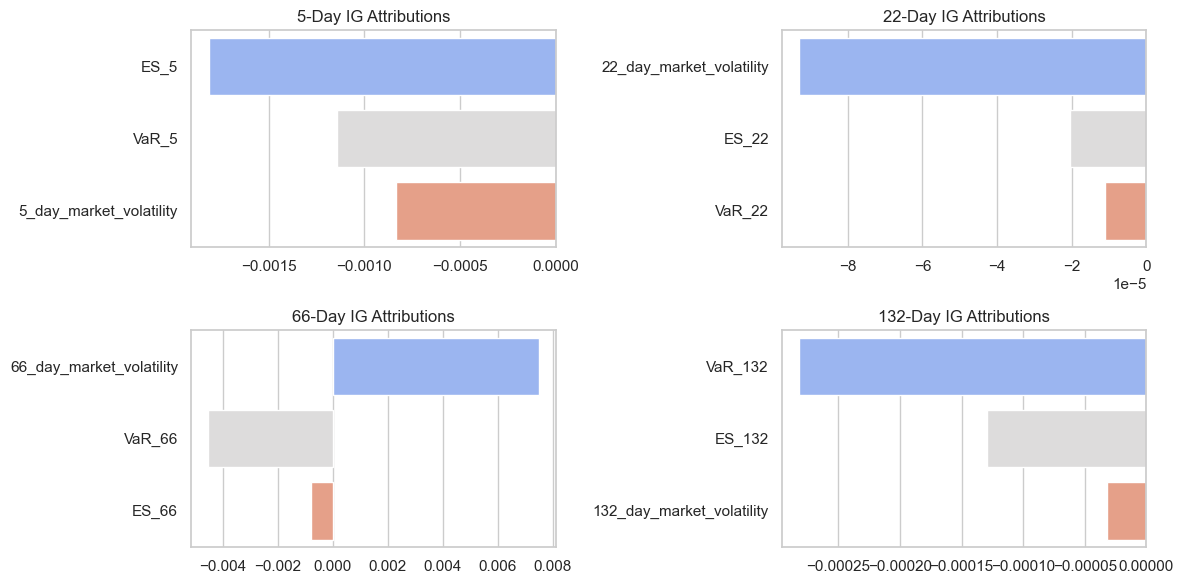

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


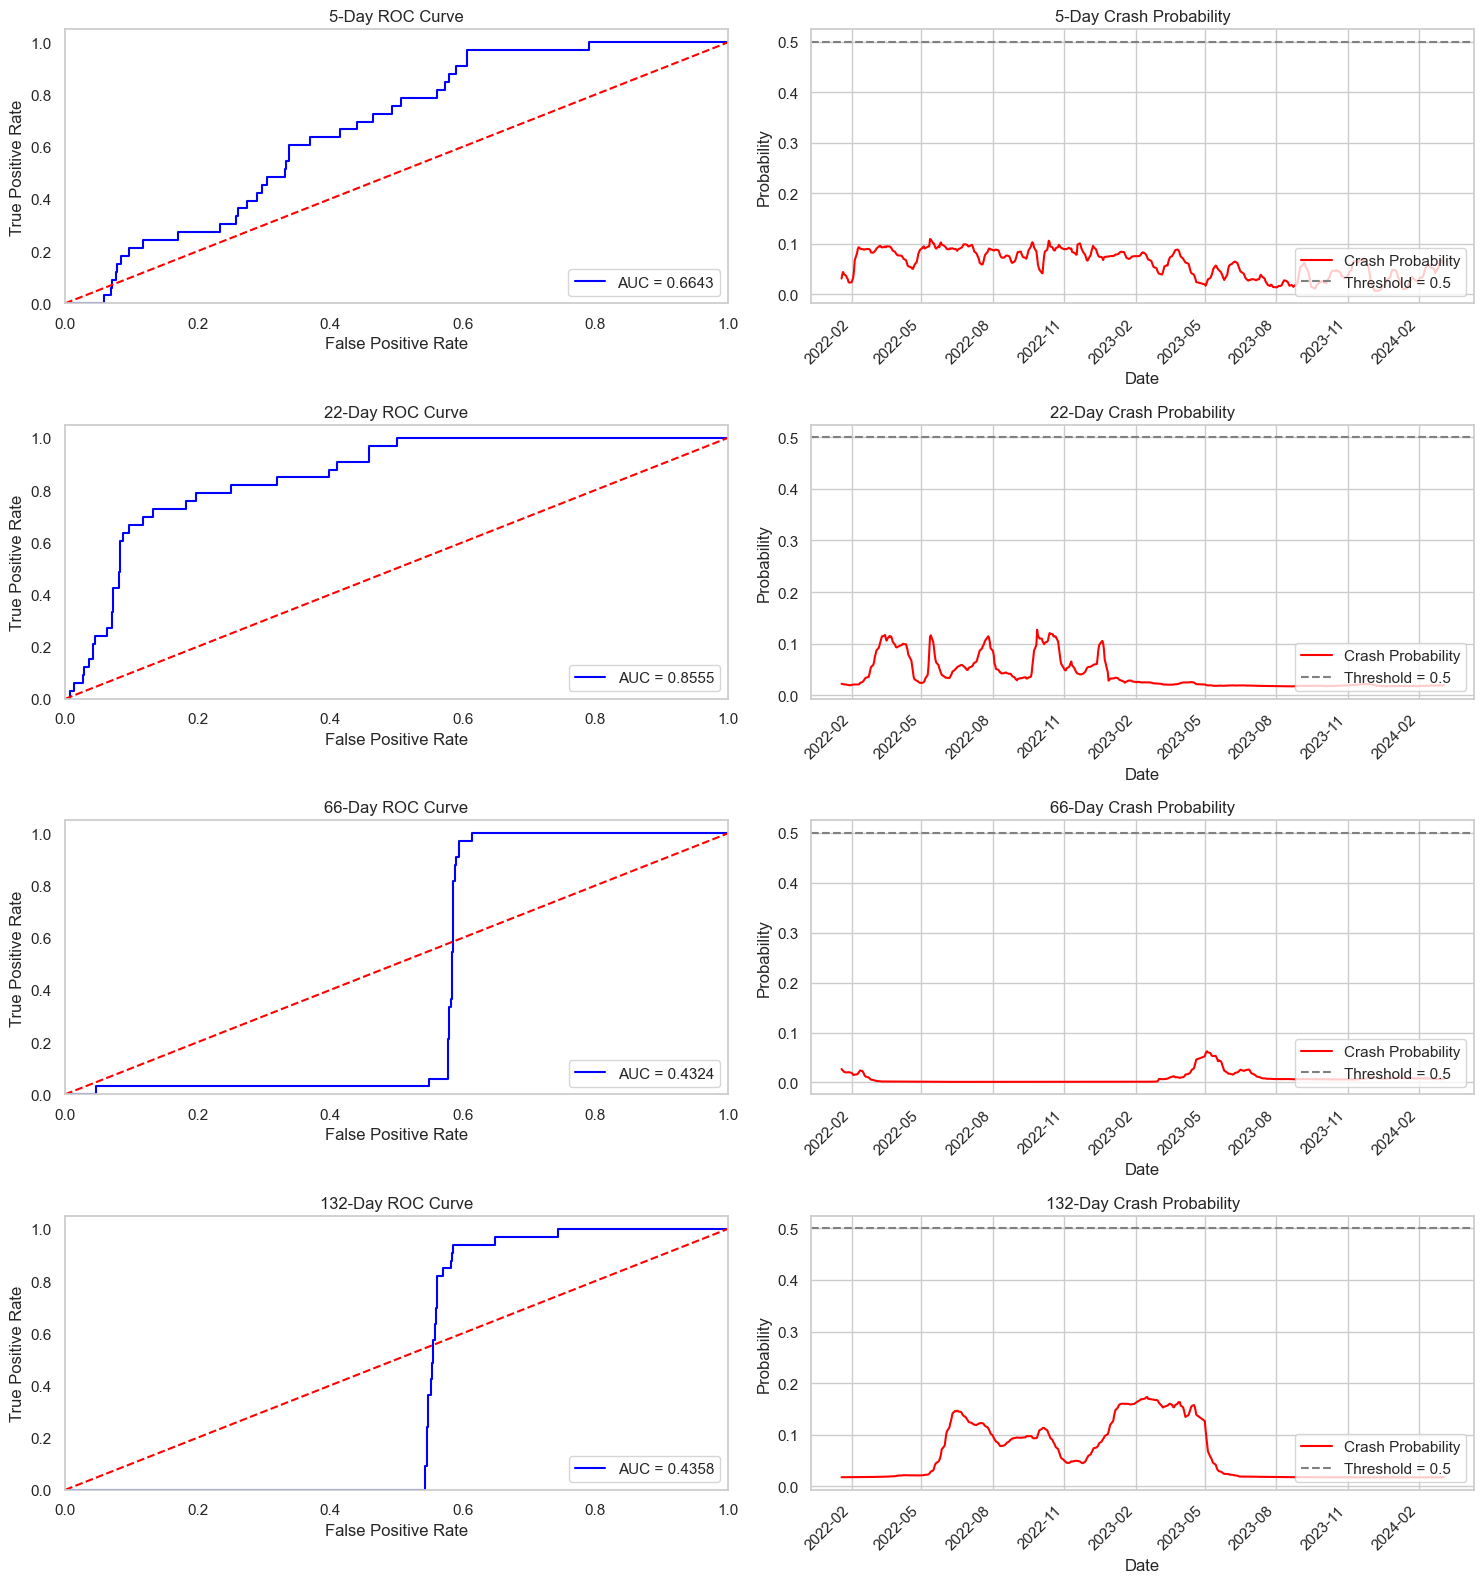

In [65]:
plot_ig_feature_attributions_grid(lstm_market, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(lstm_market, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


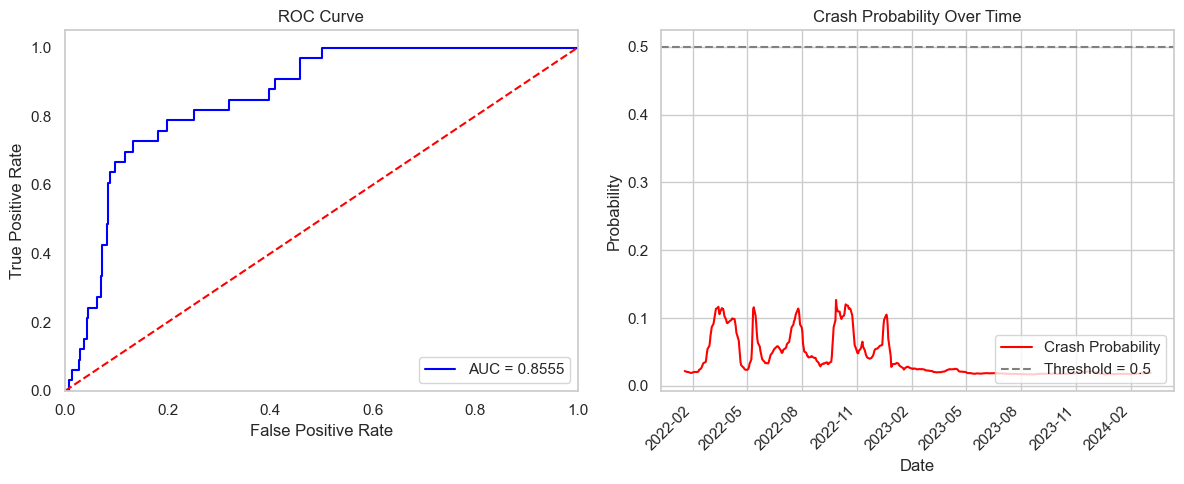

In [66]:
plot_CNN_roc_and_crash_prob_for_one(lstm_market[22], X_test_dict[22], y_test_dict[22])

### LSTM (Sentiment)

In [67]:
lstm_sentiment = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_sentiment, X_test_dict, y_test_dict)

all_results.append(lstm_sentiment)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - AUC: 0.5945 - loss: 0.4706 - val_AUC: 0.3704 - val_loss: 0.5450
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7916 - loss: 0.1465 - val_AUC: 0.3533 - val_loss: 0.5769
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7893 - loss: 0.1176 - val_AUC: 0.3600 - val_loss: 0.6082
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8485 - loss: 0.1323 - val_AUC: 0.3812 - val_loss: 0.6606
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8535 - loss: 0.1074 - val_AUC: 0.3473 - val_loss: 0.6439
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8682 - loss: 0.1186 - val_AUC: 0.3178 - val_loss: 0.6273
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8237 - loss: 0.1168 - val_AUC: 0.3055 - val_loss: 0.6116
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8559 - loss: 0.1212 - val_AUC: 0.3156 - val_loss: 0.6402
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8531 - loss: 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


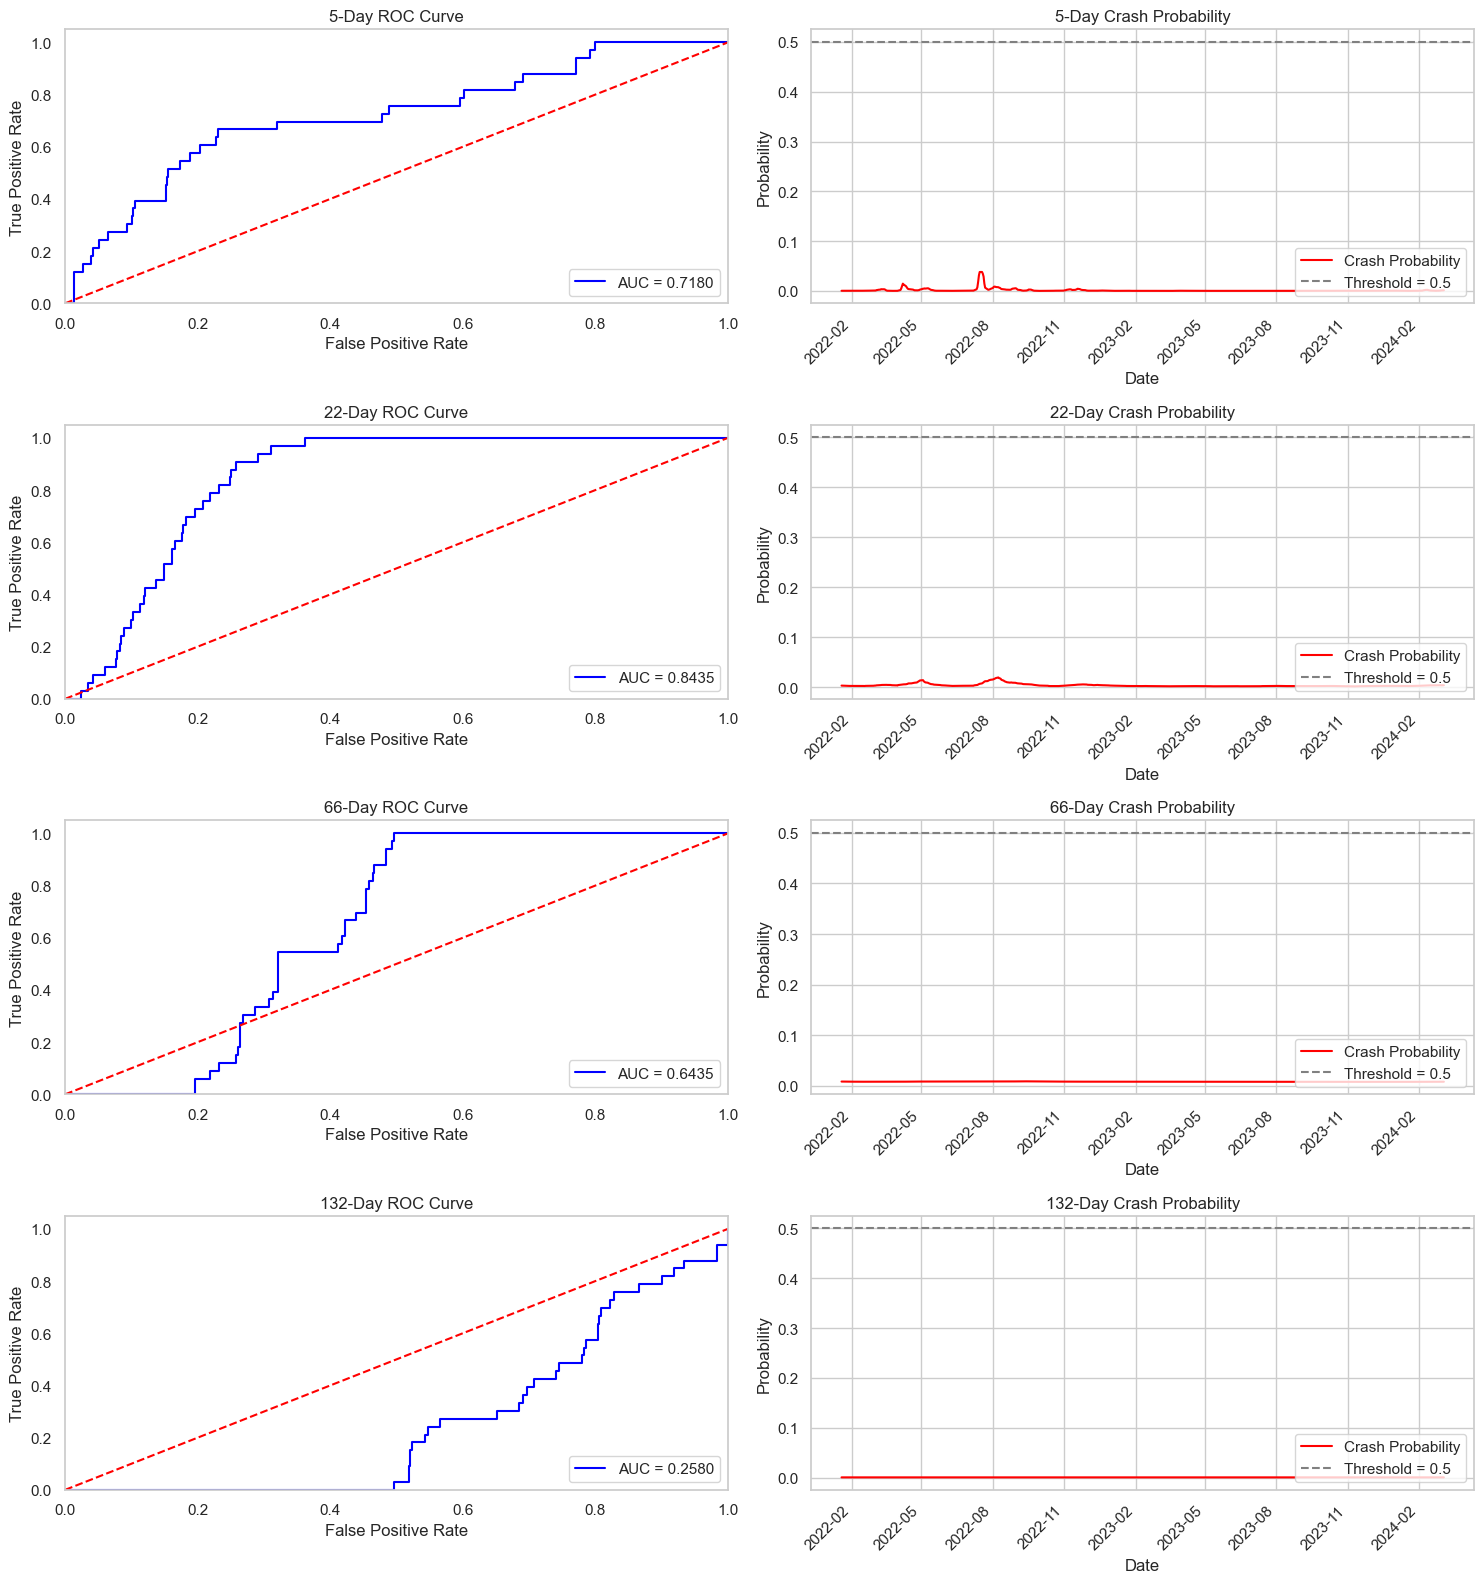

In [68]:
plot_CNN_roc_and_crash_probabilities(lstm_sentiment, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


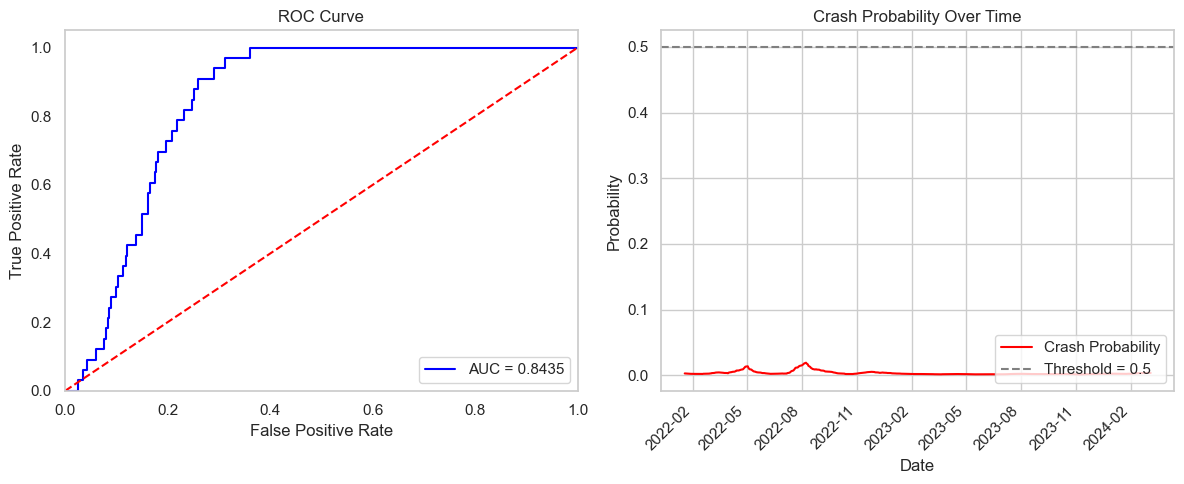

In [69]:
plot_CNN_roc_and_crash_prob_for_one(lstm_sentiment[22], X_test_dict[22], y_test_dict[22])

### LSTM (Market + Sentiment)

In [70]:
lstm_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]
    
    lstm_model(n, feature_cols, market_sentiment_data, lstm_combined, X_test_dict, y_test_dict)

all_results.append(lstm_combined)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - AUC: 0.5592 - loss: 0.4602 - val_AUC: 0.3355 - val_loss: 0.5262
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7953 - loss: 0.1197 - val_AUC: 0.3387 - val_loss: 0.6077
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8724 - loss: 0.1241 - val_AUC: 0.3910 - val_loss: 0.6943
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8548 - loss: 0.1188 - val_AUC: 0.3583 - val_loss: 0.6735
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9016 - loss: 0.1037 - val_AUC: 0.3305 - val_loss: 0.6334
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8707 - loss: 0.1169 - val_AUC: 0.3576 - val_loss: 0.7061
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8685 - loss: 0.1032 - val_AUC: 0.4255 - val_loss: 0.7908
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8163 - loss: 0.1076 - val_AUC: 0.3528 - val_loss: 0.7192
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8881 - loss: 

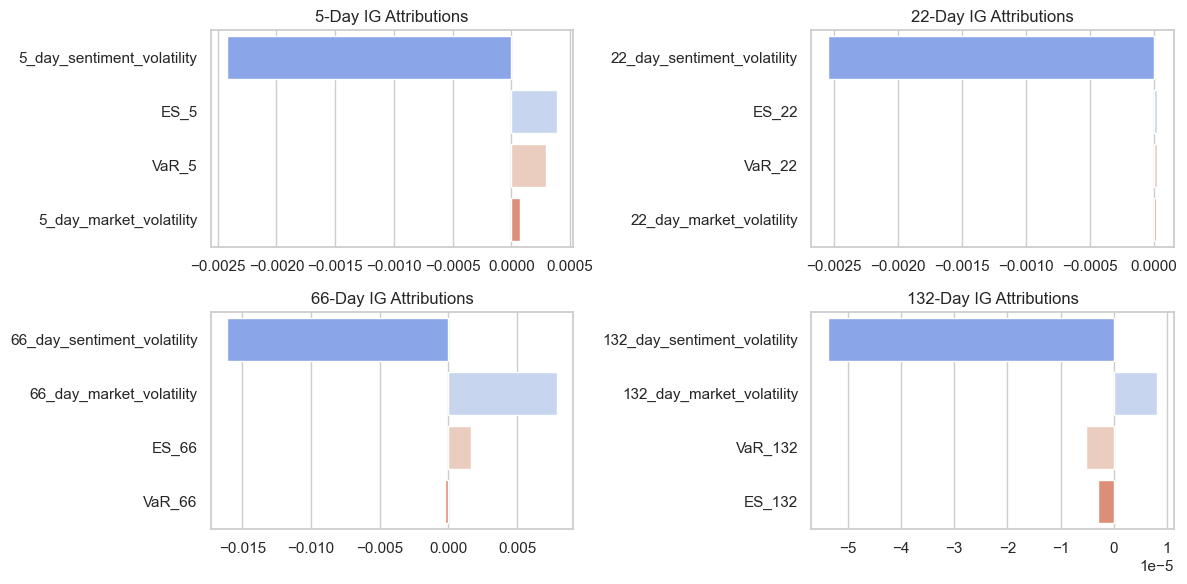

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


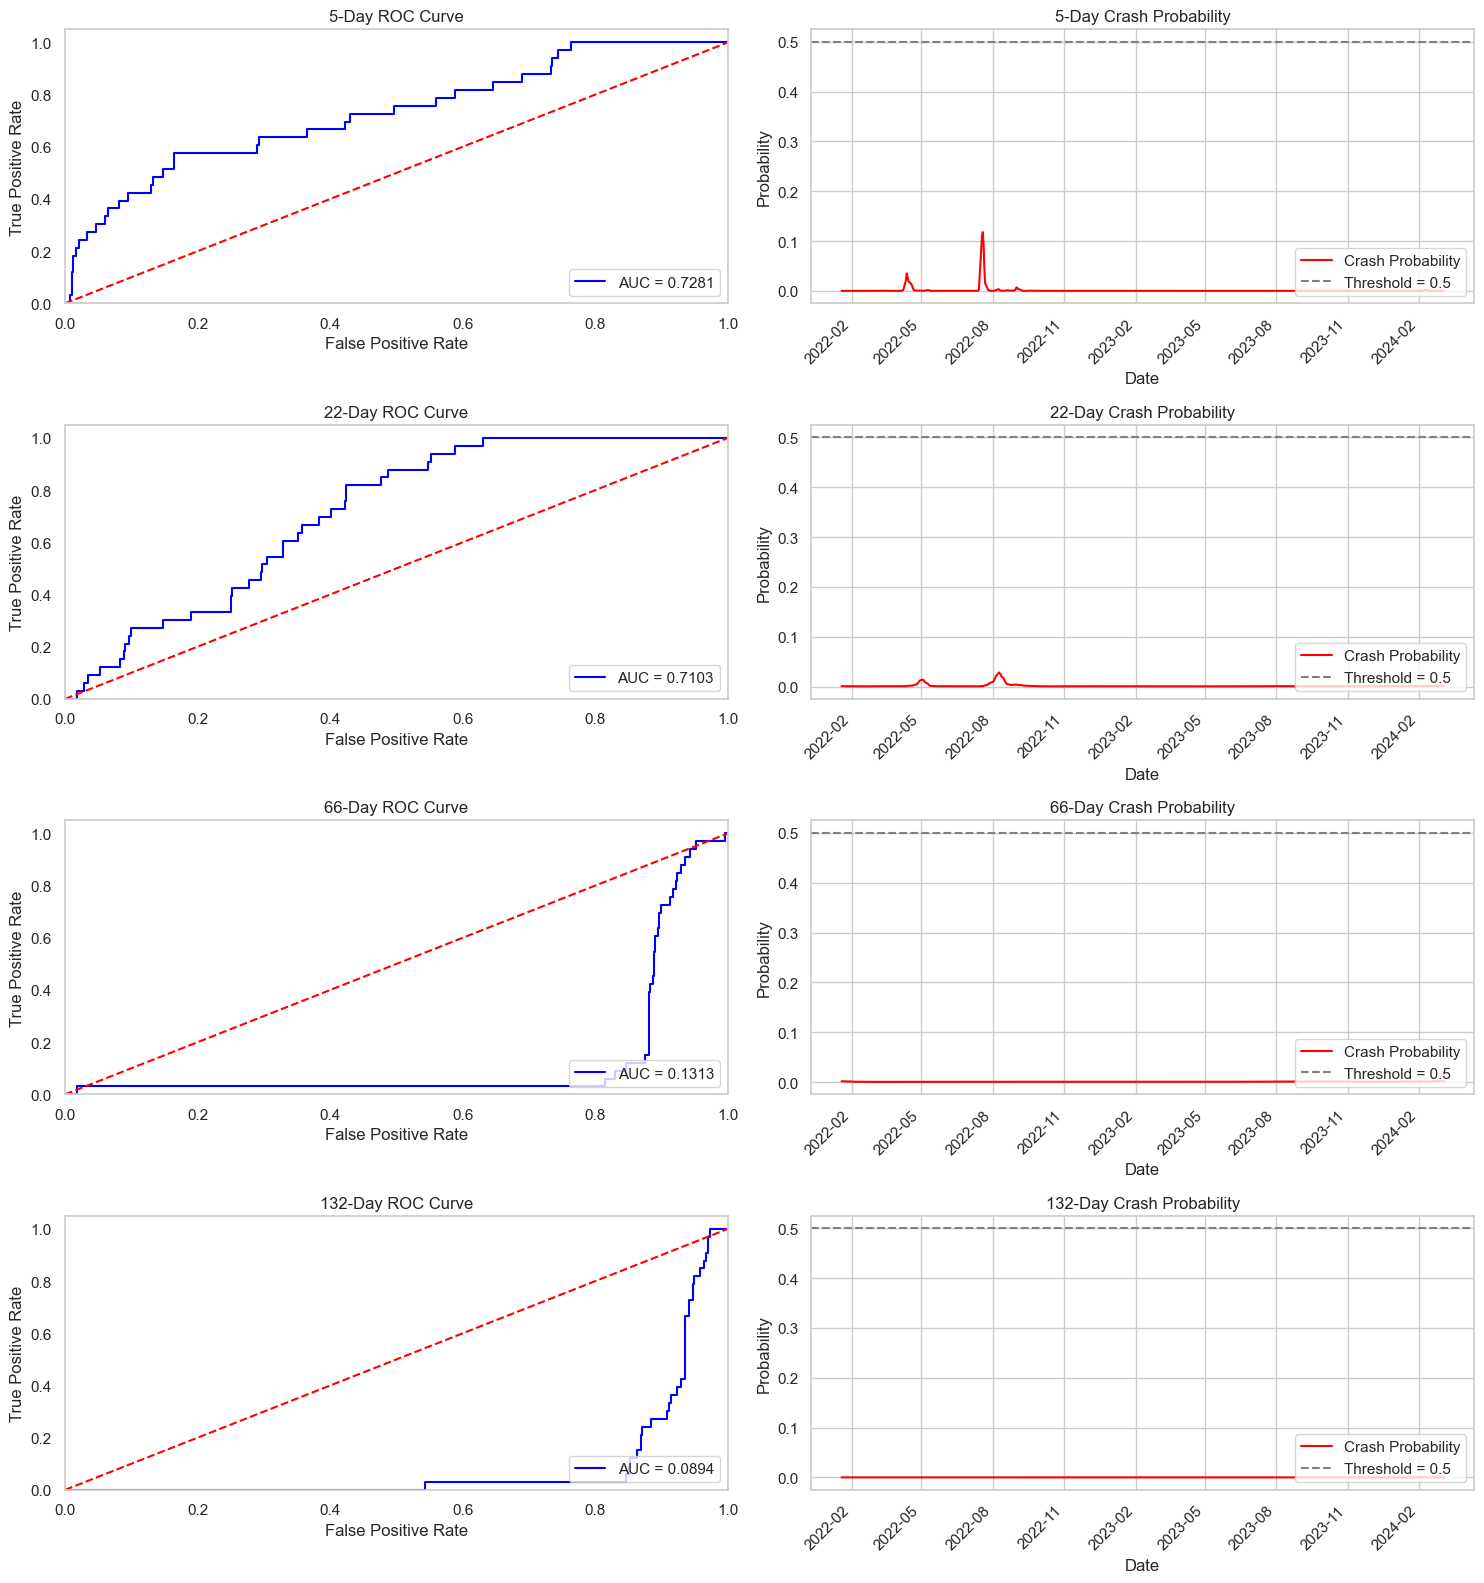

In [71]:
plot_ig_feature_attributions_grid(lstm_combined, X_test_dict, window_size=window_size)
plot_CNN_roc_and_crash_probabilities(lstm_combined, X_test_dict, y_test_dict)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


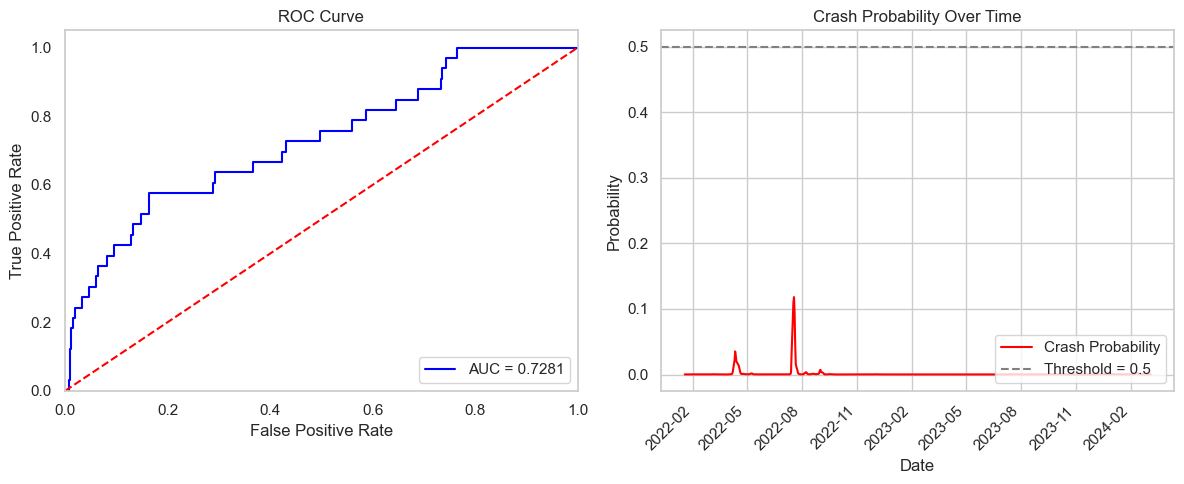

In [72]:
plot_CNN_roc_and_crash_prob_for_one(lstm_combined[5], X_test_dict[5], y_test_dict[5])

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


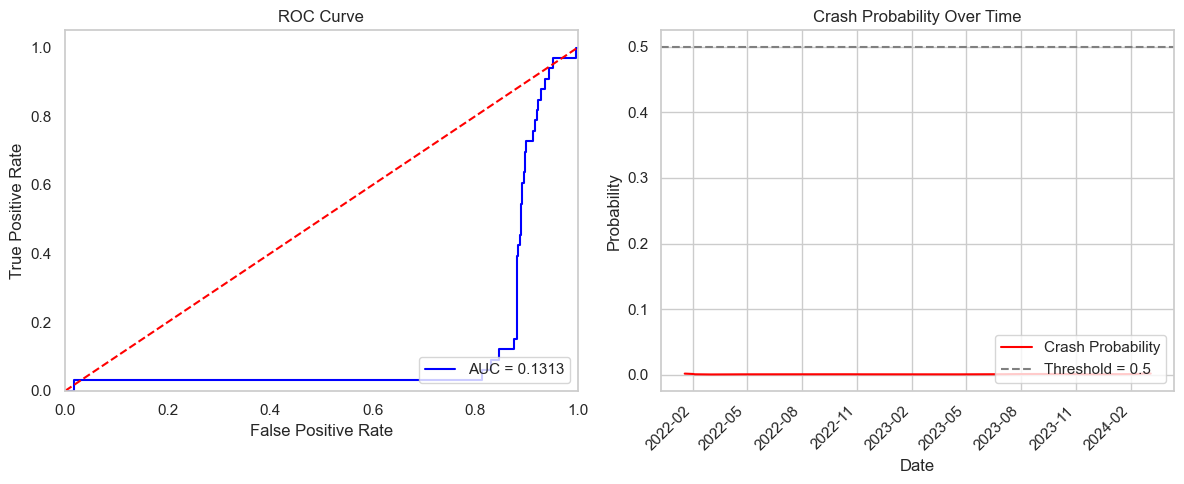

In [73]:
plot_CNN_roc_and_crash_prob_for_one(lstm_combined[66], X_test_dict[66], y_test_dict[66])

## Evaluate

In [74]:
# Summarize table of results -> Sensitivity, Specificity, Accuracy, AUC
i = 0
results_summary = []
results_dicts = [static_logit_market, static_logit_sentiment, static_logit_combined,
                 dynamic_logit_market, dynamic_logit_sentiment, dynamic_logit_combined,
                 cnn_market, cnn_sentiment, cnn_combined,
                 lstm_market, lstm_sentiment, lstm_combined]
results_dicts_name = ['Static_Logit_Market', 'Static_Logit_Sentiment', 'Static_Logit_Combined',
                      'Dynamic_Logit_Market', 'Dynamic_Logit_Sentiment', 'Dynamic_Logit_Combined',
                      'CNN_Market', 'CNN_Sentiment', 'CNN_Combined',
                      'LSTM_Market', 'LSTM_Sentiment', 'LSTM_Combined']

for results in results_dicts:
    for n in volatility_period:
        if n in results:
            res = results[n]
            auc_score = res['auc_score']
            report = res['report']
            cm = res['confusion']

            TN, FP = cm[0]
            FN, TP = cm[1]
            total = cm.sum()

            TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0  # Sensitivity
            TNR = TN / (TN + FP) if (TN + FP) > 0 else 0.0  # Specificity
            FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
            FNR = FN / (TP + FN) if (TP + FN) > 0 else 0.0
            ACC = (TP + TN) / total
            PPV = TP / (TP + FP) if (TP + FP) > 0 else 0.0  # Precision
            FOR = FN / (FN + TN) if (FN + TN) > 0 else 0.0
            NSR = FPR / TPR if TPR > 0 else float('inf')
            f1_score = report['1']['f1-score']

        else:
            TPR = TNR = FPR = FNR = ACC = PPV = FOR = NSR = auc_score = f1_score = None

        results_summary.append({
            'model': f'{results_dicts_name[i]}_{n}',
            'TPR': np.round(TPR, 4),
            'TNR': np.round(TNR, 4),
            'FPR': np.round(FPR, 4),
            'FNR': np.round(FNR, 4),
            'PPV': np.round(PPV, 4),
            'FOR': np.round(FOR, 4),
            'NSR': np.round(NSR, 4),
            'ACC': np.round(ACC, 4),
            'AUC': np.round(auc_score, 4),
            'F1': np.round(f1_score, 4),
        })

    i += 1


# Define weighted scoring function
w_TPR, w_TNR, w_FPR, w_FNR, w_PPV, w_FOR, w_NSR, w_accuracy, w_auc_score, w_f1_score = (
    0.6, 0.3, -0.1, -0.3, 0.2, -0.1, -0.1, 0.2, 0, 0
)

def weighted_score(TPR, TNR, FPR, FNR, PPV, FOR, NSR, accuracy, 
                   w_TPR, w_TNR, w_FPR, w_FNR, w_PPV, w_FOR, w_NSR, w_accuracy, w_auc_score, w_f1_score):
    
    if None in (TPR, TNR, FPR, FNR, PPV, FOR, NSR, accuracy, auc_score, f1_score):
        return None

    return np.round(w_TPR * TPR +
            w_TNR * TNR +
            w_FPR * FPR +
            w_FNR * FNR +
            w_PPV * PPV +
            w_FOR * FOR +
            w_NSR * NSR +
            w_accuracy * accuracy, 4
            # w_auc_score * auc_score +
            # w_f1_score * f1_score, 4
            )

results_summary_df = pd.DataFrame(results_summary)
results_summary_df = results_summary_df.dropna().reset_index(drop=True)

results_summary_df['weighted_score'] = results_summary_df.apply(
    lambda row: weighted_score(row['TPR'], row['TNR'], row['FPR'], row['FNR'],
                               row['PPV'], row['FOR'], row['NSR'], row['ACC'],
                            #    row['AUC'], row['F1'],
                               w_TPR, w_TNR, w_FPR, w_FNR, w_PPV, w_FOR, w_NSR, w_accuracy, w_auc_score, w_f1_score),
    axis=1
)

results_summary_df = results_summary_df.sort_values(by='weighted_score', ascending=False).reset_index(drop=True)

# Save results to CSV
results_summary_df.to_csv('market_sentiment_crash_prediction_results_summary.csv', index=False)
results_summary_df

model     TPR     TNR     FPR     FNR     PPV  \
0              CNN_Sentiment_22  0.9394  0.7293  0.2707  0.0606  0.1879   
1      Static_Logit_Combined_22  0.8605  0.7374  0.2626  0.1395  0.2216   
2             LSTM_Sentiment_66  0.9697  0.5030  0.4970  0.0303  0.1151   
3              CNN_Sentiment_66  0.9697  0.4889  0.5111  0.0303  0.1123   
4                LSTM_Market_22  0.6061  0.9131  0.0869  0.3939  0.3175   
5     Dynamic_Logit_Combined_22  0.6279  0.8828  0.1172  0.3721  0.3176   
6                CNN_Market_132  0.9394  0.5152  0.4848  0.0606  0.1144   
7   Dynamic_Logit_Sentiment_132  0.4186  0.9879  0.0121  0.5814  0.7500   
8             LSTM_Sentiment_22  0.6667  0.8182  0.1818  0.3333  0.1964   
9      Dynamic_Logit_Market_132  0.9535  0.4384  0.5616  0.0465  0.1285   
10   Dynamic_Logit_Combined_132  0.4186  0.9838  0.0162  0.5814  0.6923   
11               LSTM_Market_66  0.9697  0.3859  0.6141  0.0303  0.0952   
12              CNN_Combined_66  0.9697  0.3515  0.6485  0.0303  0.0907   
13              LSTM_Market_132  0.9091  0.4141  0.5859  0.0909  0.0938   
14             LSTM_Combined_22  0.7879  0.5758  0.4242  0.2121  0.1102   
15                CNN_Market_66  0.9394  0.3616  0.6384  0.0606  0.0893   
16    Dynamic_Logit_Sentiment_5  0.7209  0.6444  0.3556  0.2791  0.1498   
17    Static_Logit_Combined_132  0.2558  1.0000  0.0000  0.7442  1.0000   
18      Static_Logit_Market_132  0.8372  0.4848  0.5152  0.1628  0.1237   
19     Static_Logit_Combined_66  1.0000  0.2364  0.7636  0.0000  0.1021   
20                 CNN_Market_5  0.9394  0.3232  0.6768  0.0606  0.0847   
21      Static_Logit_Combined_5  0.8372  0.4586  0.5414  0.1628  0.1184   
22       Static_Logit_Market_66  0.9767  0.2586  0.7414  0.0233  0.1027   
23      Dynamic_Logit_Market_22  1.0000  0.2141  0.7859  0.0000  0.0995   
24   Static_Logit_Sentiment_132  0.2326  0.9980  0.0020  0.7674  0.9091   
25      Dynamic_Logit_Market_66  1.0000  0.1859  0.8141  0.0000  0.0964   
26   Dynamic_Logit_Sentiment_22  0.4186  0.9152  0.0848  0.5814  0.3000   
27    Static_Logit_Sentiment_22  0.4419  0.8949  0.1051  0.5581  0.2676   
28             LSTM_Sentiment_5  0.4848  0.8444  0.1556  0.5152  0.1720   
29              CNN_Sentiment_5  0.5152  0.8061  0.1939  0.4848  0.1504   
30       Static_Logit_Market_22  0.6279  0.6606  0.3394  0.3721  0.1385   
31     Dynamic_Logit_Combined_5  0.5116  0.7818  0.2182  0.4884  0.1692   
32    Static_Logit_Sentiment_66  1.0000  0.1131  0.8869  0.0000  0.0892   
33                CNN_Market_22  0.4848  0.8000  0.2000  0.5152  0.1391   
34        Static_Logit_Market_5  0.8605  0.2889  0.7111  0.1395  0.0951   
35    Dynamic_Logit_Combined_66  1.0000  0.0667  0.9333  0.0000  0.0851   
36               CNN_Combined_5  0.3636  0.9091  0.0909  0.6364  0.2105   
37                LSTM_Market_5  0.5758  0.6626  0.3374  0.4242  0.1022   
38              LSTM_Combined_5  0.2121  0.9798  0.0202  0.7879  0.4118   
39   Dynamic_Logit_Sentiment_66  1.0000  0.0000  1.0000  0.0000  0.0799   
40            LSTM_Combined_132  0.9697  0.0263  0.9737  0.0303  0.0623   
41             LSTM_Combined_66  0.9394  0.0485  0.9515  0.0606  0.0618   
42     Static_Logit_Sentiment_5  0.2558  0.9152  0.0848  0.7442  0.2075   
43              CNN_Combined_22  0.2424  0.9172  0.0828  0.7576  0.1633   
44       Dynamic_Logit_Market_5  0.2791  0.8343  0.1657  0.7209  0.1277   
45           LSTM_Sentiment_132  0.9697  0.0000  1.0000  0.0303  0.0607   
46             CNN_Combined_132  0.2727  0.8162  0.1838  0.7273  0.0900   
47            CNN_Sentiment_132  0.0000  1.0000  0.0000  1.0000  0.0000   

       FOR     NSR     ACC     AUC      F1  weighted_score  
0   0.0055  0.2882  0.7424  0.8365  0.3131          0.8939  
1   0.0162  0.3052  0.7472  0.8283  0.3524          0.8310  
2   0.0040  0.5125  0.5322  0.6435  0.2058          0.7517  
3   0.0041  0.5271  0.5189  0.6486  0.2013          0.7414  
4   0.0280  0.1433  0.8939  0.8555  0.4167   

In [75]:
filtered_df = results_summary_df[results_summary_df['NSR'] <= 0.34].reset_index(drop=True)
filtered_df = filtered_df[filtered_df['FNR'] <= 0.5].reset_index(drop=True)

# Sort by weighted score (descending)
filtered_df = filtered_df.sort_values(by='weighted_score', ascending=False).reset_index(drop=True)
filtered_df.to_csv('NSR_thresh_market_sentiment_crash_prediction_results_summary.csv', index=False)
filtered_df

model     TPR     TNR     FPR     FNR     PPV     FOR  \
0           CNN_Sentiment_22  0.9394  0.7293  0.2707  0.0606  0.1879  0.0055   
1   Static_Logit_Combined_22  0.8605  0.7374  0.2626  0.1395  0.2216  0.0162   
2             LSTM_Market_22  0.6061  0.9131  0.0869  0.3939  0.3175  0.0280   
3  Dynamic_Logit_Combined_22  0.6279  0.8828  0.1172  0.3721  0.3176  0.0353   
4          LSTM_Sentiment_22  0.6667  0.8182  0.1818  0.3333  0.1964  0.0264   

      NSR     ACC     AUC      F1  weighted_score  
0  0.2882  0.7424  0.8365  0.3131          0.8939  
1  0.3052  0.7472  0.8283  0.3524          0.8310  
2  0.1433  0.8939  0.8555  0.4167          0.7359  
3  0.1866  0.8625  0.8339  0.4219          0.7321  
4  0.2727  0.8087  0.8435  0.3034          0.6984

In [76]:
# Make a list of model names from the filtered DataFrame
model_names = filtered_df['model'].tolist()

# Get a list of model name in results_dicts form for plotting
# For exmaple, if model name is 'Static_Logit_Market_5', then result should be static_logit_market and n = 5
# Store as a tupple (model_type, n)
model_results = []
for model_name in model_names:
    parts = model_name.split('_')
    model_type = '_'.join(parts[:-1]).lower()  # Get the model type (e.g., static_logit_market)
    n = int(parts[-1])  # Get the n value (e.g., 5)
    model_results.append((model_type, n))

model_results

[('cnn_sentiment', 22),
 ('static_logit_combined', 22),
 ('lstm_market', 22),
 ('dynamic_logit_combined', 22),
 ('lstm_sentiment', 22)]

In [82]:
cnn_combined = {}
X_test_dict = {}
y_test_dict = {}

for n in volatility_period:
    feature_cols = [
        f'{n}_day_sentiment_volatility',
        f'{n}_day_market_volatility',
        f'VaR_{n}',
        f'ES_{n}',
    ]

    cnn_model(n, feature_cols, market_sentiment_data, cnn_combined, X_test_dict, y_test_dict, lag=10, window_size=window_size)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.01, F1: 0.30

=== 5-Day CNN Model ===
AUC: 0.647
              precision    recall  f1-score   support

           0       0.96      0.92      0.93       495
           1       0.22      0.36      0.28        33

    accuracy                           0.88       528
   macro avg       0.59      0.64      0.61       528
weighted avg       0.91      0.88      0.89       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.01, F1: 0.21

=== 22-Day CNN Model ===
AUC: 0.713
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       495
           1       0.15      0.24      0.19        33

    accuracy                           0.87       528
   macro avg       0.55      0.58      0.56       528
weighted avg       0.90      0.87      0.88       528

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Best threshold: 0.00, F1: 0.17

=== 66-Day CNN Model ===
AUC: 0.541
              precision   

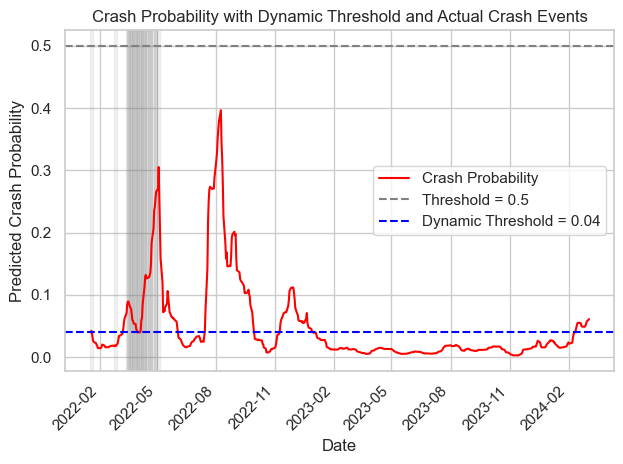

In [131]:
def plot_crash_probabilities_CNN(result):
    y_prob = result['y_prob']
    y_test_seq = result['y_test']
    date_seq = result['date_seq']
    
    df_plot = pd.DataFrame({
        'date': date_seq,
        'crash_probability': y_prob,
        'actual_crash': y_test_seq,
    })

    # --- calculate dynamic threshold ---
    precision, recall, thresholds = precision_recall_curve(y_test_seq, y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-6)
    best_idx = np.argmax(f1_scores)
    # best_thresh = f1_scores[best_idx]
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # Fallback to 0.5 if out of bounds

    # highlight actual crash periods
    crash_dates = df_plot[df_plot["actual_crash"] == 1]["date"]
    if not crash_dates.empty:
        for crash_date in crash_dates:
            plt.axvspan(crash_date - pd.Timedelta(days=2),
                        crash_date + pd.Timedelta(days=2),
                        color="gray", alpha=0.1)

    plt.plot(df_plot['date'], df_plot['crash_probability'], label='Crash Probability', color='red')
    plt.axhline(0.5, linestyle='--', color='gray', label='Threshold = 0.5')  # Example threshold
    plt.axhline(best_thresh, linestyle="--", color="blue", label=f"Dynamic Threshold = {best_thresh:.2f}")
    plt.title("Crash Probability with Dynamic Threshold and Actual Crash Events")
    plt.xlabel("Date")
    plt.ylabel("Predicted Crash Probability")
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45, ha="right")
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_crash_probabilities_CNN(cnn_sentiment[22])

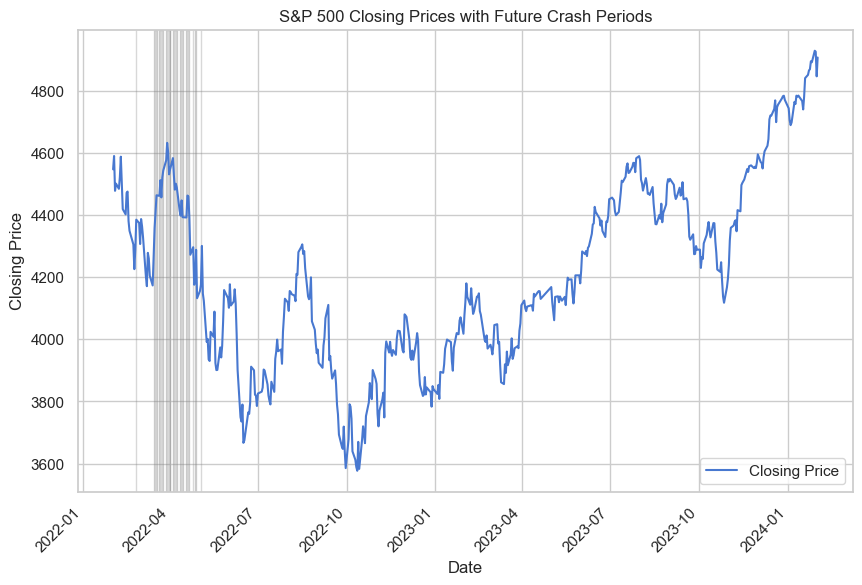

In [135]:
# Plot close prices and future crash labels as grey areas
sp500_headlines_2008_2024_label_added_after_2022 = sp500_headlines_2008_2024_label_added[
    (sp500_headlines_2008_2024_label_added['Date'] >= '2022-02-01') &
    (sp500_headlines_2008_2024_label_added['Date'] <= '2024-02-01')
]


plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Close', data=sp500_headlines_2008_2024_label_added_after_2022, label='Closing Price')

# Identify crash periods
crash_periods = sp500_headlines_2008_2024_label_added_after_2022[
    sp500_headlines_2008_2024_label_added_after_2022['future_crash'] == 1
]

# Group consecutive crash days into continuous intervals
crash_groups = (crash_periods['Date'].diff().dt.days > 1).cumsum()
for _, group in crash_periods.groupby(crash_groups):
    plt.axvspan(group['Date'].iloc[0], group['Date'].iloc[-1], color='grey', alpha=0.3)

plt.title('S&P 500 Closing Prices with Future Crash Periods')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

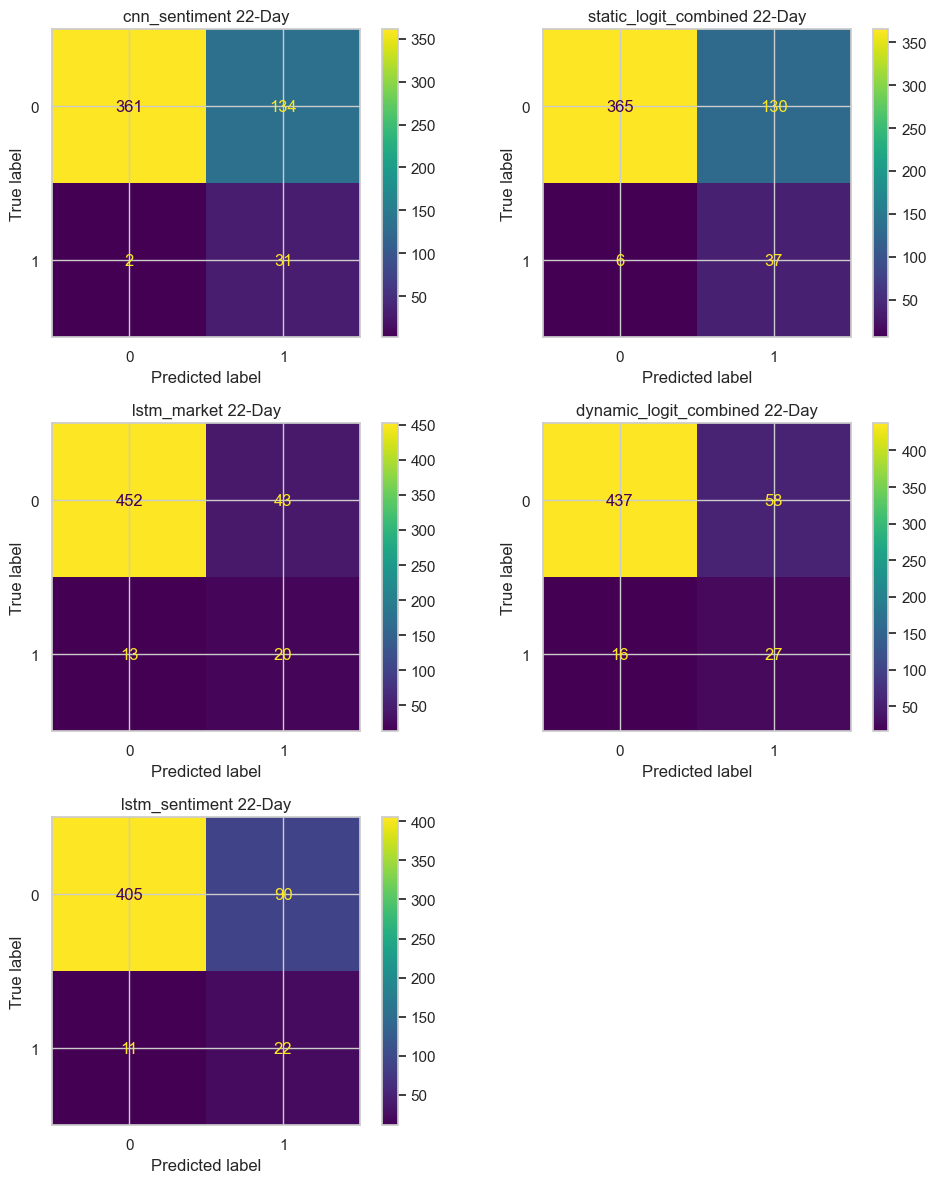

In [77]:
conf_matrices = []
titles = []
for model in model_results:
    model_type, n = model
    if model_type == 'static_logit_market':
        conf_matrices.append(static_logit_market[n]['confusion'])
    elif model_type == 'static_logit_sentiment':
        conf_matrices.append(static_logit_sentiment[n]['confusion'])
    elif model_type == 'static_logit_combined':
        conf_matrices.append(static_logit_combined[n]['confusion'])
    elif model_type == 'dynamic_logit_market':
        conf_matrices.append(dynamic_logit_market[n]['confusion'])
    elif model_type == 'dynamic_logit_sentiment':
        conf_matrices.append(dynamic_logit_sentiment[n]['confusion'])
    elif model_type == 'dynamic_logit_combined':
        conf_matrices.append(dynamic_logit_combined[n]['confusion'])
    elif model_type == 'cnn_market':
        conf_matrices.append(cnn_market[n]['confusion'])
    elif model_type == 'cnn_sentiment':
        conf_matrices.append(cnn_sentiment[n]['confusion'])
    elif model_type == 'cnn_combined':
        conf_matrices.append(cnn_combined[n]['confusion'])
    elif model_type == 'lstm_market':
        conf_matrices.append(lstm_market[n]['confusion'])
    elif model_type == 'lstm_sentiment':
        conf_matrices.append(lstm_sentiment[n]['confusion'])
    elif model_type == 'lstm_combined':
        conf_matrices.append(lstm_combined[n]['confusion'])
    titles.append(f'{model_type} {n}-Day')

plot_confusion_matrix_grid(conf_matrices, titles, ncols=2)

## RF + Logit

In [78]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- Setup ---
RANDOM_STATE = 42

# Select features and target
features = [
    '5_day_market_volatility',
    '5_day_sentiment_volatility',
    'VaR_5',
    'ES_5',
    '22_day_market_volatility',
    '22_day_sentiment_volatility',
    'VaR_22',
    'ES_22',
    '66_day_market_volatility',
    '66_day_sentiment_volatility',
    'VaR_66',
    'ES_66',
    '132_day_market_volatility',
    '132_day_sentiment_volatility',
    'VaR_132',
    'ES_132',
]
target = 'future_crash'

# Drop NA values
df_model = market_sentiment_data.dropna(subset=features + [target]).copy()
X = df_model[features]
y = df_model[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

# --- Step 1: Random Forest for Feature Selection ---
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced', max_depth=10, min_samples_split=5, min_samples_leaf=2)
rf.fit(X_train, y_train)

# Get feature importances
feat_importances = pd.Series(rf.feature_importances_, index=features)
top_features = feat_importances.sort_values(ascending=False).head(5).index.tolist()

print("Top Features from Random Forest:")
print(top_features)

# --- Step 2: Logistic Regression with Top Features ---
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)

# Fit logistic regression
logit = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
logit.fit(X_train_scaled, y_train)

# Predict
y_proba = logit.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Evaluation
auc = roc_auc_score(y_test, y_proba)
report = classification_report(y_test, y_pred)

# Coefficients
coefs = pd.DataFrame({
    'Feature': top_features,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\n=== Logistic Regression Results ===")
print(f"AUC: {auc:.3f}")
print(report)


Top Features from Random Forest:
['132_day_sentiment_volatility', 'VaR_66', '66_day_sentiment_volatility', '66_day_market_volatility', 'ES_66']

=== Logistic Regression Results ===
AUC: 0.714
              precision    recall  f1-score   support

           0       0.98      0.56      0.71       647
           1       0.07      0.71      0.12        28

    accuracy                           0.57       675
   macro avg       0.52      0.64      0.42       675
weighted avg       0.94      0.57      0.69       675



In [79]:
from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, mean_squared_error
import statsmodels.api as sm
import numpy as np

# Assume y_test, y_pred, y_proba, and X_train_scaled already defined
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

sensitivity = recall_score(y_test, y_pred, pos_label=1)
specificity = tn / (tn + fp)
misclass_error = 1 - accuracy_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_proba))

# McFadden's R² and AIC via statsmodels
X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const).fit(disp=False)

mcfadden_r2 = 1 - logit_model.llf / logit_model.llnull
aic = logit_model.aic

print("Sensitivity (Recall for 1):", round(sensitivity, 3))
print("Specificity (True Negative Rate):", round(specificity, 3))
print("Misclassification Error:", round(misclass_error, 3))
print("RMSE:", round(rmse, 3))
print("McFadden Pseudo R²:", round(mcfadden_r2, 3))
print("AIC:", round(aic, 2))

Sensitivity (Recall for 1): 0.714
Specificity (True Negative Rate): 0.56
Misclassification Error: 0.434
RMSE: 0.486
McFadden Pseudo R²: 0.031
AIC: 925.05
